## Wind Speed

### 1DCNN

Train windows: 174913, Validation windows: 16128, Test windows: 8352
First window ts: 2014-01-02 23:55:00, Last: 2024-12-24 23:55:00
No. of parameters: 8300640
Ep01 Train=0.0103 | Val=0.0030 | Val(last) RMSE=1.5 MAE=1.2 MAPE=27.96% R²=0.435 | Val(full) RMSE=1.4 MAE=1.1 MAPE=26.44% R²=0.526 | LR=0.000050 | Time=39.2s
Ep02 Train=0.0032 | Val=0.0024 | Val(last) RMSE=1.5 MAE=1.1 MAPE=27.73% R²=0.456 | Val(full) RMSE=1.3 MAE=1.0 MAPE=23.84% R²=0.614 | LR=0.000075 | Time=36.8s
Ep03 Train=0.0028 | Val=0.0025 | Val(last) RMSE=1.5 MAE=1.2 MAPE=28.22% R²=0.436 | Val(full) RMSE=1.3 MAE=1.0 MAPE=24.00% R²=0.607 | LR=0.000100 | Time=38.2s
Ep04 Train=0.0028 | Val=0.0026 | Val(last) RMSE=1.5 MAE=1.2 MAPE=28.63% R²=0.433 | Val(full) RMSE=1.3 MAE=1.0 MAPE=24.81% R²=0.583 | LR=0.000125 | Time=36.9s
Ep05 Train=0.0027 | Val=0.0023 | Val(last) RMSE=1.5 MAE=1.1 MAPE=27.84% R²=0.446 | Val(full) RMSE=1.2 MAE=0.9 MAPE=23.58% R²=0.621 | LR=0.000150 | Time=39.0s
Ep06 Train=0.0027 | Val=0.0025 | Val(last) RMSE=1.

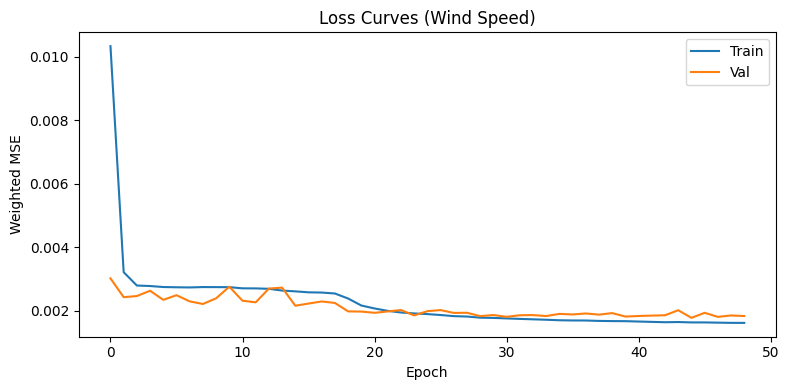

Test Loss (front-weighted MSE): 0.0011

Final Test Metrics (last step, m/s): MSE=1.37, RMSE=1.17, MAE=0.92, MAPE=15.59, R²=0.2662, Adj R²=0.2656
Final Test Metrics (full 24h path): RMSE=0.89, MAE=0.68, MAPE=11.54, R²=0.6900
Hourly-averaged RMSE by lead hour (0→23):
[0.31, 0.33, 0.42, 0.52, 0.62, 0.71, 0.77, 0.82, 0.86, 0.88, 0.89, 0.89,
 0.9 , 0.93, 0.95, 0.98, 1.  , 1.02, 1.05, 1.08, 1.11, 1.13, 1.14, 1.16]
Avg inference latency: 0.45 ms/batch • 0.45 ms/sample


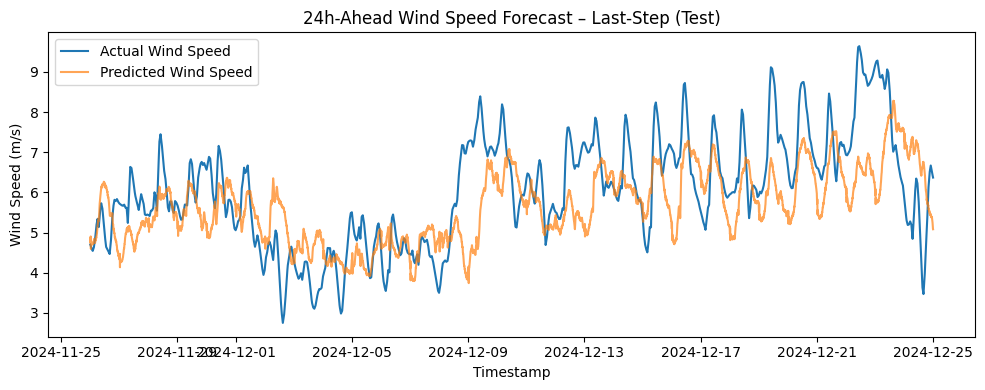

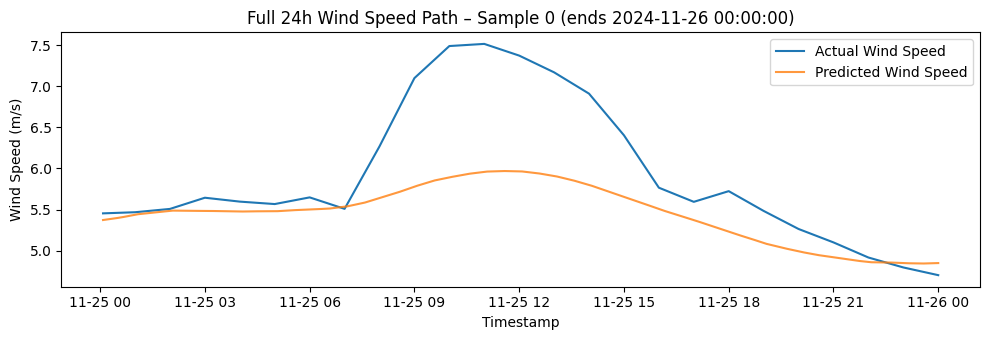

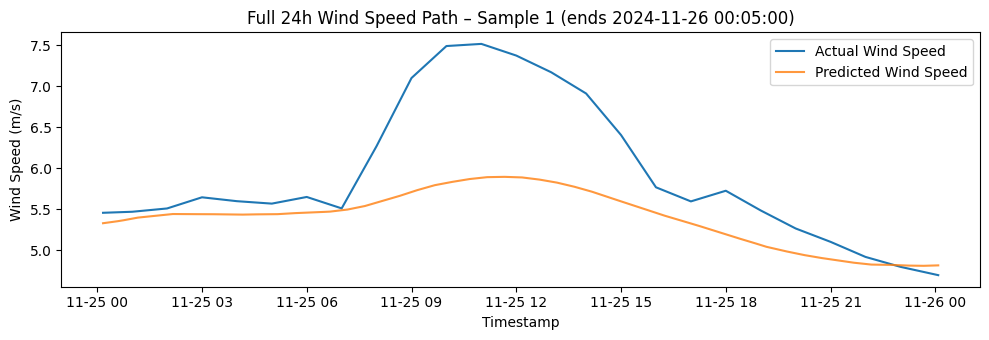

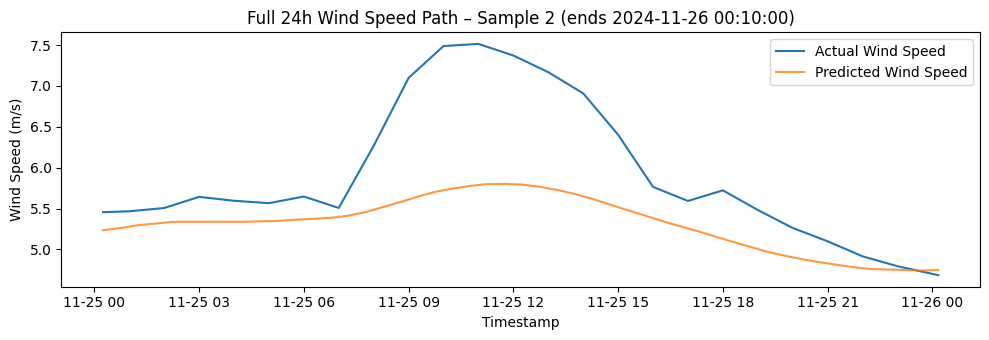

In [2]:
# T2M, QV2M, and Air Density
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time, random, math
from typing import List
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1337)

# ----------------------------
# Dataset
# ----------------------------
class LoadWindowDataset(Dataset):
    def __init__(self, data_array, window, horizon):
        self.data = data_array
        self.window, self.horizon = window, horizon
        self.n = data_array.shape[0] - window - horizon + 1
        if self.n <= 0:
            raise ValueError("Window/horizon too large for data length.")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window]                                        # [W, F]
        y_seq = self.data[idx + self.window: idx + self.window + self.horizon, -1:] # [H, 1]
        return torch.from_numpy(x).float(), torch.from_numpy(y_seq).float()

# ----------------------------
# Model
# ----------------------------
class CNN1D_Forecaster(nn.Module):
    def __init__(self, n_features, window, horizon,
                 channels=32, ksize=9, pool=2, p_drop=0.1, hidden=64):
        super().__init__()
        pad = (ksize - 1) // 2
        self.conv = nn.Conv1d(n_features, channels, kernel_size=ksize, padding=pad, bias=True)
        self.pool = nn.AvgPool1d(pool)
        self.bn   = nn.BatchNorm1d(channels)
        self.do   = nn.Dropout(p_drop)

        conv_T = window // pool
        if conv_T <= 0:
            raise ValueError("Pooling/window configuration invalid; pooled length <= 0.")
        self.flat_dim = channels * conv_T

        concat_dim = self.flat_dim + n_features
        self.head = nn.Sequential(
            nn.Linear(concat_dim, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden, horizon)
        )

    def forward(self, x):
        B, W, F = x.shape
        h = self.conv(x.permute(0, 2, 1))  # [B,C,W]
        h = self.pool(h)                   # [B,C,W/p]
        h = self.bn(h)
        h = self.do(h)
        h = h.reshape(B, -1)               # [B, C*(W/p)]
        z = torch.cat([h, x[:, -1, :]], dim=1)  # concat last-step features
        yhat = self.head(z)                     # [B,H]
        return yhat.unsqueeze(-1)               # [B,H,1]

# ----------------------------
# Early Stopping (CPU snapshot)
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=25, delta=1e-4, verbose=True):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.best_loss = np.inf
        self.wait = 0
        self.should_stop = False
        self.best_state = None

    def step(self, val_loss, model=None):
        improved = val_loss < self.best_loss - self.delta
        if improved:
            self.best_loss = val_loss
            self.wait = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: stop after {self.patience} epochs.")
        return improved

# ----------------------------
# Helpers
# ----------------------------
def infer_5min_freq(index: pd.DatetimeIndex) -> pd.Timedelta:
    freq = pd.infer_freq(index)
    if freq is None:
        diffs = pd.Series(index[1:] - index[:-1])
        step = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=5)
    else:
        step = pd.Timedelta(freq)
    if step != pd.Timedelta(minutes=5):
        print(f"[WARN] Detected step={step}. Script assumes 5-minute cadence.")
    return step

def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour + idx.minute/60.0
    hod = hour / 24.0
    dow = idx.dayofweek.astype(float) / 7.0
    doy = (idx.dayofyear.astype(float) - 1.0) / 366.0
    cal = pd.DataFrame(index=idx)
    cal["hod_sin"] = np.sin(2*np.pi*hod); cal["hod_cos"] = np.cos(2*np.pi*hod)
    cal["dow_sin"] = np.sin(2*np.pi*dow); cal["dow_cos"] = np.cos(2*np.pi*dow)
    cal["doy_sin"] = np.sin(2*np.pi*doy); cal["doy_cos"] = np.cos(2*np.pi*doy)
    return cal

def cosine_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / float(warmup_epochs)
        denom = max(float(total_epochs - warmup_epochs), 1.0)
        progress = min(max((epoch - warmup_epochs) / denom, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)
    )

# ----------------------------
# Main
# ----------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset
    df = pd.read_csv(
        'Dataset/Wind/wind_forecasting.csv',
        parse_dates=['DATETIME'],
        index_col='DATETIME'
    ).fillna(0)

    # Target column
    target_col = 'WS50M'
    df['TARGET'] = df[target_col]

    # --- Use all the features you already have ---
    # Drop target from the features so it's only in TARGET
    feature_cols = [c for c in df.columns if c not in ['TARGET', target_col]]

    X_exo = df[feature_cols].copy()

    # Handle inf/nan
    X_exo.replace([np.inf, -np.inf], np.nan, inplace=True)
    finite_rows = np.isfinite(X_exo.to_numpy()).all(axis=1)
    finite_target = np.isfinite(df['TARGET'].to_numpy())
    valid_mask = finite_rows & finite_target

    df    = df.loc[valid_mask].copy()
    X_exo = X_exo.loc[valid_mask].copy()

    # Window end timestamps
    W = 7 * 24 * 12   # lookback
    H = 1 * 24 * 12   # horizon
    times = df.index[W + H - 1 :]

    # Splits
    train_end = pd.Timestamp('2023-12-25 23:55:00')
    val_end   = pd.Timestamp('2024-11-25 23:55:00')

    # --- Scaling ---
    train_mask_for_scaler = df.index <= train_end
    feat_scaler = MinMaxScaler()
    feat_scaler.fit(X_exo.loc[train_mask_for_scaler])
    X_feats_scaled = feat_scaler.transform(X_exo)

    tgt_scaler = MinMaxScaler()
    tgt_scaler.fit(df.loc[train_mask_for_scaler, ['TARGET']])
    y_scaled = tgt_scaler.transform(df[['TARGET']])

    # Final array
    data = np.hstack([X_feats_scaled, y_scaled])
    n_features = data.shape[1]  # all features + target

    # ----------------------------
    # Indexing with optional stride (speeds up training)
    # ----------------------------
    stride = 6  # Smaller stride for wind data (changes faster)
    all_idx = np.arange(len(times))
    train_idx = all_idx[times <= train_end][::stride]
    val_idx   = all_idx[(times > train_end) & (times <= val_end)][::stride]
    test_idx  = all_idx[times > val_end]

    print(f"Train windows: {len(train_idx)}, Validation windows: {len(val_idx)}, Test windows: {len(test_idx)}")
    if len(times) > 0:
        print(f"First window ts: {times.min()}, Last: {times.max()}")
    assert len(train_idx) > 0, "No training windows found—check train_end vs. data coverage"
    assert len(val_idx) > 0, "No validation windows found—check val_end vs. data coverage"
    assert len(test_idx) > 0, "No test windows found—does your data extend past val_end?"

    # Datasets / Loaders
    full_ds = LoadWindowDataset(data, W, H)
    train_ds = Subset(full_ds, train_idx)
    val_ds   = Subset(full_ds, val_idx)
    test_ds  = Subset(full_ds, test_idx)

    pin = (device.type == 'cuda')
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)

    # ----------------------------
    # Model + optimizer + loss + scheduler
    # ----------------------------
    model = CNN1D_Forecaster(
        n_features=n_features, window=W, horizon=H,
        channels=64, ksize=9, pool=2, p_drop=0.2, hidden=128
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    es = EarlyStopping(patience=25, delta=1e-4, verbose=True)

    # Weighted loss for wind forecasting (emphasize short-term accuracy)
    weights = torch.linspace(1.5, 0.5, steps=H, device=device).view(1, H, 1)
    def weighted_mse(pred, target):
        return ((weights * (pred - target) ** 2).mean())
    f_fn = weighted_mse

    total_epochs = 100
    warmup_epochs = 20
    sched = cosine_warmup_scheduler(opt, warmup_epochs, total_epochs)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of parameters:", n_params)

    train_losses, val_losses = [], []

    # ----------------------------
    # Training Loop
    # ----------------------------
    for ep in range(1, total_epochs + 1):
        t0 = time.time()
        model.train()
        tl = 0.0
        for Xb, Yseqb in train_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            loss = f_fn(yhat, Yseqb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
        train_losses.append(tl / len(train_ds))

        # Validation
        model.eval()
        vl, preds_last_scaled, truths_last_scaled = 0.0, [], []
        preds_full_scaled, truths_full_scaled = [], []
        with torch.no_grad():
            for Xb, Yseqb in val_loader:
                Xb, Yseqb = Xb.to(device), Yseqb.to(device)
                yhat = model(Xb)
                vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
                preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
                truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
                preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
                truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
        val_loss = vl / len(val_ds)
        val_losses.append(val_loss)

        # step LR ONCE PER EPOCH
        sched.step()

        # Inverse metrics
        preds = np.concatenate(preds_last_scaled)
        truths = np.concatenate(truths_last_scaled)
        inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
        inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]
        rm  = root_mean_squared_error(inv_t, inv_p)
        mae = mean_absolute_error(inv_t, inv_p)
        r2  = r2_score(inv_t, inv_p)
        mape = smape(inv_t, inv_p)

        pf = np.concatenate(preds_full_scaled, axis=0)
        tf = np.concatenate(truths_full_scaled, axis=0)
        inv_pf = tgt_scaler.inverse_transform(pf.reshape(-1,1))[:,0]
        inv_tf = tgt_scaler.inverse_transform(tf.reshape(-1,1))[:,0]
        rm_all  = root_mean_squared_error(inv_tf, inv_pf)
        mae_all = mean_absolute_error(inv_tf, inv_pf)
        r2_all  = r2_score(inv_tf, inv_pf)
        mape_all = smape(inv_tf, inv_pf)

        cur_lr = opt.param_groups[0]['lr']
        print(f"Ep{ep:02d} Train={train_losses[-1]:.4f} | Val={val_loss:.4f} | "
              f"Val(last) RMSE={rm:.1f} MAE={mae:.1f} MAPE={mape:.2f}% R²={r2:.3f} | "
              f"Val(full) RMSE={rm_all:.1f} MAE={mae_all:.1f} MAPE={mape_all:.2f}% R²={r2_all:.3f} | "
              f"LR={cur_lr:.6f} | Time={time.time()-t0:.1f}s")

        _ = es.step(val_loss, model=model)
        if es.should_stop:
            if es.best_state is not None:
                model.load_state_dict(es.best_state)
                if es.verbose:
                    print("EarlyStopping: best weights restored.")
            break

    # ----------------------------
    # Loss curves
    # ----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Weighted MSE'); plt.legend(); plt.title('Loss Curves (Wind Speed)')
    plt.tight_layout(); plt.show()

    # ----------------------------
    # Testing
    # ----------------------------
    model.eval()
    preds_last_scaled, truths_last_scaled = [], []
    preds_full_scaled, truths_full_scaled = [], []
    test_vl = 0.0
    with torch.no_grad():
        for Xb, Yseqb in test_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            test_vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
            preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
            truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
            preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
            truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
    test_loss = test_vl / len(test_ds)

    preds = np.concatenate(preds_last_scaled)
    truths = np.concatenate(truths_last_scaled)
    inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
    inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]

    mse = mean_squared_error(inv_t, inv_p)
    rm  = root_mean_squared_error(inv_t, inv_p)
    mae = mean_absolute_error(inv_t, inv_p)
    mape = smape(inv_t, inv_p)
    r2  = r2_score(inv_t, inv_p)
    n, p = len(inv_t), (n_features - 1)
    adj_r2 = 1 - (1-r2)*(n-1)/max(n-p-1, 1)

    PH = np.concatenate(preds_full_scaled, axis=0)
    TH = np.concatenate(truths_full_scaled, axis=0)
    inv_pf = tgt_scaler.inverse_transform(PH.reshape(-1,1))[:,0]
    inv_tf = tgt_scaler.inverse_transform(TH.reshape(-1,1))[:,0]
    rm_all  = root_mean_squared_error(inv_tf, inv_pf)
    mae_all = mean_absolute_error(inv_tf, inv_pf)
    mape_all = smape(inv_tf, inv_pf)

    # Per-lead RMSE (hourly average over 24h)
    lead_rmse = []
    for h in range(PH.shape[1]):
        inv_ph = tgt_scaler.inverse_transform(PH[:, h].reshape(-1,1))[:,0]
        inv_th = tgt_scaler.inverse_transform(TH[:, h].reshape(-1,1))[:,0]
        lead_rmse.append(root_mean_squared_error(inv_th, inv_ph))
    hourly_rmse = np.array(lead_rmse).reshape(-1, 12).mean(axis=1)

    print(f"Test Loss (front-weighted MSE): {test_loss:.4f}")
    print(f"\nFinal Test Metrics (last step, m/s): "
          f"MSE={mse:.2f}, RMSE={rm:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}")
    print(f"Final Test Metrics (full 24h path): RMSE={rm_all:.2f}, MAE={mae_all:.2f}, MAPE={mape_all:.2f}, R²={r2_all:.4f}")
    print("Hourly-averaged RMSE by lead hour (0→23):")
    print(np.array2string(hourly_rmse, precision=2, separator=', '))

    # Inference latency (batch=1)
    _ = model(torch.randn(1, W, n_features).to(device))
    if device.type == 'cuda':
        torch.cuda.synchronize()
    Nruns = 100
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    total_time = 0.0
    with torch.no_grad():
        for _ in range(Nruns):
            inp = torch.randn(1, W, n_features).to(device)
            start.record(); _ = model(inp); end.record()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            total_time += start.elapsed_time(end) / 1000.0
    avg_batch = total_time / Nruns
    print(f"Avg inference latency: {avg_batch*1000:.2f} ms/batch • {avg_batch*1000:.2f} ms/sample")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(times[test_idx], inv_t, label='Actual Wind Speed')
    plt.plot(times[test_idx], inv_p, label='Predicted Wind Speed', alpha=0.7)
    plt.title("24h-Ahead Wind Speed Forecast – Last-Step (Test)")
    plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Show sample forecasts
    num_show = min(3, len(test_idx))
    if num_show > 0:
        Xb, Yseqb = next(iter(DataLoader(test_ds, batch_size=num_show, shuffle=False)))
        Xb = Xb.to(device)
        with torch.no_grad():
            yhat = model(Xb).cpu().numpy()
        ytrue = Yseqb.numpy()
        for i in range(min(num_show, Xb.size(0))):
            pred_i = tgt_scaler.inverse_transform(yhat[i, :, 0].reshape(-1,1))[:,0]
            true_i = tgt_scaler.inverse_transform(ytrue[i, :, 0].reshape(-1,1))[:,0]
            end_ts = times[test_idx[i]]
            tgrid = pd.date_range(end=end_ts, periods=H, freq='5min')
            plt.figure(figsize=(10,3.5))
            plt.plot(tgrid, true_i, label='Actual Wind Speed')
            plt.plot(tgrid, pred_i, label='Predicted Wind Speed', alpha=0.8)
            plt.title(f"Full 24h Wind Speed Path – Sample {i} (ends {end_ts})")
            plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
            plt.legend(); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()

Train windows: 174913, Validation windows: 16128, Test windows: 8352
First window ts: 2014-01-02 23:55:00, Last: 2024-12-24 23:55:00
No. of parameters: 8303456
Ep01 Train=0.0104 | Val=0.0033 | Val(last) RMSE=1.6 MAE=1.2 MAPE=29.39% R²=0.377 | Val(full) RMSE=1.5 MAE=1.1 MAPE=27.64% R²=0.477 | LR=0.000050 | Time=38.1s
Ep02 Train=0.0031 | Val=0.0023 | Val(last) RMSE=1.5 MAE=1.1 MAPE=27.34% R²=0.459 | Val(full) RMSE=1.2 MAE=0.9 MAPE=23.03% R²=0.634 | LR=0.000075 | Time=35.2s
Ep03 Train=0.0026 | Val=0.0023 | Val(last) RMSE=1.5 MAE=1.1 MAPE=27.68% R²=0.468 | Val(full) RMSE=1.2 MAE=0.9 MAPE=23.57% R²=0.624 | LR=0.000100 | Time=32.8s
Ep04 Train=0.0026 | Val=0.0024 | Val(last) RMSE=1.5 MAE=1.2 MAPE=28.00% R²=0.447 | Val(full) RMSE=1.3 MAE=1.0 MAPE=23.78% R²=0.614 | LR=0.000125 | Time=32.3s
Ep05 Train=0.0026 | Val=0.0025 | Val(last) RMSE=1.5 MAE=1.2 MAPE=28.66% R²=0.416 | Val(full) RMSE=1.3 MAE=1.0 MAPE=23.82% R²=0.606 | LR=0.000150 | Time=35.4s
Ep06 Train=0.0026 | Val=0.0023 | Val(last) RMSE=1.

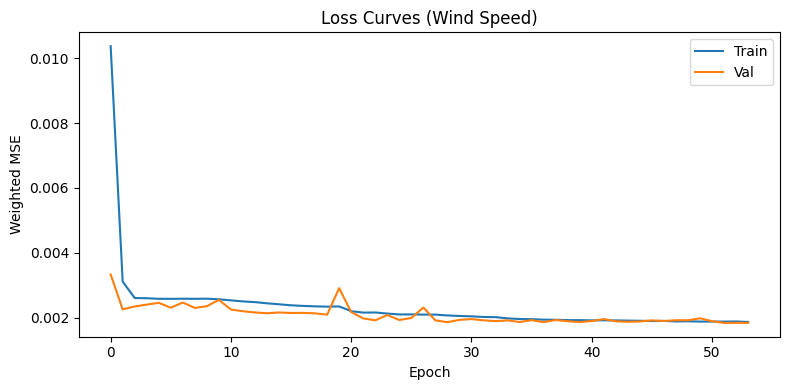

Test Loss (front-weighted MSE): 0.0013

Final Test Metrics (last step, m/s): MSE=1.38, RMSE=1.17, MAE=0.91, MAPE=15.37, R²=0.2609, Adj R²=0.2600
Final Test Metrics (full 24h path): RMSE=0.94, MAE=0.71, MAPE=12.04, R²=0.6888
Hourly-averaged RMSE by lead hour (0→23):
[0.28, 0.3 , 0.43, 0.55, 0.66, 0.74, 0.8 , 0.85, 0.88, 0.91, 0.93, 0.94,
 0.96, 0.98, 1.01, 1.05, 1.08, 1.11, 1.13, 1.16, 1.18, 1.2 , 1.2 , 1.18]
Avg inference latency: 0.51 ms/batch • 0.51 ms/sample


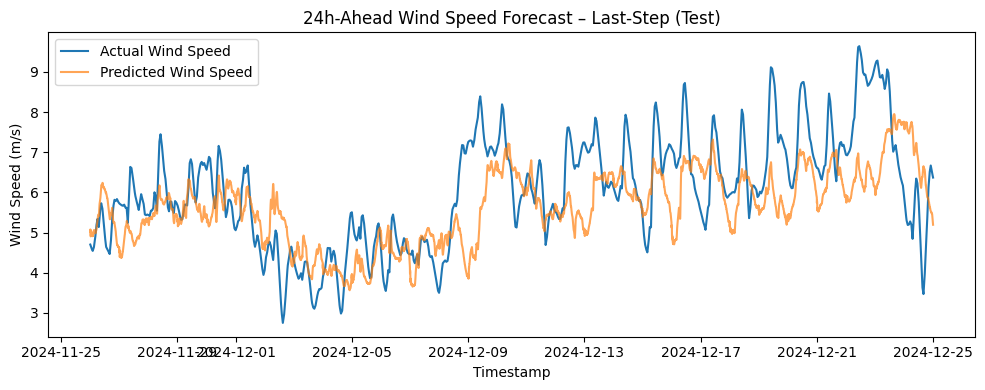

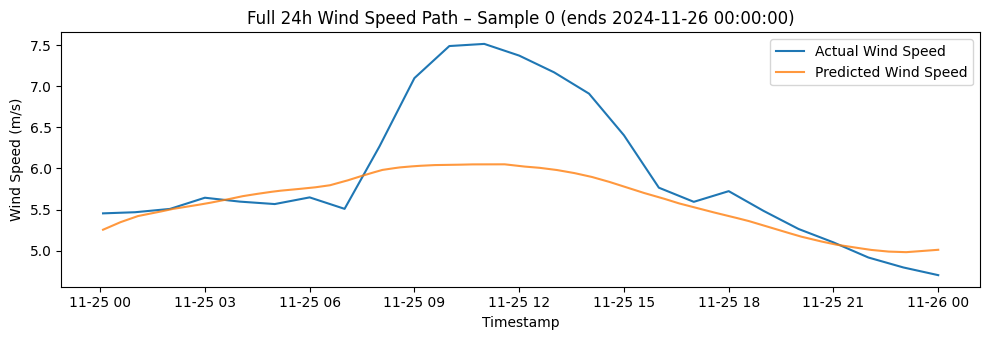

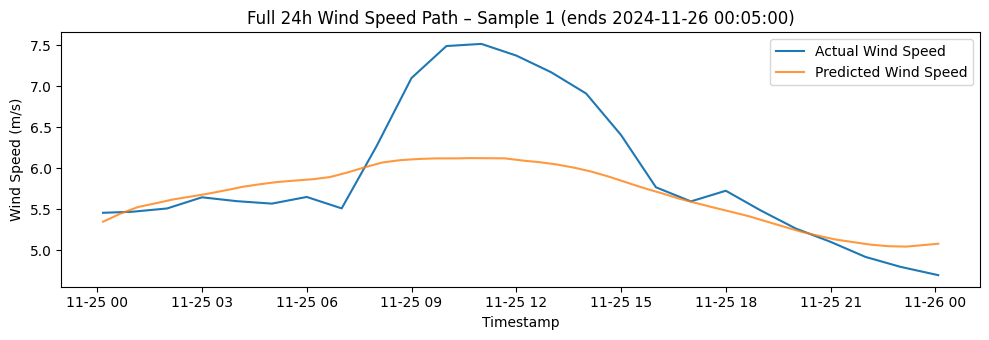

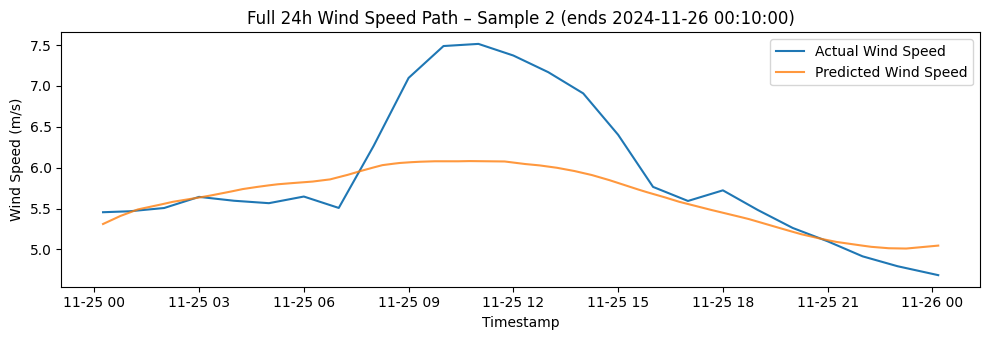

In [3]:
# Marked the days that experienced spikes during typhoons manaually
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time, random, math
from typing import List
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1337)

# ----------------------------
# Dataset
# ----------------------------
class LoadWindowDataset(Dataset):
    def __init__(self, data_array, window, horizon):
        self.data = data_array
        self.window, self.horizon = window, horizon
        self.n = data_array.shape[0] - window - horizon + 1
        if self.n <= 0:
            raise ValueError("Window/horizon too large for data length.")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window]                                        # [W, F]
        y_seq = self.data[idx + self.window: idx + self.window + self.horizon, -1:] # [H, 1]
        return torch.from_numpy(x).float(), torch.from_numpy(y_seq).float()

# ----------------------------
# Model
# ----------------------------
class CNN1D_Forecaster(nn.Module):
    def __init__(self, n_features, window, horizon,
                 channels=32, ksize=9, pool=2, p_drop=0.1, hidden=64):
        super().__init__()
        pad = (ksize - 1) // 2
        self.conv = nn.Conv1d(n_features, channels, kernel_size=ksize, padding=pad, bias=True)
        self.pool = nn.AvgPool1d(pool)
        self.bn   = nn.BatchNorm1d(channels)
        self.do   = nn.Dropout(p_drop)

        conv_T = window // pool
        if conv_T <= 0:
            raise ValueError("Pooling/window configuration invalid; pooled length <= 0.")
        self.flat_dim = channels * conv_T

        concat_dim = self.flat_dim + n_features
        self.head = nn.Sequential(
            nn.Linear(concat_dim, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden, horizon)
        )

    def forward(self, x):
        B, W, F = x.shape
        h = self.conv(x.permute(0, 2, 1))  # [B,C,W]
        h = self.pool(h)                   # [B,C,W/p]
        h = self.bn(h)
        h = self.do(h)
        h = h.reshape(B, -1)               # [B, C*(W/p)]
        z = torch.cat([h, x[:, -1, :]], dim=1)  # concat last-step features
        yhat = self.head(z)                     # [B,H]
        return yhat.unsqueeze(-1)               # [B,H,1]

# ----------------------------
# Early Stopping (CPU snapshot)
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=25, delta=1e-4, verbose=True):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.best_loss = np.inf
        self.wait = 0
        self.should_stop = False
        self.best_state = None

    def step(self, val_loss, model=None):
        improved = val_loss < self.best_loss - self.delta
        if improved:
            self.best_loss = val_loss
            self.wait = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: stop after {self.patience} epochs.")
        return improved

# ----------------------------
# Helpers
# ----------------------------
def infer_5min_freq(index: pd.DatetimeIndex) -> pd.Timedelta:
    freq = pd.infer_freq(index)
    if freq is None:
        diffs = pd.Series(index[1:] - index[:-1])
        step = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=5)
    else:
        step = pd.Timedelta(freq)
    if step != pd.Timedelta(minutes=5):
        print(f"[WARN] Detected step={step}. Script assumes 5-minute cadence.")
    return step

def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour + idx.minute/60.0
    hod = hour / 24.0
    dow = idx.dayofweek.astype(float) / 7.0
    doy = (idx.dayofyear.astype(float) - 1.0) / 366.0
    cal = pd.DataFrame(index=idx)
    cal["hod_sin"] = np.sin(2*np.pi*hod); cal["hod_cos"] = np.cos(2*np.pi*hod)
    cal["dow_sin"] = np.sin(2*np.pi*dow); cal["dow_cos"] = np.cos(2*np.pi*dow)
    cal["doy_sin"] = np.sin(2*np.pi*doy); cal["doy_cos"] = np.cos(2*np.pi*doy)
    return cal

def cosine_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / float(warmup_epochs)
        denom = max(float(total_epochs - warmup_epochs), 1.0)
        progress = min(max((epoch - warmup_epochs) / denom, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)
    )

# ----------------------------
# Main
# ----------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset
    df = pd.read_csv(
        'Dataset/Wind/wind_forecasting_final_withTyphoon.csv',
        parse_dates=['DATETIME'],
        index_col='DATETIME'
    ).fillna(0)

    # Target column
    target_col = 'WS50M'
    df['TARGET'] = df[target_col]

    # --- Use all the features you already have ---
    # Drop target from the features so it's only in TARGET
    feature_cols = [c for c in df.columns if c not in ['TARGET', target_col]]

    X_exo = df[feature_cols].copy()

    # Handle inf/nan
    X_exo.replace([np.inf, -np.inf], np.nan, inplace=True)
    finite_rows = np.isfinite(X_exo.to_numpy()).all(axis=1)
    finite_target = np.isfinite(df['TARGET'].to_numpy())
    valid_mask = finite_rows & finite_target

    df    = df.loc[valid_mask].copy()
    X_exo = X_exo.loc[valid_mask].copy()

    # Window end timestamps
    W = 7 * 24 * 12   # lookback
    H = 1 * 24 * 12   # horizon
    times = df.index[W + H - 1 :]

    # Splits
    train_end = pd.Timestamp('2023-12-25 23:55:00')
    val_end   = pd.Timestamp('2024-11-25 23:55:00')

    # --- Scaling ---
    train_mask_for_scaler = df.index <= train_end
    feat_scaler = MinMaxScaler()
    feat_scaler.fit(X_exo.loc[train_mask_for_scaler])
    X_feats_scaled = feat_scaler.transform(X_exo)

    tgt_scaler = MinMaxScaler()
    tgt_scaler.fit(df.loc[train_mask_for_scaler, ['TARGET']])
    y_scaled = tgt_scaler.transform(df[['TARGET']])

    # Final array
    data = np.hstack([X_feats_scaled, y_scaled])
    n_features = data.shape[1]  # all features + target

    # ----------------------------
    # Indexing with optional stride (speeds up training)
    # ----------------------------
    stride = 6  # Smaller stride for wind data (changes faster)
    all_idx = np.arange(len(times))
    train_idx = all_idx[times <= train_end][::stride]
    val_idx   = all_idx[(times > train_end) & (times <= val_end)][::stride]
    test_idx  = all_idx[times > val_end]

    print(f"Train windows: {len(train_idx)}, Validation windows: {len(val_idx)}, Test windows: {len(test_idx)}")
    if len(times) > 0:
        print(f"First window ts: {times.min()}, Last: {times.max()}")
    assert len(train_idx) > 0, "No training windows found—check train_end vs. data coverage"
    assert len(val_idx) > 0, "No validation windows found—check val_end vs. data coverage"
    assert len(test_idx) > 0, "No test windows found—does your data extend past val_end?"

    # Datasets / Loaders
    full_ds = LoadWindowDataset(data, W, H)
    train_ds = Subset(full_ds, train_idx)
    val_ds   = Subset(full_ds, val_idx)
    test_ds  = Subset(full_ds, test_idx)

    pin = (device.type == 'cuda')
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)

    # ----------------------------
    # Model + optimizer + loss + scheduler
    # ----------------------------
    model = CNN1D_Forecaster(
        n_features=n_features, window=W, horizon=H,
        channels=64, ksize=9, pool=2, p_drop=0.2, hidden=128
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    es = EarlyStopping(patience=25, delta=1e-4, verbose=True)

    # Weighted loss for wind forecasting (emphasize short-term accuracy)
    weights = torch.linspace(1.5, 0.5, steps=H, device=device).view(1, H, 1)
    def weighted_mse(pred, target):
        return ((weights * (pred - target) ** 2).mean())
    f_fn = weighted_mse

    total_epochs = 100
    warmup_epochs = 20
    sched = cosine_warmup_scheduler(opt, warmup_epochs, total_epochs)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of parameters:", n_params)

    train_losses, val_losses = [], []

    # ----------------------------
    # Training Loop
    # ----------------------------
    for ep in range(1, total_epochs + 1):
        t0 = time.time()
        model.train()
        tl = 0.0
        for Xb, Yseqb in train_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            loss = f_fn(yhat, Yseqb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
        train_losses.append(tl / len(train_ds))

        # Validation
        model.eval()
        vl, preds_last_scaled, truths_last_scaled = 0.0, [], []
        preds_full_scaled, truths_full_scaled = [], []
        with torch.no_grad():
            for Xb, Yseqb in val_loader:
                Xb, Yseqb = Xb.to(device), Yseqb.to(device)
                yhat = model(Xb)
                vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
                preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
                truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
                preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
                truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
        val_loss = vl / len(val_ds)
        val_losses.append(val_loss)

        # step LR ONCE PER EPOCH
        sched.step()

        # Inverse metrics
        preds = np.concatenate(preds_last_scaled)
        truths = np.concatenate(truths_last_scaled)
        inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
        inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]
        rm  = root_mean_squared_error(inv_t, inv_p)
        mae = mean_absolute_error(inv_t, inv_p)
        r2  = r2_score(inv_t, inv_p)
        mape = smape(inv_t, inv_p)

        pf = np.concatenate(preds_full_scaled, axis=0)
        tf = np.concatenate(truths_full_scaled, axis=0)
        inv_pf = tgt_scaler.inverse_transform(pf.reshape(-1,1))[:,0]
        inv_tf = tgt_scaler.inverse_transform(tf.reshape(-1,1))[:,0]
        rm_all  = root_mean_squared_error(inv_tf, inv_pf)
        mae_all = mean_absolute_error(inv_tf, inv_pf)
        r2_all  = r2_score(inv_tf, inv_pf)
        mape_all = smape(inv_tf, inv_pf)

        cur_lr = opt.param_groups[0]['lr']
        print(f"Ep{ep:02d} Train={train_losses[-1]:.4f} | Val={val_loss:.4f} | "
              f"Val(last) RMSE={rm:.1f} MAE={mae:.1f} MAPE={mape:.2f}% R²={r2:.3f} | "
              f"Val(full) RMSE={rm_all:.1f} MAE={mae_all:.1f} MAPE={mape_all:.2f}% R²={r2_all:.3f} | "
              f"LR={cur_lr:.6f} | Time={time.time()-t0:.1f}s")

        _ = es.step(val_loss, model=model)
        if es.should_stop:
            if es.best_state is not None:
                model.load_state_dict(es.best_state)
                if es.verbose:
                    print("EarlyStopping: best weights restored.")
            break

    # ----------------------------
    # Loss curves
    # ----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Weighted MSE'); plt.legend(); plt.title('Loss Curves (Wind Speed)')
    plt.tight_layout(); plt.show()

    # ----------------------------
    # Testing
    # ----------------------------
    model.eval()
    preds_last_scaled, truths_last_scaled = [], []
    preds_full_scaled, truths_full_scaled = [], []
    test_vl = 0.0
    with torch.no_grad():
        for Xb, Yseqb in test_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            test_vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
            preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
            truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
            preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
            truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
    test_loss = test_vl / len(test_ds)

    preds = np.concatenate(preds_last_scaled)
    truths = np.concatenate(truths_last_scaled)
    inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
    inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]

    mse = mean_squared_error(inv_t, inv_p)
    rm  = root_mean_squared_error(inv_t, inv_p)
    mae = mean_absolute_error(inv_t, inv_p)
    mape = smape(inv_t, inv_p)
    r2  = r2_score(inv_t, inv_p)
    n, p = len(inv_t), (n_features - 1)
    adj_r2 = 1 - (1-r2)*(n-1)/max(n-p-1, 1)

    PH = np.concatenate(preds_full_scaled, axis=0)
    TH = np.concatenate(truths_full_scaled, axis=0)
    inv_pf = tgt_scaler.inverse_transform(PH.reshape(-1,1))[:,0]
    inv_tf = tgt_scaler.inverse_transform(TH.reshape(-1,1))[:,0]
    rm_all  = root_mean_squared_error(inv_tf, inv_pf)
    mae_all = mean_absolute_error(inv_tf, inv_pf)
    mape_all = smape(inv_tf, inv_pf)

    # Per-lead RMSE (hourly average over 24h)
    lead_rmse = []
    for h in range(PH.shape[1]):
        inv_ph = tgt_scaler.inverse_transform(PH[:, h].reshape(-1,1))[:,0]
        inv_th = tgt_scaler.inverse_transform(TH[:, h].reshape(-1,1))[:,0]
        lead_rmse.append(root_mean_squared_error(inv_th, inv_ph))
    hourly_rmse = np.array(lead_rmse).reshape(-1, 12).mean(axis=1)

    print(f"Test Loss (front-weighted MSE): {test_loss:.4f}")
    print(f"\nFinal Test Metrics (last step, m/s): "
          f"MSE={mse:.2f}, RMSE={rm:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}")
    print(f"Final Test Metrics (full 24h path): RMSE={rm_all:.2f}, MAE={mae_all:.2f}, MAPE={mape_all:.2f}, R²={r2_all:.4f}")
    print("Hourly-averaged RMSE by lead hour (0→23):")
    print(np.array2string(hourly_rmse, precision=2, separator=', '))

    # Inference latency (batch=1)
    _ = model(torch.randn(1, W, n_features).to(device))
    if device.type == 'cuda':
        torch.cuda.synchronize()
    Nruns = 100
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    total_time = 0.0
    with torch.no_grad():
        for _ in range(Nruns):
            inp = torch.randn(1, W, n_features).to(device)
            start.record(); _ = model(inp); end.record()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            total_time += start.elapsed_time(end) / 1000.0
    avg_batch = total_time / Nruns
    print(f"Avg inference latency: {avg_batch*1000:.2f} ms/batch • {avg_batch*1000:.2f} ms/sample")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(times[test_idx], inv_t, label='Actual Wind Speed')
    plt.plot(times[test_idx], inv_p, label='Predicted Wind Speed', alpha=0.7)
    plt.title("24h-Ahead Wind Speed Forecast – Last-Step (Test)")
    plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Show sample forecasts
    num_show = min(3, len(test_idx))
    if num_show > 0:
        Xb, Yseqb = next(iter(DataLoader(test_ds, batch_size=num_show, shuffle=False)))
        Xb = Xb.to(device)
        with torch.no_grad():
            yhat = model(Xb).cpu().numpy()
        ytrue = Yseqb.numpy()
        for i in range(min(num_show, Xb.size(0))):
            pred_i = tgt_scaler.inverse_transform(yhat[i, :, 0].reshape(-1,1))[:,0]
            true_i = tgt_scaler.inverse_transform(ytrue[i, :, 0].reshape(-1,1))[:,0]
            end_ts = times[test_idx[i]]
            tgrid = pd.date_range(end=end_ts, periods=H, freq='5min')
            plt.figure(figsize=(10,3.5))
            plt.plot(tgrid, true_i, label='Actual Wind Speed')
            plt.plot(tgrid, pred_i, label='Predicted Wind Speed', alpha=0.8)
            plt.title(f"Full 24h Wind Speed Path – Sample {i} (ends {end_ts})")
            plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
            plt.legend(); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()

In [ ]:
# Marked the days that experienced spikes during typhoons using IQR rule
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time, random, math
from typing import List
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1337)

# ----------------------------
# Dataset
# ----------------------------
class LoadWindowDataset(Dataset):
    def __init__(self, data_array, window, horizon):
        self.data = data_array
        self.window, self.horizon = window, horizon
        self.n = data_array.shape[0] - window - horizon + 1
        if self.n <= 0:
            raise ValueError("Window/horizon too large for data length.")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window]                                        # [W, F]
        y_seq = self.data[idx + self.window: idx + self.window + self.horizon, -1:] # [H, 1]
        return torch.from_numpy(x).float(), torch.from_numpy(y_seq).float()

# ----------------------------
# Model
# ----------------------------
class CNN1D_Forecaster(nn.Module):
    def __init__(self, n_features, window, horizon,
                 channels=32, ksize=9, pool=2, p_drop=0.1, hidden=64):
        super().__init__()
        pad = (ksize - 1) // 2
        self.conv = nn.Conv1d(n_features, channels, kernel_size=ksize, padding=pad, bias=True)
        self.pool = nn.AvgPool1d(pool)
        self.bn   = nn.BatchNorm1d(channels)
        self.do   = nn.Dropout(p_drop)

        conv_T = window // pool
        if conv_T <= 0:
            raise ValueError("Pooling/window configuration invalid; pooled length <= 0.")
        self.flat_dim = channels * conv_T

        concat_dim = self.flat_dim + n_features
        self.head = nn.Sequential(
            nn.Linear(concat_dim, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden, horizon)
        )

    def forward(self, x):
        B, W, F = x.shape
        h = self.conv(x.permute(0, 2, 1))  # [B,C,W]
        h = self.pool(h)                   # [B,C,W/p]
        h = self.bn(h)
        h = self.do(h)
        h = h.reshape(B, -1)               # [B, C*(W/p)]
        z = torch.cat([h, x[:, -1, :]], dim=1)  # concat last-step features
        yhat = self.head(z)                     # [B,H]
        return yhat.unsqueeze(-1)               # [B,H,1]

# ----------------------------
# Early Stopping (CPU snapshot)
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=25, delta=1e-4, verbose=True):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.best_loss = np.inf
        self.wait = 0
        self.should_stop = False
        self.best_state = None

    def step(self, val_loss, model=None):
        improved = val_loss < self.best_loss - self.delta
        if improved:
            self.best_loss = val_loss
            self.wait = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: stop after {self.patience} epochs.")
        return improved

# ----------------------------
# Helpers
# ----------------------------
def infer_5min_freq(index: pd.DatetimeIndex) -> pd.Timedelta:
    freq = pd.infer_freq(index)
    if freq is None:
        diffs = pd.Series(index[1:] - index[:-1])
        step = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=5)
    else:
        step = pd.Timedelta(freq)
    if step != pd.Timedelta(minutes=5):
        print(f"[WARN] Detected step={step}. Script assumes 5-minute cadence.")
    return step

def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour + idx.minute/60.0
    hod = hour / 24.0
    dow = idx.dayofweek.astype(float) / 7.0
    doy = (idx.dayofyear.astype(float) - 1.0) / 366.0
    cal = pd.DataFrame(index=idx)
    cal["hod_sin"] = np.sin(2*np.pi*hod); cal["hod_cos"] = np.cos(2*np.pi*hod)
    cal["dow_sin"] = np.sin(2*np.pi*dow); cal["dow_cos"] = np.cos(2*np.pi*dow)
    cal["doy_sin"] = np.sin(2*np.pi*doy); cal["doy_cos"] = np.cos(2*np.pi*doy)
    return cal

def cosine_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / float(warmup_epochs)
        denom = max(float(total_epochs - warmup_epochs), 1.0)
        progress = min(max((epoch - warmup_epochs) / denom, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)
    )

# ----------------------------
# Main
# ----------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset
    df = pd.read_csv(
        'Dataset/Wind/wind_forecasting_final_IQRrule_based.csv',
        parse_dates=['DATETIME'],
        index_col='DATETIME'
    ).fillna(0)

    # Target column
    target_col = 'WS50M'
    df['TARGET'] = df[target_col]

    # --- Use all the features you already have ---
    # Drop target from the features so it's only in TARGET
    feature_cols = [c for c in df.columns if c not in ['TARGET', target_col]]

    X_exo = df[feature_cols].copy()

    # Handle inf/nan
    X_exo.replace([np.inf, -np.inf], np.nan, inplace=True)
    finite_rows = np.isfinite(X_exo.to_numpy()).all(axis=1)
    finite_target = np.isfinite(df['TARGET'].to_numpy())
    valid_mask = finite_rows & finite_target

    df    = df.loc[valid_mask].copy()
    X_exo = X_exo.loc[valid_mask].copy()

    # Window end timestamps
    W = 7 * 24 * 12   # lookback
    H = 1 * 24 * 12   # horizon
    times = df.index[W + H - 1 :]

    # Splits
    train_end = pd.Timestamp('2023-12-25 23:55:00')
    val_end   = pd.Timestamp('2024-11-25 23:55:00')

    # --- Scaling ---
    train_mask_for_scaler = df.index <= train_end
    feat_scaler = MinMaxScaler()
    feat_scaler.fit(X_exo.loc[train_mask_for_scaler])
    X_feats_scaled = feat_scaler.transform(X_exo)

    tgt_scaler = MinMaxScaler()
    tgt_scaler.fit(df.loc[train_mask_for_scaler, ['TARGET']])
    y_scaled = tgt_scaler.transform(df[['TARGET']])

    # Final array
    data = np.hstack([X_feats_scaled, y_scaled])
    n_features = data.shape[1]  # all features + target

    # ----------------------------
    # Indexing with optional stride (speeds up training)
    # ----------------------------
    stride = 6  # Smaller stride for wind data (changes faster)
    all_idx = np.arange(len(times))
    train_idx = all_idx[times <= train_end][::stride]
    val_idx   = all_idx[(times > train_end) & (times <= val_end)][::stride]
    test_idx  = all_idx[times > val_end]

    print(f"Train windows: {len(train_idx)}, Validation windows: {len(val_idx)}, Test windows: {len(test_idx)}")
    if len(times) > 0:
        print(f"First window ts: {times.min()}, Last: {times.max()}")
    assert len(train_idx) > 0, "No training windows found—check train_end vs. data coverage"
    assert len(val_idx) > 0, "No validation windows found—check val_end vs. data coverage"
    assert len(test_idx) > 0, "No test windows found—does your data extend past val_end?"

    # Datasets / Loaders
    full_ds = LoadWindowDataset(data, W, H)
    train_ds = Subset(full_ds, train_idx)
    val_ds   = Subset(full_ds, val_idx)
    test_ds  = Subset(full_ds, test_idx)

    pin = (device.type == 'cuda')
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)

    # ----------------------------
    # Model + optimizer + loss + scheduler
    # ----------------------------
    model = CNN1D_Forecaster(
        n_features=n_features, window=W, horizon=H,
        channels=64, ksize=9, pool=2, p_drop=0.2, hidden=128
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    es = EarlyStopping(patience=25, delta=1e-4, verbose=True)

    # Weighted loss for wind forecasting (emphasize short-term accuracy)
    weights = torch.linspace(1.5, 0.5, steps=H, device=device).view(1, H, 1)
    def weighted_mse(pred, target):
        return ((weights * (pred - target) ** 2).mean())
    f_fn = weighted_mse

    total_epochs = 100
    warmup_epochs = 20
    sched = cosine_warmup_scheduler(opt, warmup_epochs, total_epochs)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of parameters:", n_params)

    train_losses, val_losses = [], []

    # ----------------------------
    # Training Loop
    # ----------------------------
    for ep in range(1, total_epochs + 1):
        t0 = time.time()
        model.train()
        tl = 0.0
        for Xb, Yseqb in train_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            loss = f_fn(yhat, Yseqb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
        train_losses.append(tl / len(train_ds))

        # Validation
        model.eval()
        vl, preds_last_scaled, truths_last_scaled = 0.0, [], []
        preds_full_scaled, truths_full_scaled = [], []
        with torch.no_grad():
            for Xb, Yseqb in val_loader:
                Xb, Yseqb = Xb.to(device), Yseqb.to(device)
                yhat = model(Xb)
                vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
                preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
                truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
                preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
                truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
        val_loss = vl / len(val_ds)
        val_losses.append(val_loss)

        # step LR ONCE PER EPOCH
        sched.step()

        # Inverse metrics
        preds = np.concatenate(preds_last_scaled)
        truths = np.concatenate(truths_last_scaled)
        inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
        inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]
        rm  = root_mean_squared_error(inv_t, inv_p)
        mae = mean_absolute_error(inv_t, inv_p)
        r2  = r2_score(inv_t, inv_p)
        mape = smape(inv_t, inv_p)

        pf = np.concatenate(preds_full_scaled, axis=0)
        tf = np.concatenate(truths_full_scaled, axis=0)
        inv_pf = tgt_scaler.inverse_transform(pf.reshape(-1,1))[:,0]
        inv_tf = tgt_scaler.inverse_transform(tf.reshape(-1,1))[:,0]
        rm_all  = root_mean_squared_error(inv_tf, inv_pf)
        mae_all = mean_absolute_error(inv_tf, inv_pf)
        r2_all  = r2_score(inv_tf, inv_pf)
        mape_all = smape(inv_tf, inv_pf)

        cur_lr = opt.param_groups[0]['lr']
        print(f"Ep{ep:02d} Train={train_losses[-1]:.4f} | Val={val_loss:.4f} | "
              f"Val(last) RMSE={rm:.1f} MAE={mae:.1f} MAPE={mape:.2f}% R²={r2:.3f} | "
              f"Val(full) RMSE={rm_all:.1f} MAE={mae_all:.1f} MAPE={mape_all:.2f}% R²={r2_all:.3f} | "
              f"LR={cur_lr:.6f} | Time={time.time()-t0:.1f}s")

        _ = es.step(val_loss, model=model)
        if es.should_stop:
            if es.best_state is not None:
                model.load_state_dict(es.best_state)
                if es.verbose:
                    print("EarlyStopping: best weights restored.")
            break

    # ----------------------------
    # Loss curves
    # ----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Weighted MSE'); plt.legend(); plt.title('Loss Curves (Wind Speed)')
    plt.tight_layout(); plt.show()

    # ----------------------------
    # Testing
    # ----------------------------
    model.eval()
    preds_last_scaled, truths_last_scaled = [], []
    preds_full_scaled, truths_full_scaled = [], []
    test_vl = 0.0
    with torch.no_grad():
        for Xb, Yseqb in test_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            test_vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
            preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
            truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
            preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
            truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
    test_loss = test_vl / len(test_ds)

    preds = np.concatenate(preds_last_scaled)
    truths = np.concatenate(truths_last_scaled)
    inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
    inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]

    mse = mean_squared_error(inv_t, inv_p)
    rm  = root_mean_squared_error(inv_t, inv_p)
    mae = mean_absolute_error(inv_t, inv_p)
    mape = smape(inv_t, inv_p)
    r2  = r2_score(inv_t, inv_p)
    n, p = len(inv_t), (n_features - 1)
    adj_r2 = 1 - (1-r2)*(n-1)/max(n-p-1, 1)

    PH = np.concatenate(preds_full_scaled, axis=0)
    TH = np.concatenate(truths_full_scaled, axis=0)
    inv_pf = tgt_scaler.inverse_transform(PH.reshape(-1,1))[:,0]
    inv_tf = tgt_scaler.inverse_transform(TH.reshape(-1,1))[:,0]
    rm_all  = root_mean_squared_error(inv_tf, inv_pf)
    mae_all = mean_absolute_error(inv_tf, inv_pf)
    mape_all = smape(inv_tf, inv_pf)

    # Per-lead RMSE (hourly average over 24h)
    lead_rmse = []
    for h in range(PH.shape[1]):
        inv_ph = tgt_scaler.inverse_transform(PH[:, h].reshape(-1,1))[:,0]
        inv_th = tgt_scaler.inverse_transform(TH[:, h].reshape(-1,1))[:,0]
        lead_rmse.append(root_mean_squared_error(inv_th, inv_ph))
    hourly_rmse = np.array(lead_rmse).reshape(-1, 12).mean(axis=1)

    print(f"Test Loss (front-weighted MSE): {test_loss:.4f}")
    print(f"\nFinal Test Metrics (last step, m/s): "
          f"MSE={mse:.2f}, RMSE={rm:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}")
    print(f"Final Test Metrics (full 24h path): RMSE={rm_all:.2f}, MAE={mae_all:.2f}, MAPE={mape_all:.2f}, R²={r2_all:.4f}")
    print("Hourly-averaged RMSE by lead hour (0→23):")
    print(np.array2string(hourly_rmse, precision=2, separator=', '))

    # Inference latency (batch=1)
    _ = model(torch.randn(1, W, n_features).to(device))
    if device.type == 'cuda':
        torch.cuda.synchronize()
    Nruns = 100
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    total_time = 0.0
    with torch.no_grad():
        for _ in range(Nruns):
            inp = torch.randn(1, W, n_features).to(device)
            start.record(); _ = model(inp); end.record()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            total_time += start.elapsed_time(end) / 1000.0
    avg_batch = total_time / Nruns
    print(f"Avg inference latency: {avg_batch*1000:.2f} ms/batch • {avg_batch*1000:.2f} ms/sample")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(times[test_idx], inv_t, label='Actual Wind Speed')
    plt.plot(times[test_idx], inv_p, label='Predicted Wind Speed', alpha=0.7)
    plt.title("24h-Ahead Wind Speed Forecast – Last-Step (Test)")
    plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Show sample forecasts
    num_show = min(3, len(test_idx))
    if num_show > 0:
        Xb, Yseqb = next(iter(DataLoader(test_ds, batch_size=num_show, shuffle=False)))
        Xb = Xb.to(device)
        with torch.no_grad():
            yhat = model(Xb).cpu().numpy()
        ytrue = Yseqb.numpy()
        for i in range(min(num_show, Xb.size(0))):
            pred_i = tgt_scaler.inverse_transform(yhat[i, :, 0].reshape(-1,1))[:,0]
            true_i = tgt_scaler.inverse_transform(ytrue[i, :, 0].reshape(-1,1))[:,0]
            end_ts = times[test_idx[i]]
            tgrid = pd.date_range(end=end_ts, periods=H, freq='5min')
            plt.figure(figsize=(10,3.5))
            plt.plot(tgrid, true_i, label='Actual Wind Speed')
            plt.plot(tgrid, pred_i, label='Predicted Wind Speed', alpha=0.8)
            plt.title(f"Full 24h Wind Speed Path – Sample {i} (ends {end_ts})")
            plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
            plt.legend(); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()

Train windows: 174913, Validation windows: 16128, Test windows: 8352
First window ts: 2014-01-02 23:55:00, Last: 2024-12-24 23:55:00
No. of parameters: 8304160
Ep01 Train=0.0099 | Val=0.0018 | Val(last) RMSE=1.2 MAE=1.0 MAPE=23.55% R²=0.633 | Val(full) RMSE=1.0 MAE=0.8 MAPE=21.32% R²=0.731 | LR=0.000050 | Time=37.0s
Ep02 Train=0.0021 | Val=0.0012 | Val(last) RMSE=1.0 MAE=0.8 MAPE=20.09% R²=0.750 | Val(full) RMSE=0.9 MAE=0.7 MAPE=17.90% R²=0.812 | LR=0.000075 | Time=36.1s
Ep03 Train=0.0017 | Val=0.0011 | Val(last) RMSE=1.0 MAE=0.8 MAPE=19.68% R²=0.760 | Val(full) RMSE=0.8 MAE=0.6 MAPE=16.88% R²=0.838 | LR=0.000100 | Time=35.7s
Ep04 Train=0.0016 | Val=0.0011 | Val(last) RMSE=1.0 MAE=0.8 MAPE=19.91% R²=0.758 | Val(full) RMSE=0.8 MAE=0.6 MAPE=17.01% R²=0.836 | LR=0.000125 | Time=36.4s
Ep05 Train=0.0016 | Val=0.0012 | Val(last) RMSE=1.0 MAE=0.8 MAPE=19.88% R²=0.765 | Val(full) RMSE=0.8 MAE=0.7 MAPE=17.41% R²=0.826 | LR=0.000150 | Time=39.6s
Ep06 Train=0.0016 | Val=0.0013 | Val(last) RMSE=1.

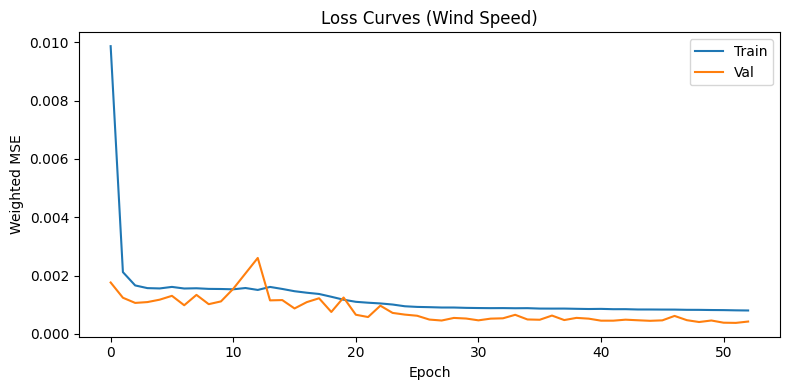

Test Loss (front-weighted MSE): 0.0004

Final Test Metrics (last step, m/s): MSE=0.48, RMSE=0.69, MAE=0.54, MAPE=9.20, R²=0.7443, Adj R²=0.7439
Final Test Metrics (full 24h path): RMSE=0.49, MAE=0.38, MAPE=6.48, R²=0.9325
Hourly-averaged RMSE by lead hour (0→23):
[0.3 , 0.29, 0.35, 0.42, 0.46, 0.47, 0.46, 0.44, 0.43, 0.44, 0.45, 0.46,
 0.48, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.56, 0.57, 0.57, 0.59, 0.63, 0.67]
Avg inference latency: 0.44 ms/batch • 0.44 ms/sample


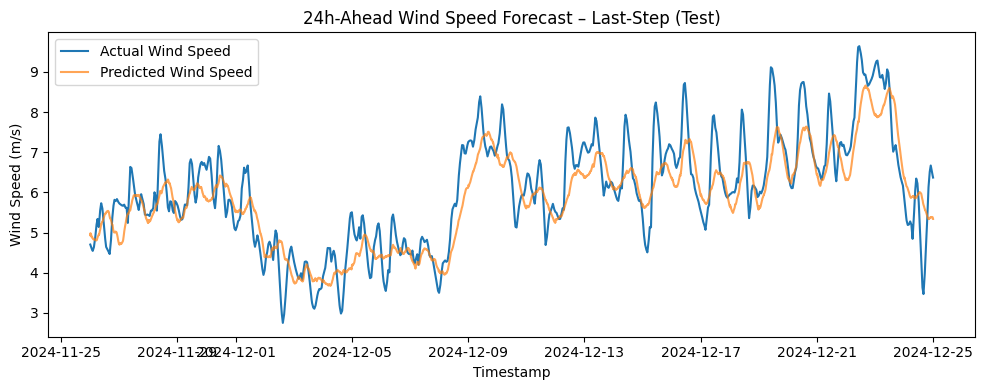

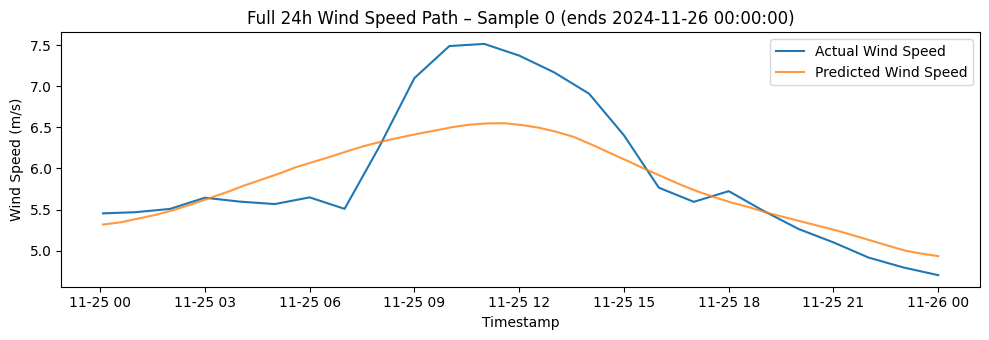

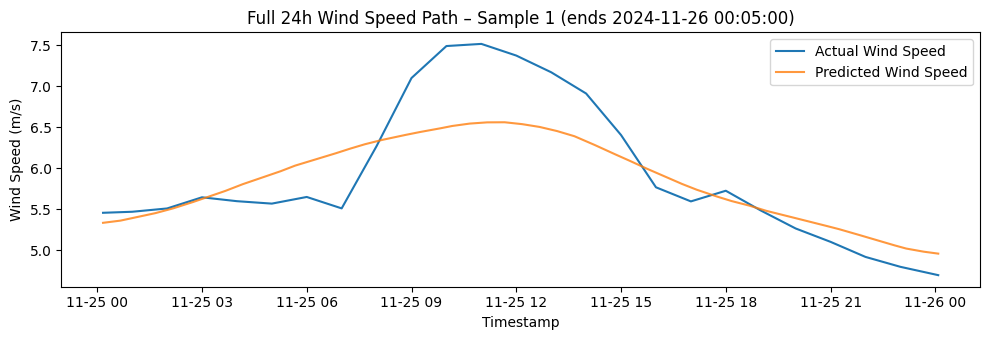

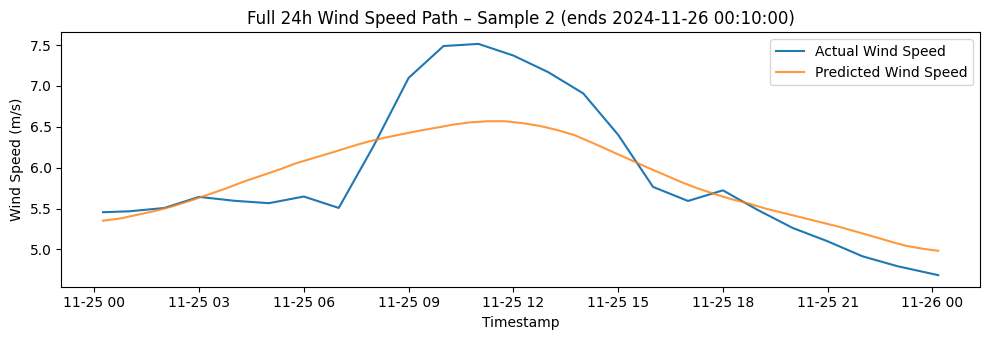

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time, random, math
from typing import List
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1337)

# ----------------------------
# Dataset
# ----------------------------
class LoadWindowDataset(Dataset):
    def __init__(self, data_array, window, horizon):
        self.data = data_array
        self.window, self.horizon = window, horizon
        self.n = data_array.shape[0] - window - horizon + 1
        if self.n <= 0:
            raise ValueError("Window/horizon too large for data length.")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window]                                        # [W, F]
        y_seq = self.data[idx + self.window: idx + self.window + self.horizon, -1:] # [H, 1]
        return torch.from_numpy(x).float(), torch.from_numpy(y_seq).float()

# ----------------------------
# Model
# ----------------------------
class CNN1D_Forecaster(nn.Module):
    def __init__(self, n_features, window, horizon,
                 channels=32, ksize=9, pool=2, p_drop=0.1, hidden=64):
        super().__init__()
        pad = (ksize - 1) // 2
        self.conv = nn.Conv1d(n_features, channels, kernel_size=ksize, padding=pad, bias=True)
        self.pool = nn.AvgPool1d(pool)
        self.bn   = nn.BatchNorm1d(channels)
        self.do   = nn.Dropout(p_drop)

        conv_T = window // pool
        if conv_T <= 0:
            raise ValueError("Pooling/window configuration invalid; pooled length <= 0.")
        self.flat_dim = channels * conv_T

        concat_dim = self.flat_dim + n_features
        self.head = nn.Sequential(
            nn.Linear(concat_dim, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden, horizon)
        )

    def forward(self, x):
        B, W, F = x.shape
        h = self.conv(x.permute(0, 2, 1))  # [B,C,W]
        h = self.pool(h)                   # [B,C,W/p]
        h = self.bn(h)
        h = self.do(h)
        h = h.reshape(B, -1)               # [B, C*(W/p)]
        z = torch.cat([h, x[:, -1, :]], dim=1)  # concat last-step features
        yhat = self.head(z)                     # [B,H]
        return yhat.unsqueeze(-1)               # [B,H,1]

# ----------------------------
# Early Stopping (CPU snapshot)
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=25, delta=1e-4, verbose=True):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.best_loss = np.inf
        self.wait = 0
        self.should_stop = False
        self.best_state = None

    def step(self, val_loss, model=None):
        improved = val_loss < self.best_loss - self.delta
        if improved:
            self.best_loss = val_loss
            self.wait = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: stop after {self.patience} epochs.")
        return improved

# ----------------------------
# Helpers
# ----------------------------
def infer_5min_freq(index: pd.DatetimeIndex) -> pd.Timedelta:
    freq = pd.infer_freq(index)
    if freq is None:
        diffs = pd.Series(index[1:] - index[:-1])
        step = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=5)
    else:
        step = pd.Timedelta(freq)
    if step != pd.Timedelta(minutes=5):
        print(f"[WARN] Detected step={step}. Script assumes 5-minute cadence.")
    return step

def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour + idx.minute/60.0
    hod = hour / 24.0
    dow = idx.dayofweek.astype(float) / 7.0
    doy = (idx.dayofyear.astype(float) - 1.0) / 366.0
    cal = pd.DataFrame(index=idx)
    cal["hod_sin"] = np.sin(2*np.pi*hod); cal["hod_cos"] = np.cos(2*np.pi*hod)
    cal["dow_sin"] = np.sin(2*np.pi*dow); cal["dow_cos"] = np.cos(2*np.pi*dow)
    cal["doy_sin"] = np.sin(2*np.pi*doy); cal["doy_cos"] = np.cos(2*np.pi*doy)
    return cal

def cosine_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / float(warmup_epochs)
        denom = max(float(total_epochs - warmup_epochs), 1.0)
        progress = min(max((epoch - warmup_epochs) / denom, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)
    )

# ----------------------------
# Main
# ----------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset
    df = pd.read_csv(
        'Dataset/Wind/wind_forecasting_final_outlier_based.csv',
        parse_dates=['DATETIME'],
        index_col='DATETIME'
    ).fillna(0)

    # Target column
    target_col = 'WS50M'
    df['TARGET'] = df[target_col]

    # --- Use all the features you already have ---
    # Drop target from the features so it's only in TARGET
    feature_cols = [c for c in df.columns if c not in ['TARGET', target_col]]

    X_exo = df[feature_cols].copy()

    # Handle inf/nan
    X_exo.replace([np.inf, -np.inf], np.nan, inplace=True)
    finite_rows = np.isfinite(X_exo.to_numpy()).all(axis=1)
    finite_target = np.isfinite(df['TARGET'].to_numpy())
    valid_mask = finite_rows & finite_target

    df    = df.loc[valid_mask].copy()
    X_exo = X_exo.loc[valid_mask].copy()

    # Window end timestamps
    W = 7 * 24 * 12   # lookback
    H = 1 * 24 * 12   # horizon
    times = df.index[W + H - 1 :]

    # Splits
    train_end = pd.Timestamp('2023-12-25 23:55:00')
    val_end   = pd.Timestamp('2024-11-25 23:55:00')

    # --- Scaling ---
    train_mask_for_scaler = df.index <= train_end
    feat_scaler = MinMaxScaler()
    feat_scaler.fit(X_exo.loc[train_mask_for_scaler])
    X_feats_scaled = feat_scaler.transform(X_exo)

    tgt_scaler = MinMaxScaler()
    tgt_scaler.fit(df.loc[train_mask_for_scaler, ['TARGET']])
    y_scaled = tgt_scaler.transform(df[['TARGET']])

    # Final array
    data = np.hstack([X_feats_scaled, y_scaled])
    n_features = data.shape[1]  # all features + target

    # ----------------------------
    # Indexing with optional stride (speeds up training)
    # ----------------------------
    stride = 6  # Smaller stride for wind data (changes faster)
    all_idx = np.arange(len(times))
    train_idx = all_idx[times <= train_end][::stride]
    val_idx   = all_idx[(times > train_end) & (times <= val_end)][::stride]
    test_idx  = all_idx[times > val_end]

    print(f"Train windows: {len(train_idx)}, Validation windows: {len(val_idx)}, Test windows: {len(test_idx)}")
    if len(times) > 0:
        print(f"First window ts: {times.min()}, Last: {times.max()}")
    assert len(train_idx) > 0, "No training windows found—check train_end vs. data coverage"
    assert len(val_idx) > 0, "No validation windows found—check val_end vs. data coverage"
    assert len(test_idx) > 0, "No test windows found—does your data extend past val_end?"

    # Datasets / Loaders
    full_ds = LoadWindowDataset(data, W, H)
    train_ds = Subset(full_ds, train_idx)
    val_ds   = Subset(full_ds, val_idx)
    test_ds  = Subset(full_ds, test_idx)

    pin = (device.type == 'cuda')
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)

    # ----------------------------
    # Model + optimizer + loss + scheduler
    # ----------------------------
    model = CNN1D_Forecaster(
        n_features=n_features, window=W, horizon=H,
        channels=64, ksize=9, pool=2, p_drop=0.2, hidden=128
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    es = EarlyStopping(patience=25, delta=1e-4, verbose=True)

    # Weighted loss for wind forecasting (emphasize short-term accuracy)
    weights = torch.linspace(1.5, 0.5, steps=H, device=device).view(1, H, 1)
    def weighted_mse(pred, target):
        return ((weights * (pred - target) ** 2).mean())
    f_fn = weighted_mse

    total_epochs = 100
    warmup_epochs = 20
    sched = cosine_warmup_scheduler(opt, warmup_epochs, total_epochs)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of parameters:", n_params)

    train_losses, val_losses = [], []

    # ----------------------------
    # Training Loop
    # ----------------------------
    for ep in range(1, total_epochs + 1):
        t0 = time.time()
        model.train()
        tl = 0.0
        for Xb, Yseqb in train_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            loss = f_fn(yhat, Yseqb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
        train_losses.append(tl / len(train_ds))

        # Validation
        model.eval()
        vl, preds_last_scaled, truths_last_scaled = 0.0, [], []
        preds_full_scaled, truths_full_scaled = [], []
        with torch.no_grad():
            for Xb, Yseqb in val_loader:
                Xb, Yseqb = Xb.to(device), Yseqb.to(device)
                yhat = model(Xb)
                vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
                preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
                truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
                preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
                truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
        val_loss = vl / len(val_ds)
        val_losses.append(val_loss)

        # step LR ONCE PER EPOCH
        sched.step()

        # Inverse metrics
        preds = np.concatenate(preds_last_scaled)
        truths = np.concatenate(truths_last_scaled)
        inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
        inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]
        rm  = root_mean_squared_error(inv_t, inv_p)
        mae = mean_absolute_error(inv_t, inv_p)
        r2  = r2_score(inv_t, inv_p)
        mape = smape(inv_t, inv_p)

        pf = np.concatenate(preds_full_scaled, axis=0)
        tf = np.concatenate(truths_full_scaled, axis=0)
        inv_pf = tgt_scaler.inverse_transform(pf.reshape(-1,1))[:,0]
        inv_tf = tgt_scaler.inverse_transform(tf.reshape(-1,1))[:,0]
        rm_all  = root_mean_squared_error(inv_tf, inv_pf)
        mae_all = mean_absolute_error(inv_tf, inv_pf)
        r2_all  = r2_score(inv_tf, inv_pf)
        mape_all = smape(inv_tf, inv_pf)

        cur_lr = opt.param_groups[0]['lr']
        print(f"Ep{ep:02d} Train={train_losses[-1]:.4f} | Val={val_loss:.4f} | "
              f"Val(last) RMSE={rm:.1f} MAE={mae:.1f} MAPE={mape:.2f}% R²={r2:.3f} | "
              f"Val(full) RMSE={rm_all:.1f} MAE={mae_all:.1f} MAPE={mape_all:.2f}% R²={r2_all:.3f} | "
              f"LR={cur_lr:.6f} | Time={time.time()-t0:.1f}s")

        _ = es.step(val_loss, model=model)
        if es.should_stop:
            if es.best_state is not None:
                model.load_state_dict(es.best_state)
                if es.verbose:
                    print("EarlyStopping: best weights restored.")
            break

    # ----------------------------
    # Loss curves
    # ----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Weighted MSE'); plt.legend(); plt.title('Loss Curves (Wind Speed)')
    plt.tight_layout(); plt.show()

    # ----------------------------
    # Testing
    # ----------------------------
    model.eval()
    preds_last_scaled, truths_last_scaled = [], []
    preds_full_scaled, truths_full_scaled = [], []
    test_vl = 0.0
    with torch.no_grad():
        for Xb, Yseqb in test_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            test_vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
            preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
            truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
            preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
            truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
    test_loss = test_vl / len(test_ds)

    preds = np.concatenate(preds_last_scaled)
    truths = np.concatenate(truths_last_scaled)
    inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
    inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]

    mse = mean_squared_error(inv_t, inv_p)
    rm  = root_mean_squared_error(inv_t, inv_p)
    mae = mean_absolute_error(inv_t, inv_p)
    mape = smape(inv_t, inv_p)
    r2  = r2_score(inv_t, inv_p)
    n, p = len(inv_t), (n_features - 1)
    adj_r2 = 1 - (1-r2)*(n-1)/max(n-p-1, 1)

    PH = np.concatenate(preds_full_scaled, axis=0)
    TH = np.concatenate(truths_full_scaled, axis=0)
    inv_pf = tgt_scaler.inverse_transform(PH.reshape(-1,1))[:,0]
    inv_tf = tgt_scaler.inverse_transform(TH.reshape(-1,1))[:,0]
    rm_all  = root_mean_squared_error(inv_tf, inv_pf)
    mae_all = mean_absolute_error(inv_tf, inv_pf)
    mape_all = smape(inv_tf, inv_pf)

    # Per-lead RMSE (hourly average over 24h)
    lead_rmse = []
    for h in range(PH.shape[1]):
        inv_ph = tgt_scaler.inverse_transform(PH[:, h].reshape(-1,1))[:,0]
        inv_th = tgt_scaler.inverse_transform(TH[:, h].reshape(-1,1))[:,0]
        lead_rmse.append(root_mean_squared_error(inv_th, inv_ph))
    hourly_rmse = np.array(lead_rmse).reshape(-1, 12).mean(axis=1)

    print(f"Test Loss (front-weighted MSE): {test_loss:.4f}")
    print(f"\nFinal Test Metrics (last step, m/s): "
          f"MSE={mse:.2f}, RMSE={rm:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}")
    print(f"Final Test Metrics (full 24h path): RMSE={rm_all:.2f}, MAE={mae_all:.2f}, MAPE={mape_all:.2f}, R²={r2_all:.4f}")
    print("Hourly-averaged RMSE by lead hour (0→23):")
    print(np.array2string(hourly_rmse, precision=2, separator=', '))

    # Inference latency (batch=1)
    _ = model(torch.randn(1, W, n_features).to(device))
    if device.type == 'cuda':
        torch.cuda.synchronize()
    Nruns = 100
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    total_time = 0.0
    with torch.no_grad():
        for _ in range(Nruns):
            inp = torch.randn(1, W, n_features).to(device)
            start.record(); _ = model(inp); end.record()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            total_time += start.elapsed_time(end) / 1000.0
    avg_batch = total_time / Nruns
    print(f"Avg inference latency: {avg_batch*1000:.2f} ms/batch • {avg_batch*1000:.2f} ms/sample")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(times[test_idx], inv_t, label='Actual Wind Speed')
    plt.plot(times[test_idx], inv_p, label='Predicted Wind Speed', alpha=0.7)
    plt.title("24h-Ahead Wind Speed Forecast – Last-Step (Test)")
    plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Show sample forecasts
    num_show = min(3, len(test_idx))
    if num_show > 0:
        Xb, Yseqb = next(iter(DataLoader(test_ds, batch_size=num_show, shuffle=False)))
        Xb = Xb.to(device)
        with torch.no_grad():
            yhat = model(Xb).cpu().numpy()
        ytrue = Yseqb.numpy()
        for i in range(min(num_show, Xb.size(0))):
            pred_i = tgt_scaler.inverse_transform(yhat[i, :, 0].reshape(-1,1))[:,0]
            true_i = tgt_scaler.inverse_transform(ytrue[i, :, 0].reshape(-1,1))[:,0]
            end_ts = times[test_idx[i]]
            tgrid = pd.date_range(end=end_ts, periods=H, freq='5min')
            plt.figure(figsize=(10,3.5))
            plt.plot(tgrid, true_i, label='Actual Wind Speed')
            plt.plot(tgrid, pred_i, label='Predicted Wind Speed', alpha=0.8)
            plt.title(f"Full 24h Wind Speed Path – Sample {i} (ends {end_ts})")
            plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
            plt.legend(); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()

Train windows: 174913, Validation windows: 16128, Test windows: 8352
First window ts: 2014-01-02 23:55:00, Last: 2024-12-24 23:55:00
No. of parameters: 8303456
Ep01 Train=0.0103 | Val=0.0032 | Val(last) RMSE=1.6 MAE=1.2 MAPE=29.36% R²=0.382 | Val(full) RMSE=1.4 MAE=1.1 MAPE=27.08% R²=0.494 | LR=0.000050 | Time=39.8s
Ep02 Train=0.0032 | Val=0.0023 | Val(last) RMSE=1.5 MAE=1.1 MAPE=27.65% R²=0.450 | Val(full) RMSE=1.2 MAE=0.9 MAPE=23.28% R²=0.625 | LR=0.000075 | Time=37.2s
Ep03 Train=0.0027 | Val=0.0024 | Val(last) RMSE=1.5 MAE=1.1 MAPE=27.49% R²=0.472 | Val(full) RMSE=1.2 MAE=0.9 MAPE=23.57% R²=0.623 | LR=0.000100 | Time=37.7s
Ep04 Train=0.0027 | Val=0.0023 | Val(last) RMSE=1.5 MAE=1.1 MAPE=27.72% R²=0.454 | Val(full) RMSE=1.2 MAE=0.9 MAPE=23.34% R²=0.626 | LR=0.000125 | Time=34.1s
Ep05 Train=0.0026 | Val=0.0025 | Val(last) RMSE=1.5 MAE=1.2 MAPE=28.56% R²=0.428 | Val(full) RMSE=1.3 MAE=1.0 MAPE=24.00% R²=0.606 | LR=0.000150 | Time=39.4s
Ep06 Train=0.0026 | Val=0.0023 | Val(last) RMSE=1.

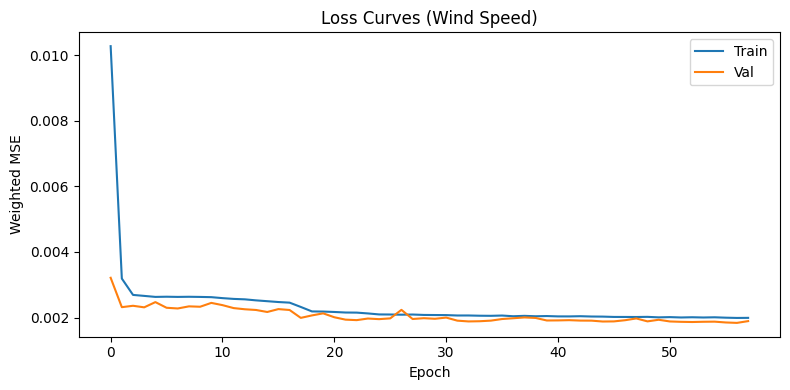

Test Loss (front-weighted MSE): 0.0013

Final Test Metrics (last step, m/s): MSE=1.38, RMSE=1.18, MAE=0.92, MAPE=15.48, R²=0.2592, Adj R²=0.2582
Final Test Metrics (full 24h path): RMSE=0.93, MAE=0.70, MAPE=11.90, R²=0.6811
Hourly-averaged RMSE by lead hour (0→23):
[0.32, 0.35, 0.46, 0.57, 0.67, 0.75, 0.8 , 0.84, 0.88, 0.9 , 0.92, 0.94,
 0.96, 0.98, 1.01, 1.03, 1.06, 1.09, 1.12, 1.14, 1.16, 1.17, 1.17, 1.17]
Avg inference latency: 0.52 ms/batch • 0.52 ms/sample


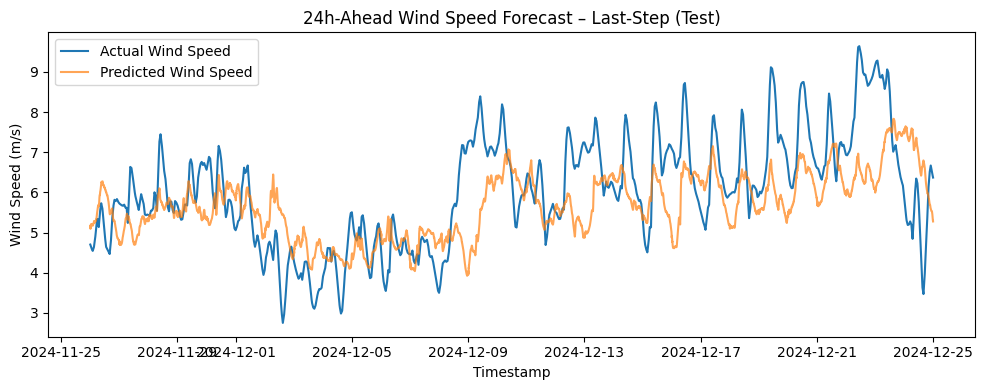

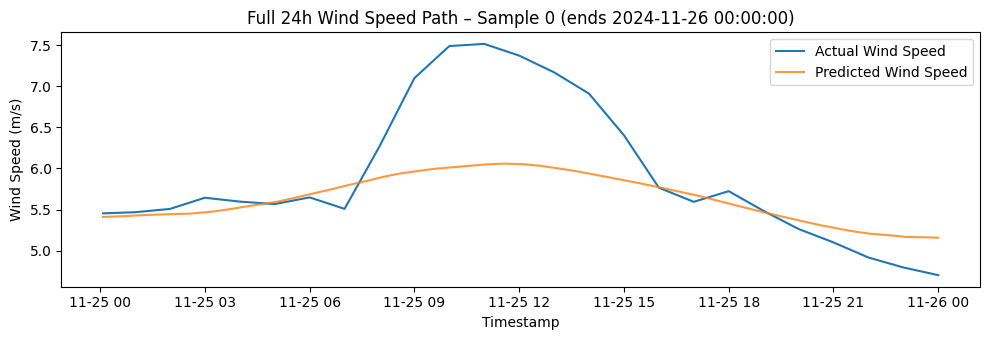

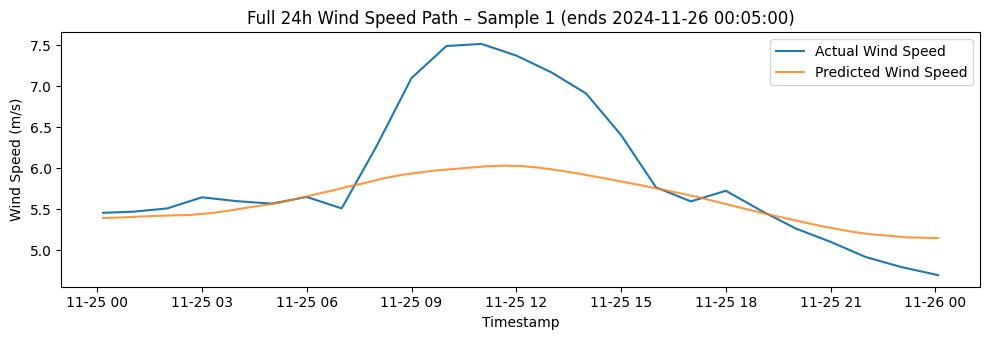

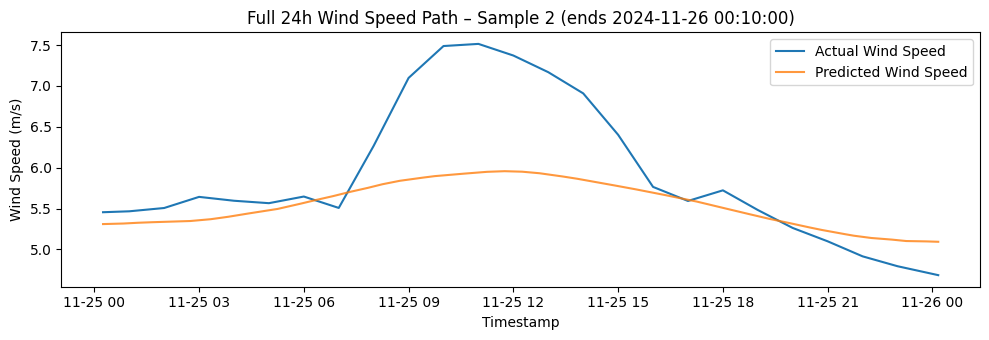

In [5]:
# no outlier detection (typhoon)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time, random, math
from typing import List
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1337)

# ----------------------------
# Dataset
# ----------------------------
class LoadWindowDataset(Dataset):
    def __init__(self, data_array, window, horizon):
        self.data = data_array
        self.window, self.horizon = window, horizon
        self.n = data_array.shape[0] - window - horizon + 1
        if self.n <= 0:
            raise ValueError("Window/horizon too large for data length.")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window]                                        # [W, F]
        y_seq = self.data[idx + self.window: idx + self.window + self.horizon, -1:] # [H, 1]
        return torch.from_numpy(x).float(), torch.from_numpy(y_seq).float()

# ----------------------------
# Model
# ----------------------------
class CNN1D_Forecaster(nn.Module):
    def __init__(self, n_features, window, horizon,
                 channels=32, ksize=9, pool=2, p_drop=0.1, hidden=64):
        super().__init__()
        pad = (ksize - 1) // 2
        self.conv = nn.Conv1d(n_features, channels, kernel_size=ksize, padding=pad, bias=True)
        self.pool = nn.AvgPool1d(pool)
        self.bn   = nn.BatchNorm1d(channels)
        self.do   = nn.Dropout(p_drop)

        conv_T = window // pool
        if conv_T <= 0:
            raise ValueError("Pooling/window configuration invalid; pooled length <= 0.")
        self.flat_dim = channels * conv_T

        concat_dim = self.flat_dim + n_features
        self.head = nn.Sequential(
            nn.Linear(concat_dim, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden, horizon)
        )

    def forward(self, x):
        B, W, F = x.shape
        h = self.conv(x.permute(0, 2, 1))  # [B,C,W]
        h = self.pool(h)                   # [B,C,W/p]
        h = self.bn(h)
        h = self.do(h)
        h = h.reshape(B, -1)               # [B, C*(W/p)]
        z = torch.cat([h, x[:, -1, :]], dim=1)  # concat last-step features
        yhat = self.head(z)                     # [B,H]
        return yhat.unsqueeze(-1)               # [B,H,1]

# ----------------------------
# Early Stopping (CPU snapshot)
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=25, delta=1e-4, verbose=True):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.best_loss = np.inf
        self.wait = 0
        self.should_stop = False
        self.best_state = None

    def step(self, val_loss, model=None):
        improved = val_loss < self.best_loss - self.delta
        if improved:
            self.best_loss = val_loss
            self.wait = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: stop after {self.patience} epochs.")
        return improved

# ----------------------------
# Helpers
# ----------------------------
def infer_5min_freq(index: pd.DatetimeIndex) -> pd.Timedelta:
    freq = pd.infer_freq(index)
    if freq is None:
        diffs = pd.Series(index[1:] - index[:-1])
        step = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=5)
    else:
        step = pd.Timedelta(freq)
    if step != pd.Timedelta(minutes=5):
        print(f"[WARN] Detected step={step}. Script assumes 5-minute cadence.")
    return step

def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour + idx.minute/60.0
    hod = hour / 24.0
    dow = idx.dayofweek.astype(float) / 7.0
    doy = (idx.dayofyear.astype(float) - 1.0) / 366.0
    cal = pd.DataFrame(index=idx)
    cal["hod_sin"] = np.sin(2*np.pi*hod); cal["hod_cos"] = np.cos(2*np.pi*hod)
    cal["dow_sin"] = np.sin(2*np.pi*dow); cal["dow_cos"] = np.cos(2*np.pi*dow)
    cal["doy_sin"] = np.sin(2*np.pi*doy); cal["doy_cos"] = np.cos(2*np.pi*doy)
    return cal

def cosine_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / float(warmup_epochs)
        denom = max(float(total_epochs - warmup_epochs), 1.0)
        progress = min(max((epoch - warmup_epochs) / denom, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)
    )

# ----------------------------
# Main
# ----------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset
    df = pd.read_csv(
        'Dataset/Wind/wind_forecasting_final_rolling_mean_7d.csv',
        parse_dates=['DATETIME'],
        index_col='DATETIME'
    ).fillna(0)

    # Target column
    target_col = 'WS50M'
    df['TARGET'] = df[target_col]

    # --- Use all the features you already have ---
    # Drop target from the features so it's only in TARGET
    feature_cols = [c for c in df.columns if c not in ['TARGET', target_col]]

    X_exo = df[feature_cols].copy()

    # Handle inf/nan
    X_exo.replace([np.inf, -np.inf], np.nan, inplace=True)
    finite_rows = np.isfinite(X_exo.to_numpy()).all(axis=1)
    finite_target = np.isfinite(df['TARGET'].to_numpy())
    valid_mask = finite_rows & finite_target

    df    = df.loc[valid_mask].copy()
    X_exo = X_exo.loc[valid_mask].copy()

    # Window end timestamps
    W = 7 * 24 * 12   # lookback
    H = 1 * 24 * 12   # horizon
    times = df.index[W + H - 1 :]

    # Splits
    train_end = pd.Timestamp('2023-12-25 23:55:00')
    val_end   = pd.Timestamp('2024-11-25 23:55:00')

    # --- Scaling ---
    train_mask_for_scaler = df.index <= train_end
    feat_scaler = MinMaxScaler()
    feat_scaler.fit(X_exo.loc[train_mask_for_scaler])
    X_feats_scaled = feat_scaler.transform(X_exo)

    tgt_scaler = MinMaxScaler()
    tgt_scaler.fit(df.loc[train_mask_for_scaler, ['TARGET']])
    y_scaled = tgt_scaler.transform(df[['TARGET']])

    # Final array
    data = np.hstack([X_feats_scaled, y_scaled])
    n_features = data.shape[1]  # all features + target

    # ----------------------------
    # Indexing with optional stride (speeds up training)
    # ----------------------------
    stride = 6  # Smaller stride for wind data (changes faster)
    all_idx = np.arange(len(times))
    train_idx = all_idx[times <= train_end][::stride]
    val_idx   = all_idx[(times > train_end) & (times <= val_end)][::stride]
    test_idx  = all_idx[times > val_end]

    print(f"Train windows: {len(train_idx)}, Validation windows: {len(val_idx)}, Test windows: {len(test_idx)}")
    if len(times) > 0:
        print(f"First window ts: {times.min()}, Last: {times.max()}")
    assert len(train_idx) > 0, "No training windows found—check train_end vs. data coverage"
    assert len(val_idx) > 0, "No validation windows found—check val_end vs. data coverage"
    assert len(test_idx) > 0, "No test windows found—does your data extend past val_end?"

    # Datasets / Loaders
    full_ds = LoadWindowDataset(data, W, H)
    train_ds = Subset(full_ds, train_idx)
    val_ds   = Subset(full_ds, val_idx)
    test_ds  = Subset(full_ds, test_idx)

    pin = (device.type == 'cuda')
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)

    # ----------------------------
    # Model + optimizer + loss + scheduler
    # ----------------------------
    model = CNN1D_Forecaster(
        n_features=n_features, window=W, horizon=H,
        channels=64, ksize=9, pool=2, p_drop=0.2, hidden=128
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    es = EarlyStopping(patience=25, delta=1e-4, verbose=True)

    # Weighted loss for wind forecasting (emphasize short-term accuracy)
    weights = torch.linspace(1.5, 0.5, steps=H, device=device).view(1, H, 1)
    def weighted_mse(pred, target):
        return ((weights * (pred - target) ** 2).mean())
    f_fn = weighted_mse

    total_epochs = 100
    warmup_epochs = 20
    sched = cosine_warmup_scheduler(opt, warmup_epochs, total_epochs)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of parameters:", n_params)

    train_losses, val_losses = [], []

    # ----------------------------
    # Training Loop
    # ----------------------------
    for ep in range(1, total_epochs + 1):
        t0 = time.time()
        model.train()
        tl = 0.0
        for Xb, Yseqb in train_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            loss = f_fn(yhat, Yseqb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
        train_losses.append(tl / len(train_ds))

        # Validation
        model.eval()
        vl, preds_last_scaled, truths_last_scaled = 0.0, [], []
        preds_full_scaled, truths_full_scaled = [], []
        with torch.no_grad():
            for Xb, Yseqb in val_loader:
                Xb, Yseqb = Xb.to(device), Yseqb.to(device)
                yhat = model(Xb)
                vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
                preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
                truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
                preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
                truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
        val_loss = vl / len(val_ds)
        val_losses.append(val_loss)

        # step LR ONCE PER EPOCH
        sched.step()

        # Inverse metrics
        preds = np.concatenate(preds_last_scaled)
        truths = np.concatenate(truths_last_scaled)
        inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
        inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]
        rm  = root_mean_squared_error(inv_t, inv_p)
        mae = mean_absolute_error(inv_t, inv_p)
        r2  = r2_score(inv_t, inv_p)
        mape = smape(inv_t, inv_p)

        pf = np.concatenate(preds_full_scaled, axis=0)
        tf = np.concatenate(truths_full_scaled, axis=0)
        inv_pf = tgt_scaler.inverse_transform(pf.reshape(-1,1))[:,0]
        inv_tf = tgt_scaler.inverse_transform(tf.reshape(-1,1))[:,0]
        rm_all  = root_mean_squared_error(inv_tf, inv_pf)
        mae_all = mean_absolute_error(inv_tf, inv_pf)
        r2_all  = r2_score(inv_tf, inv_pf)
        mape_all = smape(inv_tf, inv_pf)

        cur_lr = opt.param_groups[0]['lr']
        print(f"Ep{ep:02d} Train={train_losses[-1]:.4f} | Val={val_loss:.4f} | "
              f"Val(last) RMSE={rm:.1f} MAE={mae:.1f} MAPE={mape:.2f}% R²={r2:.3f} | "
              f"Val(full) RMSE={rm_all:.1f} MAE={mae_all:.1f} MAPE={mape_all:.2f}% R²={r2_all:.3f} | "
              f"LR={cur_lr:.6f} | Time={time.time()-t0:.1f}s")

        _ = es.step(val_loss, model=model)
        if es.should_stop:
            if es.best_state is not None:
                model.load_state_dict(es.best_state)
                if es.verbose:
                    print("EarlyStopping: best weights restored.")
            break

    # ----------------------------
    # Loss curves
    # ----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Weighted MSE'); plt.legend(); plt.title('Loss Curves (Wind Speed)')
    plt.tight_layout(); plt.show()

    # ----------------------------
    # Testing
    # ----------------------------
    model.eval()
    preds_last_scaled, truths_last_scaled = [], []
    preds_full_scaled, truths_full_scaled = [], []
    test_vl = 0.0
    with torch.no_grad():
        for Xb, Yseqb in test_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            test_vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
            preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
            truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
            preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
            truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
    test_loss = test_vl / len(test_ds)

    preds = np.concatenate(preds_last_scaled)
    truths = np.concatenate(truths_last_scaled)
    inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
    inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]

    mse = mean_squared_error(inv_t, inv_p)
    rm  = root_mean_squared_error(inv_t, inv_p)
    mae = mean_absolute_error(inv_t, inv_p)
    mape = smape(inv_t, inv_p)
    r2  = r2_score(inv_t, inv_p)
    n, p = len(inv_t), (n_features - 1)
    adj_r2 = 1 - (1-r2)*(n-1)/max(n-p-1, 1)

    PH = np.concatenate(preds_full_scaled, axis=0)
    TH = np.concatenate(truths_full_scaled, axis=0)
    inv_pf = tgt_scaler.inverse_transform(PH.reshape(-1,1))[:,0]
    inv_tf = tgt_scaler.inverse_transform(TH.reshape(-1,1))[:,0]
    rm_all  = root_mean_squared_error(inv_tf, inv_pf)
    mae_all = mean_absolute_error(inv_tf, inv_pf)
    mape_all = smape(inv_tf, inv_pf)

    # Per-lead RMSE (hourly average over 24h)
    lead_rmse = []
    for h in range(PH.shape[1]):
        inv_ph = tgt_scaler.inverse_transform(PH[:, h].reshape(-1,1))[:,0]
        inv_th = tgt_scaler.inverse_transform(TH[:, h].reshape(-1,1))[:,0]
        lead_rmse.append(root_mean_squared_error(inv_th, inv_ph))
    hourly_rmse = np.array(lead_rmse).reshape(-1, 12).mean(axis=1)

    print(f"Test Loss (front-weighted MSE): {test_loss:.4f}")
    print(f"\nFinal Test Metrics (last step, m/s): "
          f"MSE={mse:.2f}, RMSE={rm:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}")
    print(f"Final Test Metrics (full 24h path): RMSE={rm_all:.2f}, MAE={mae_all:.2f}, MAPE={mape_all:.2f}, R²={r2_all:.4f}")
    print("Hourly-averaged RMSE by lead hour (0→23):")
    print(np.array2string(hourly_rmse, precision=2, separator=', '))

    # Inference latency (batch=1)
    _ = model(torch.randn(1, W, n_features).to(device))
    if device.type == 'cuda':
        torch.cuda.synchronize()
    Nruns = 100
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    total_time = 0.0
    with torch.no_grad():
        for _ in range(Nruns):
            inp = torch.randn(1, W, n_features).to(device)
            start.record(); _ = model(inp); end.record()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            total_time += start.elapsed_time(end) / 1000.0
    avg_batch = total_time / Nruns
    print(f"Avg inference latency: {avg_batch*1000:.2f} ms/batch • {avg_batch*1000:.2f} ms/sample")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(times[test_idx], inv_t, label='Actual Wind Speed')
    plt.plot(times[test_idx], inv_p, label='Predicted Wind Speed', alpha=0.7)
    plt.title("24h-Ahead Wind Speed Forecast – Last-Step (Test)")
    plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Show sample forecasts
    num_show = min(3, len(test_idx))
    if num_show > 0:
        Xb, Yseqb = next(iter(DataLoader(test_ds, batch_size=num_show, shuffle=False)))
        Xb = Xb.to(device)
        with torch.no_grad():
            yhat = model(Xb).cpu().numpy()
        ytrue = Yseqb.numpy()
        for i in range(min(num_show, Xb.size(0))):
            pred_i = tgt_scaler.inverse_transform(yhat[i, :, 0].reshape(-1,1))[:,0]
            true_i = tgt_scaler.inverse_transform(ytrue[i, :, 0].reshape(-1,1))[:,0]
            end_ts = times[test_idx[i]]
            tgrid = pd.date_range(end=end_ts, periods=H, freq='5min')
            plt.figure(figsize=(10,3.5))
            plt.plot(tgrid, true_i, label='Actual Wind Speed')
            plt.plot(tgrid, pred_i, label='Predicted Wind Speed', alpha=0.8)
            plt.title(f"Full 24h Wind Speed Path – Sample {i} (ends {end_ts})")
            plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
            plt.legend(); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()

                     HoD  DoY  MoY     WS50M      WD50M         PS       RH2M  \
DATETIME                                                                        
2013-12-26 00:00:00    0  360   12  2.637059  51.823529  99.704118  94.628824   
2013-12-26 00:05:00    0  360   12  2.637083  50.567892  99.698407  94.616103   
2013-12-26 00:10:00    0  360   12  2.637108  49.312255  99.692696  94.603382   
2013-12-26 00:15:00    0  360   12  2.637132  48.056618  99.686985  94.590662   
2013-12-26 00:20:00    0  360   12  2.637157  46.800980  99.681275  94.577941   

                        T2MDEW        T2M       QV2M  AIR_DENSITY  \
DATETIME                                                            
2013-12-26 00:00:00  24.226765  25.137647  19.081176     0.104301   
2013-12-26 00:05:00  24.219020  25.131838  19.072843     0.104302   
2013-12-26 00:10:00  24.211275  25.126029  19.064510     0.104303   
2013-12-26 00:15:00  24.203529  25.120221  19.056176     0.104304   
2013-12-26 00:20:0

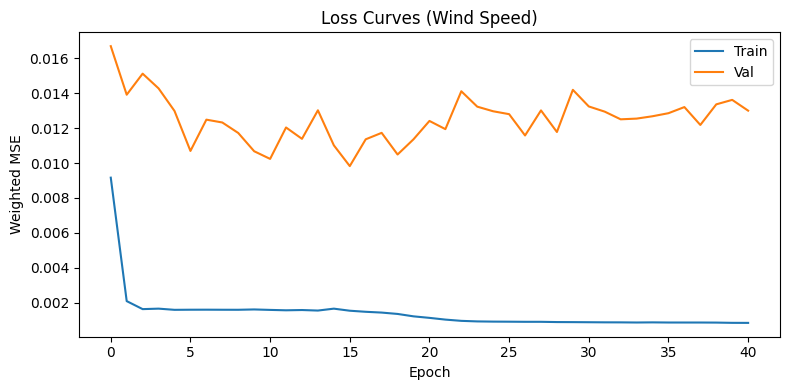

Test Loss (front-weighted MSE): 0.0066

Final Test Metrics (last step, m/s): MSE=4.30, RMSE=2.07, MAE=1.68, MAPE=30.80, R²=-1.3032, Adj R²=-1.3063
Final Test Metrics (full 24h path): RMSE=2.01, MAE=1.66, MAPE=30.13, R²=-0.9649
Hourly-averaged RMSE by lead hour (0→23):
[1.83, 1.84, 1.91, 1.97, 1.99, 1.98, 1.96, 1.95, 1.94, 1.95, 1.97, 2.  ,
 2.03, 2.06, 2.08, 2.09, 2.08, 2.08, 2.08, 2.09, 2.09, 2.08, 2.07, 2.07]
Avg inference latency: 0.55 ms/batch • 0.55 ms/sample


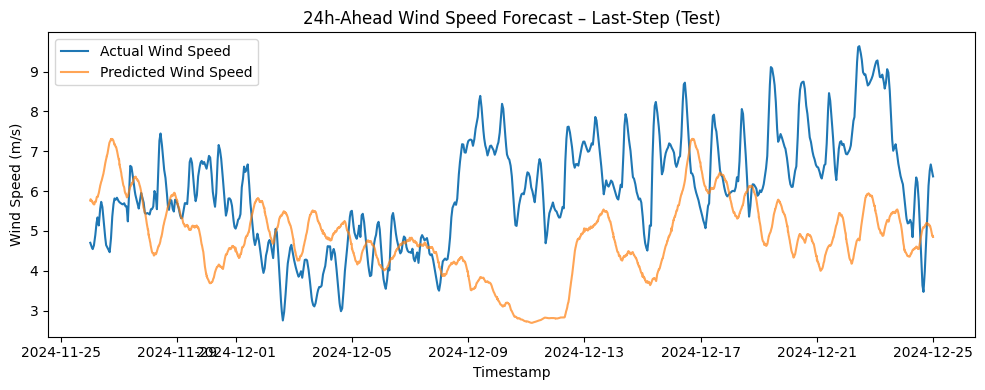

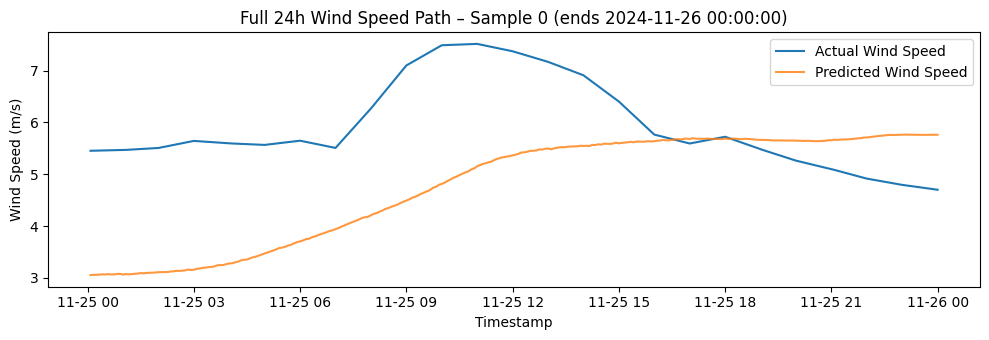

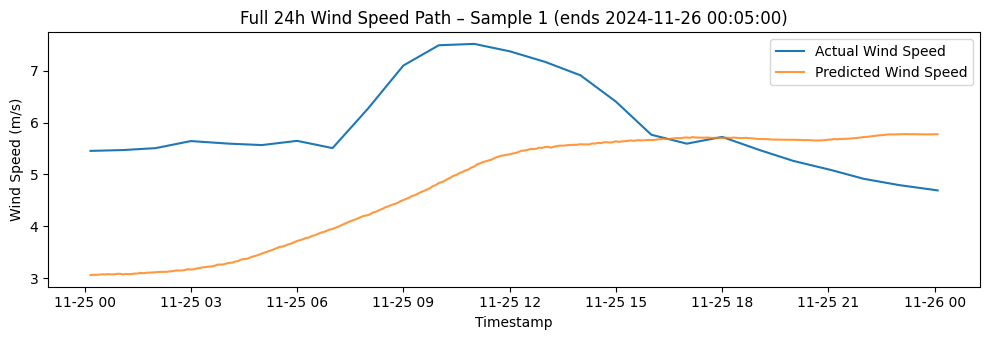

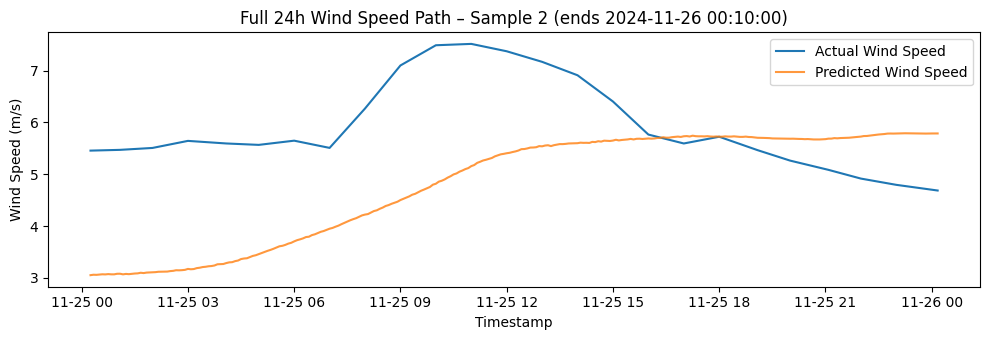

In [6]:
# Centered and causal roll mean: this is the crucial fix that keeps the validation distribution aligned with real-world conditions, avoiding false optimism from “future leaks.” 
# THis only uses rolling mean in center during training, and causal (past only) during validation and testing.

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time, random, math
from typing import List
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1337)

# ----------------------------
# Dataset
# ----------------------------
class LoadWindowDataset(Dataset):
    def __init__(self, data_array, window, horizon):
        self.data = data_array
        self.window, self.horizon = window, horizon
        self.n = data_array.shape[0] - window - horizon + 1
        if self.n <= 0:
            raise ValueError("Window/horizon too large for data length.")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window]                                        # [W, F]
        y_seq = self.data[idx + self.window: idx + self.window + self.horizon, -1:] # [H, 1]
        return torch.from_numpy(x).float(), torch.from_numpy(y_seq).float()

# ----------------------------
# Model
# ----------------------------
class CNN1D_Forecaster(nn.Module):
    def __init__(self, n_features, window, horizon,
                 channels=32, ksize=9, pool=2, p_drop=0.1, hidden=64):
        super().__init__()
        pad = (ksize - 1) // 2
        self.conv = nn.Conv1d(n_features, channels, kernel_size=ksize, padding=pad, bias=True)
        self.pool = nn.AvgPool1d(pool)
        self.bn   = nn.BatchNorm1d(channels)
        self.do   = nn.Dropout(p_drop)

        conv_T = window // pool
        if conv_T <= 0:
            raise ValueError("Pooling/window configuration invalid; pooled length <= 0.")
        self.flat_dim = channels * conv_T

        concat_dim = self.flat_dim + n_features
        self.head = nn.Sequential(
            nn.Linear(concat_dim, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden, horizon)
        )

    def forward(self, x):
        B, W, F = x.shape
        h = self.conv(x.permute(0, 2, 1))  # [B,C,W]
        h = self.pool(h)                   # [B,C,W/p]
        h = self.bn(h)
        h = self.do(h)
        h = h.reshape(B, -1)               # [B, C*(W/p)]
        z = torch.cat([h, x[:, -1, :]], dim=1)  # concat last-step features
        yhat = self.head(z)                     # [B,H]
        return yhat.unsqueeze(-1)               # [B,H,1]

# ----------------------------
# Early Stopping (CPU snapshot)
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=25, delta=1e-4, verbose=True):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.best_loss = np.inf
        self.wait = 0
        self.should_stop = False
        self.best_state = None

    def step(self, val_loss, model=None):
        improved = val_loss < self.best_loss - self.delta
        if improved:
            self.best_loss = val_loss
            self.wait = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: stop after {self.patience} epochs.")
        return improved

# ----------------------------
# Helpers
# ----------------------------
def infer_5min_freq(index: pd.DatetimeIndex) -> pd.Timedelta:
    freq = pd.infer_freq(index)
    if freq is None:
        diffs = pd.Series(index[1:] - index[:-1])
        step = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=5)
    else:
        step = pd.Timedelta(freq)
    if step != pd.Timedelta(minutes=5):
        print(f"[WARN] Detected step={step}. Script assumes 5-minute cadence.")
    return step

def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour + idx.minute/60.0
    hod = hour / 24.0
    dow = idx.dayofweek.astype(float) / 7.0
    doy = (idx.dayofyear.astype(float) - 1.0) / 366.0
    cal = pd.DataFrame(index=idx)
    cal["hod_sin"] = np.sin(2*np.pi*hod); cal["hod_cos"] = np.cos(2*np.pi*hod)
    cal["dow_sin"] = np.sin(2*np.pi*dow); cal["dow_cos"] = np.cos(2*np.pi*dow)
    cal["doy_sin"] = np.sin(2*np.pi*doy); cal["doy_cos"] = np.cos(2*np.pi*doy)
    return cal

def cosine_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / float(warmup_epochs)
        denom = max(float(total_epochs - warmup_epochs), 1.0)
        progress = min(max((epoch - warmup_epochs) / denom, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)
    )

# ----------------------------
# Main
# ----------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset
    df = pd.read_csv(
        'Dataset/Wind/wind_forecasting_final_rolling_mean_7d.csv',
        parse_dates=['DATETIME'],
        index_col='DATETIME'
    ).copy()

    # Target column
    target_col = 'WS50M'
    df['TARGET'] = df[target_col]

    # ----------------------------
    # Compute both centered and causal low-frequency columns
    # - centered (peeks into future): center=True -> used only for training rows
    # - causal  (past only): center=False -> used for val/test rows (no leakage)
    # ----------------------------
    roll_window = 2016  # ~7 days at 5-min cadence
    df['WS50M_low_freq_centered'] = df['WS50M'].rolling(window=roll_window, min_periods=1, center=True).mean()
    df['WS50M_low_freq_causal']  = df['WS50M'].rolling(window=roll_window, min_periods=1, center=False).mean()

    # ----------------------------
    # Splits (you had these dates)
    # ----------------------------
    train_end = pd.Timestamp('2023-12-25 23:55:00')
    val_end   = pd.Timestamp('2024-11-25 23:55:00')

    # We'll create the column `WS50M_low_freq_7d` such that:
    # - for training rows (<= train_end) it equals the centered version (gives training benefit)
    # - for val/test rows (> train_end) it equals the causal version (no future peek)
    df['WS50M_low_freq_7d'] = df['WS50M_low_freq_centered'].copy()
    df.loc[df.index > train_end, 'WS50M_low_freq_7d'] = df.loc[df.index > train_end, 'WS50M_low_freq_causal']

    # Optionally drop intermediate columns to keep df tidy (but not necessary)
    df.drop(columns=['WS50M_low_freq_centered', 'WS50M_low_freq_causal'], inplace=True)

    # --- Use all the features you already have ---
    # Drop target from the features so it's only in TARGET
    feature_cols = [c for c in df.columns if c not in ['TARGET', target_col]]

    X_exo = df[feature_cols].copy()

    # Handle inf/nan
    X_exo.replace([np.inf, -np.inf], np.nan, inplace=True)
    finite_rows = np.isfinite(X_exo.to_numpy()).all(axis=1)
    finite_target = np.isfinite(df['TARGET'].to_numpy())
    valid_mask = finite_rows & finite_target

    df    = df.loc[valid_mask].copy()
    X_exo = X_exo.loc[valid_mask].copy()

    # Window end timestamps
    W = 7 * 24 * 12   # lookback (7 days)
    H = 1 * 24 * 12   # horizon (24h)
    times = df.index[W + H - 1 :]

    print(df.head())
    
    # --- Scaling ---
    train_mask_for_scaler = df.index <= train_end
    feat_scaler = MinMaxScaler()
    # NOTE: scaler fitted on training rows (which include centered low_freq for those rows)
    feat_scaler.fit(X_exo.loc[train_mask_for_scaler])
    X_feats_scaled = feat_scaler.transform(X_exo)

    tgt_scaler = MinMaxScaler()
    tgt_scaler.fit(df.loc[train_mask_for_scaler, ['TARGET']])
    y_scaled = tgt_scaler.transform(df[['TARGET']])

    # Final array (features + target)
    data = np.hstack([X_feats_scaled, y_scaled])
    n_features = data.shape[1]  # all features + target

    # ----------------------------
    # Indexing with optional stride (speeds up training)
    # ----------------------------
    stride = 6  # Smaller stride for wind data (changes faster)
    all_idx = np.arange(len(times))
    train_idx = all_idx[times <= train_end][::stride]
    val_idx   = all_idx[(times > train_end) & (times <= val_end)][::stride]
    test_idx  = all_idx[times > val_end]

    print(f"Train windows: {len(train_idx)}, Validation windows: {len(val_idx)}, Test windows: {len(test_idx)}")
    if len(times) > 0:
        print(f"First window ts: {times.min()}, Last: {times.max()}")
    assert len(train_idx) > 0, "No training windows found—check train_end vs. data coverage"
    assert len(val_idx) > 0, "No validation windows found—check val_end vs. data coverage"
    assert len(test_idx) > 0, "No test windows found—does your data extend past val_end?"

    # Datasets / Loaders
    full_ds = LoadWindowDataset(data, W, H)
    train_ds = Subset(full_ds, train_idx)
    val_ds   = Subset(full_ds, val_idx)
    test_ds  = Subset(full_ds, test_idx)

    pin = (device.type == 'cuda')
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)

    # ----------------------------
    # Model + optimizer + loss + scheduler
    # ----------------------------
    model = CNN1D_Forecaster(
        n_features=n_features, window=W, horizon=H,
        channels=64, ksize=9, pool=2, p_drop=0.2, hidden=128
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    es = EarlyStopping(patience=25, delta=1e-4, verbose=True)

    # Weighted loss for wind forecasting (emphasize short-term accuracy)
    weights = torch.linspace(1.5, 0.5, steps=H, device=device).view(1, H, 1)
    def weighted_mse(pred, target):
        return ((weights * (pred - target) ** 2).mean())
    f_fn = weighted_mse

    total_epochs = 100
    warmup_epochs = 20
    sched = cosine_warmup_scheduler(opt, warmup_epochs, total_epochs)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of parameters:", n_params)

    train_losses, val_losses = [], []

    # ----------------------------
    # Training Loop
    # ----------------------------
    for ep in range(1, total_epochs + 1):
        t0 = time.time()
        model.train()
        tl = 0.0
        for Xb, Yseqb in train_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            loss = f_fn(yhat, Yseqb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
        train_losses.append(tl / len(train_ds))

        # Validation
        model.eval()
        vl, preds_last_scaled, truths_last_scaled = 0.0, [], []
        preds_full_scaled, truths_full_scaled = [], []
        with torch.no_grad():
            for Xb, Yseqb in val_loader:
                Xb, Yseqb = Xb.to(device), Yseqb.to(device)
                yhat = model(Xb)
                vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
                preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
                truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
                preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
                truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
        val_loss = vl / len(val_ds)
        val_losses.append(val_loss)

        # step LR ONCE PER EPOCH
        sched.step()

        # Inverse metrics
        preds = np.concatenate(preds_last_scaled)
        truths = np.concatenate(truths_last_scaled)
        inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
        inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]
        rm  = root_mean_squared_error(inv_t, inv_p)
        mae = mean_absolute_error(inv_t, inv_p)
        r2  = r2_score(inv_t, inv_p)
        mape = smape(inv_t, inv_p)

        pf = np.concatenate(preds_full_scaled, axis=0)
        tf = np.concatenate(truths_full_scaled, axis=0)
        inv_pf = tgt_scaler.inverse_transform(pf.reshape(-1,1))[:,0]
        inv_tf = tgt_scaler.inverse_transform(tf.reshape(-1,1))[:,0]
        rm_all  = root_mean_squared_error(inv_tf, inv_pf)
        mae_all = mean_absolute_error(inv_tf, inv_pf)
        r2_all  = r2_score(inv_tf, inv_pf)
        mape_all = smape(inv_tf, inv_pf)

        cur_lr = opt.param_groups[0]['lr']
        print(f"Ep{ep:02d} Train={train_losses[-1]:.4f} | Val={val_loss:.4f} | "
              f"Val(last) RMSE={rm:.1f} MAE={mae:.1f} MAPE={mape:.2f}% R²={r2:.3f} | "
              f"Val(full) RMSE={rm_all:.1f} MAE={mae_all:.1f} MAPE={mape_all:.2f}% R²={r2_all:.3f} | "
              f"LR={cur_lr:.6f} | Time={time.time()-t0:.1f}s")

        _ = es.step(val_loss, model=model)
        if es.should_stop:
            if es.best_state is not None:
                model.load_state_dict(es.best_state)
                if es.verbose:
                    print("EarlyStopping: best weights restored.")
            break

    # ----------------------------
    # Loss curves
    # ----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Weighted MSE'); plt.legend(); plt.title('Loss Curves (Wind Speed)')
    plt.tight_layout(); plt.show()

    # ----------------------------
    # Testing
    # ----------------------------
    model.eval()
    preds_last_scaled, truths_last_scaled = [], []
    preds_full_scaled, truths_full_scaled = [], []
    test_vl = 0.0
    with torch.no_grad():
        for Xb, Yseqb in test_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            test_vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
            preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
            truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
            preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
            truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
    test_loss = test_vl / len(test_ds)

    preds = np.concatenate(preds_last_scaled)
    truths = np.concatenate(truths_last_scaled)
    inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
    inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]

    mse = mean_squared_error(inv_t, inv_p)
    rm  = root_mean_squared_error(inv_t, inv_p)
    mae = mean_absolute_error(inv_t, inv_p)
    mape = smape(inv_t, inv_p)
    r2  = r2_score(inv_t, inv_p)
    n, p = len(inv_t), (n_features - 1)
    adj_r2 = 1 - (1-r2)*(n-1)/max(n-p-1, 1)

    PH = np.concatenate(preds_full_scaled, axis=0)
    TH = np.concatenate(truths_full_scaled, axis=0)
    inv_pf = tgt_scaler.inverse_transform(PH.reshape(-1,1))[:,0]
    inv_tf = tgt_scaler.inverse_transform(TH.reshape(-1,1))[:,0]
    rm_all  = root_mean_squared_error(inv_tf, inv_pf)
    mae_all = mean_absolute_error(inv_tf, inv_pf)
    mape_all = smape(inv_tf, inv_pf)

    # Per-lead RMSE (hourly average over 24h)
    lead_rmse = []
    for h in range(PH.shape[1]):
        inv_ph = tgt_scaler.inverse_transform(PH[:, h].reshape(-1,1))[:,0]
        inv_th = tgt_scaler.inverse_transform(TH[:, h].reshape(-1,1))[:,0]
        lead_rmse.append(root_mean_squared_error(inv_th, inv_ph))
    hourly_rmse = np.array(lead_rmse).reshape(-1, 12).mean(axis=1)

    print(f"Test Loss (front-weighted MSE): {test_loss:.4f}")
    print(f"\nFinal Test Metrics (last step, m/s): "
          f"MSE={mse:.2f}, RMSE={rm:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}")
    print(f"Final Test Metrics (full 24h path): RMSE={rm_all:.2f}, MAE={mae_all:.2f}, MAPE={mape_all:.2f}, R²={r2_all:.4f}")
    print("Hourly-averaged RMSE by lead hour (0→23):")
    print(np.array2string(hourly_rmse, precision=2, separator=', '))

    # Inference latency (batch=1)
    _ = model(torch.randn(1, W, n_features).to(device))
    if device.type == 'cuda':
        torch.cuda.synchronize()
    Nruns = 100
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    total_time = 0.0
    with torch.no_grad():
        for _ in range(Nruns):
            inp = torch.randn(1, W, n_features).to(device)
            start.record(); _ = model(inp); end.record()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            total_time += start.elapsed_time(end) / 1000.0
    avg_batch = total_time / Nruns
    print(f"Avg inference latency: {avg_batch*1000:.2f} ms/batch • {avg_batch*1000:.2f} ms/sample")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(times[test_idx], inv_t, label='Actual Wind Speed')
    plt.plot(times[test_idx], inv_p, label='Predicted Wind Speed', alpha=0.7)
    plt.title("24h-Ahead Wind Speed Forecast – Last-Step (Test)")
    plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Show sample forecasts
    num_show = min(3, len(test_idx))
    if num_show > 0:
        Xb, Yseqb = next(iter(DataLoader(test_ds, batch_size=num_show, shuffle=False)))
        Xb = Xb.to(device)
        with torch.no_grad():
            yhat = model(Xb).cpu().numpy()
        ytrue = Yseqb.numpy()
        for i in range(min(num_show, Xb.size(0))):
            pred_i = tgt_scaler.inverse_transform(yhat[i, :, 0].reshape(-1,1))[:,0]
            true_i = tgt_scaler.inverse_transform(ytrue[i, :, 0].reshape(-1,1))[:,0]
            end_ts = times[test_idx[i]]
            tgrid = pd.date_range(end=end_ts, periods=H, freq='5min')
            plt.figure(figsize=(10,3.5))
            plt.plot(tgrid, true_i, label='Actual Wind Speed')
            plt.plot(tgrid, pred_i, label='Predicted Wind Speed', alpha=0.8)
            plt.title(f"Full 24h Wind Speed Path – Sample {i} (ends {end_ts})")
            plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
            plt.legend(); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()

                     HoD  DoY  MoY     WS50M      WD50M         PS       RH2M  \
DATETIME                                                                        
2013-12-26 00:00:00    0  360   12  2.637059  51.823529  99.704118  94.628824   
2013-12-26 00:05:00    0  360   12  2.637083  50.567892  99.698407  94.616103   
2013-12-26 00:10:00    0  360   12  2.637108  49.312255  99.692696  94.603382   
2013-12-26 00:15:00    0  360   12  2.637132  48.056618  99.686985  94.590662   
2013-12-26 00:20:00    0  360   12  2.637157  46.800980  99.681275  94.577941   

                        T2MDEW        T2M       QV2M  AIR_DENSITY  \
DATETIME                                                            
2013-12-26 00:00:00  24.226765  25.137647  19.081176     0.104301   
2013-12-26 00:05:00  24.219020  25.131838  19.072843     0.104302   
2013-12-26 00:10:00  24.211275  25.126029  19.064510     0.104303   
2013-12-26 00:15:00  24.203529  25.120221  19.056176     0.104304   
2013-12-26 00:20:0

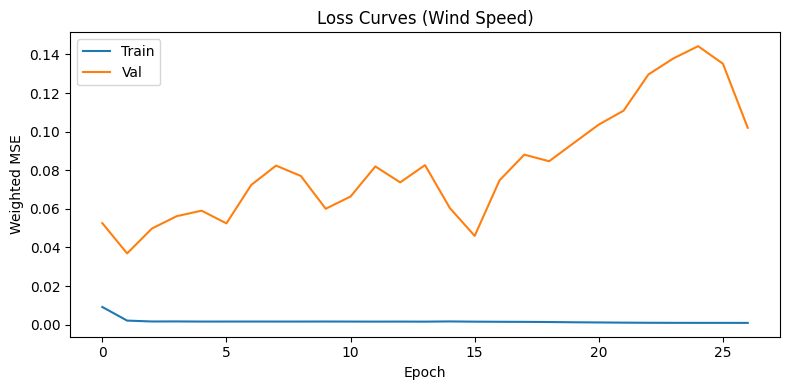

Test Loss (front-weighted MSE): 0.0171

Final Test Metrics (last step, m/s): MSE=8.97, RMSE=2.99, MAE=2.42, MAPE=39.87, R²=-3.8006, Adj R²=-3.8069
Final Test Metrics (full 24h path): RMSE=3.23, MAE=2.50, MAPE=39.94, R²=-14.8055
Hourly-averaged RMSE by lead hour (0→23):
[2.72, 2.78, 2.86, 2.95, 3.04, 3.12, 3.19, 3.26, 3.33, 3.4 , 3.46, 3.48,
 3.5 , 3.51, 3.51, 3.48, 3.46, 3.4 , 3.32, 3.21, 3.12, 3.06, 3.02, 3.  ]
Avg inference latency: 0.61 ms/batch • 0.61 ms/sample


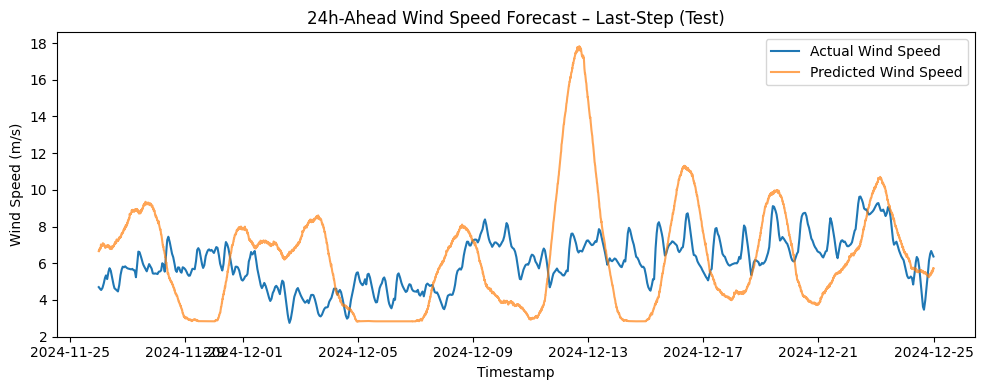

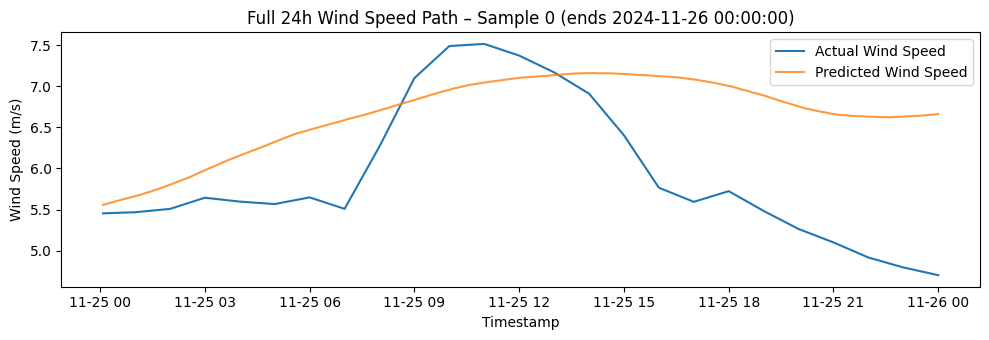

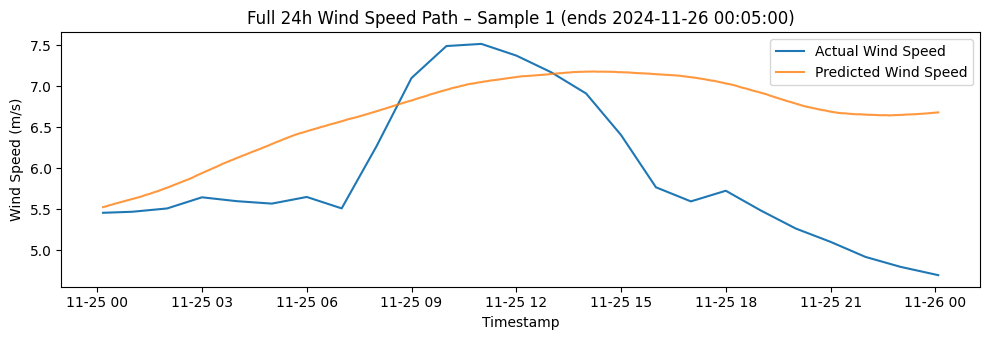

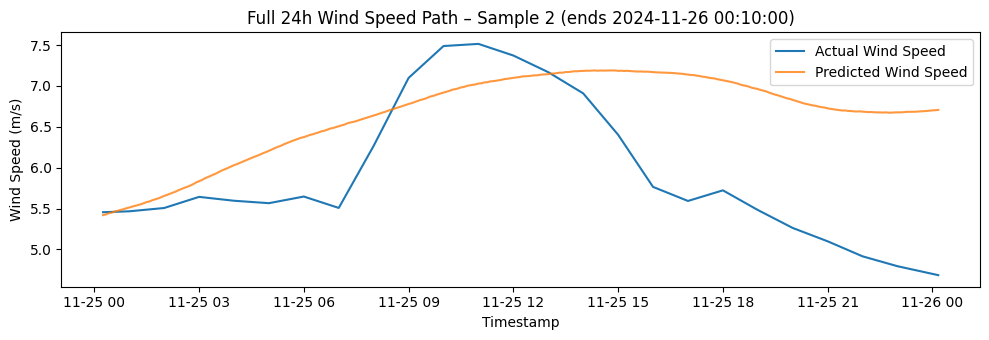

In [7]:
# This one uses centered rolling mean for training, and low frequency = WS50M for validation and testing.

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time, random, math
from typing import List
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1337)

# ----------------------------
# Dataset
# ----------------------------
class LoadWindowDataset(Dataset):
    def __init__(self, data_array, window, horizon):
        self.data = data_array
        self.window, self.horizon = window, horizon
        self.n = data_array.shape[0] - window - horizon + 1
        if self.n <= 0:
            raise ValueError("Window/horizon too large for data length.")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window]                                        # [W, F]
        y_seq = self.data[idx + self.window: idx + self.window + self.horizon, -1:] # [H, 1]
        return torch.from_numpy(x).float(), torch.from_numpy(y_seq).float()

# ----------------------------
# Model
# ----------------------------
class CNN1D_Forecaster(nn.Module):
    def __init__(self, n_features, window, horizon,
                 channels=32, ksize=9, pool=2, p_drop=0.1, hidden=64):
        super().__init__()
        pad = (ksize - 1) // 2
        self.conv = nn.Conv1d(n_features, channels, kernel_size=ksize, padding=pad, bias=True)
        self.pool = nn.AvgPool1d(pool)
        self.bn   = nn.BatchNorm1d(channels)
        self.do   = nn.Dropout(p_drop)

        conv_T = window // pool
        if conv_T <= 0:
            raise ValueError("Pooling/window configuration invalid; pooled length <= 0.")
        self.flat_dim = channels * conv_T

        concat_dim = self.flat_dim + n_features
        self.head = nn.Sequential(
            nn.Linear(concat_dim, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden, horizon)
        )

    def forward(self, x):
        B, W, F = x.shape
        h = self.conv(x.permute(0, 2, 1))  # [B,C,W]
        h = self.pool(h)                   # [B,C,W/p]
        h = self.bn(h)
        h = self.do(h)
        h = h.reshape(B, -1)               # [B, C*(W/p)]
        z = torch.cat([h, x[:, -1, :]], dim=1)  # concat last-step features
        yhat = self.head(z)                     # [B,H]
        return yhat.unsqueeze(-1)               # [B,H,1]

# ----------------------------
# Early Stopping (CPU snapshot)
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=25, delta=1e-4, verbose=True):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.best_loss = np.inf
        self.wait = 0
        self.should_stop = False
        self.best_state = None

    def step(self, val_loss, model=None):
        improved = val_loss < self.best_loss - self.delta
        if improved:
            self.best_loss = val_loss
            self.wait = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: stop after {self.patience} epochs.")
        return improved

# ----------------------------
# Helpers
# ----------------------------
def infer_5min_freq(index: pd.DatetimeIndex) -> pd.Timedelta:
    freq = pd.infer_freq(index)
    if freq is None:
        diffs = pd.Series(index[1:] - index[:-1])
        step = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=5)
    else:
        step = pd.Timedelta(freq)
    if step != pd.Timedelta(minutes=5):
        print(f"[WARN] Detected step={step}. Script assumes 5-minute cadence.")
    return step

def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour + idx.minute/60.0
    hod = hour / 24.0
    dow = idx.dayofweek.astype(float) / 7.0
    doy = (idx.dayofyear.astype(float) - 1.0) / 366.0
    cal = pd.DataFrame(index=idx)
    cal["hod_sin"] = np.sin(2*np.pi*hod); cal["hod_cos"] = np.cos(2*np.pi*hod)
    cal["dow_sin"] = np.sin(2*np.pi*dow); cal["dow_cos"] = np.cos(2*np.pi*dow)
    cal["doy_sin"] = np.sin(2*np.pi*doy); cal["doy_cos"] = np.cos(2*np.pi*doy)
    return cal

def cosine_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / float(warmup_epochs)
        denom = max(float(total_epochs - warmup_epochs), 1.0)
        progress = min(max((epoch - warmup_epochs) / denom, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)
    )

# ----------------------------
# Main
# ----------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset
    df = pd.read_csv(
        'Dataset/Wind/wind_forecasting_final_rolling_mean_7d.csv',
        parse_dates=['DATETIME'],
        index_col='DATETIME'
    ).copy()

    # Target column
    target_col = 'WS50M'
    df['TARGET'] = df[target_col]

    # ----------------------------
    # Compute both centered and causal low-frequency columns
    # - centered (peeks into future): center=True -> used only for training rows
    # - causal  (past only): center=False -> used for val/test rows (no leakage)
    # ----------------------------
    roll_window = 2016  # ~7 days at 5-min cadence
    df['WS50M_low_freq_centered'] = df['WS50M'].rolling(window=roll_window, min_periods=1, center=True).mean()
    df['WS50M_low_freq_causal']  = df['WS50M'].rolling(window=roll_window, min_periods=1, center=False).mean()

    # ----------------------------
    # Splits (you had these dates)
    # ----------------------------
    train_end = pd.Timestamp('2023-12-25 23:55:00')
    val_end   = pd.Timestamp('2024-11-25 23:55:00')

    # We'll create the column `WS50M_low_freq_7d` such that:
    # - for training rows (<= train_end) it equals the centered version (gives training benefit)
    # - for val/test rows (> train_end) it equals the causal version (no future peek)
    df['WS50M_low_freq_7d'] = df['WS50M_low_freq_centered'].copy()
    df.loc[df.index > train_end, 'WS50M_low_freq_7d'] = df.loc[df.index > train_end, 'WS50M']

    # Optionally drop intermediate columns to keep df tidy (but not necessary)
    df.drop(columns=['WS50M_low_freq_centered', 'WS50M_low_freq_causal'], inplace=True)

    # --- Use all the features you already have ---
    # Drop target from the features so it's only in TARGET
    feature_cols = [c for c in df.columns if c not in ['TARGET', target_col]]

    X_exo = df[feature_cols].copy()

    # Handle inf/nan
    X_exo.replace([np.inf, -np.inf], np.nan, inplace=True)
    finite_rows = np.isfinite(X_exo.to_numpy()).all(axis=1)
    finite_target = np.isfinite(df['TARGET'].to_numpy())
    valid_mask = finite_rows & finite_target

    df    = df.loc[valid_mask].copy()
    X_exo = X_exo.loc[valid_mask].copy()

    # Window end timestamps
    W = 7 * 24 * 12   # lookback (7 days)
    H = 1 * 24 * 12   # horizon (24h)
    times = df.index[W + H - 1 :]

    print(df.head())
    
    # --- Scaling ---
    train_mask_for_scaler = df.index <= train_end
    feat_scaler = MinMaxScaler()
    # NOTE: scaler fitted on training rows (which include centered low_freq for those rows)
    feat_scaler.fit(X_exo.loc[train_mask_for_scaler])
    X_feats_scaled = feat_scaler.transform(X_exo)

    tgt_scaler = MinMaxScaler()
    tgt_scaler.fit(df.loc[train_mask_for_scaler, ['TARGET']])
    y_scaled = tgt_scaler.transform(df[['TARGET']])

    # Final array (features + target)
    data = np.hstack([X_feats_scaled, y_scaled])
    n_features = data.shape[1]  # all features + target

    # ----------------------------
    # Indexing with optional stride (speeds up training)
    # ----------------------------
    stride = 6  # Smaller stride for wind data (changes faster)
    all_idx = np.arange(len(times))
    train_idx = all_idx[times <= train_end][::stride]
    val_idx   = all_idx[(times > train_end) & (times <= val_end)][::stride]
    test_idx  = all_idx[times > val_end]

    print(f"Train windows: {len(train_idx)}, Validation windows: {len(val_idx)}, Test windows: {len(test_idx)}")
    if len(times) > 0:
        print(f"First window ts: {times.min()}, Last: {times.max()}")
    assert len(train_idx) > 0, "No training windows found—check train_end vs. data coverage"
    assert len(val_idx) > 0, "No validation windows found—check val_end vs. data coverage"
    assert len(test_idx) > 0, "No test windows found—does your data extend past val_end?"

    # Datasets / Loaders
    full_ds = LoadWindowDataset(data, W, H)
    train_ds = Subset(full_ds, train_idx)
    val_ds   = Subset(full_ds, val_idx)
    test_ds  = Subset(full_ds, test_idx)

    pin = (device.type == 'cuda')
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)

    # ----------------------------
    # Model + optimizer + loss + scheduler
    # ----------------------------
    model = CNN1D_Forecaster(
        n_features=n_features, window=W, horizon=H,
        channels=64, ksize=9, pool=2, p_drop=0.2, hidden=128
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    es = EarlyStopping(patience=25, delta=1e-4, verbose=True)

    # Weighted loss for wind forecasting (emphasize short-term accuracy)
    weights = torch.linspace(1.5, 0.5, steps=H, device=device).view(1, H, 1)
    def weighted_mse(pred, target):
        return ((weights * (pred - target) ** 2).mean())
    f_fn = weighted_mse

    total_epochs = 100
    warmup_epochs = 20
    sched = cosine_warmup_scheduler(opt, warmup_epochs, total_epochs)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of parameters:", n_params)

    train_losses, val_losses = [], []

    # ----------------------------
    # Training Loop
    # ----------------------------
    for ep in range(1, total_epochs + 1):
        t0 = time.time()
        model.train()
        tl = 0.0
        for Xb, Yseqb in train_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            loss = f_fn(yhat, Yseqb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
        train_losses.append(tl / len(train_ds))

        # Validation
        model.eval()
        vl, preds_last_scaled, truths_last_scaled = 0.0, [], []
        preds_full_scaled, truths_full_scaled = [], []
        with torch.no_grad():
            for Xb, Yseqb in val_loader:
                Xb, Yseqb = Xb.to(device), Yseqb.to(device)
                yhat = model(Xb)
                vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
                preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
                truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
                preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
                truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
        val_loss = vl / len(val_ds)
        val_losses.append(val_loss)

        # step LR ONCE PER EPOCH
        sched.step()

        # Inverse metrics
        preds = np.concatenate(preds_last_scaled)
        truths = np.concatenate(truths_last_scaled)
        inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
        inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]
        rm  = root_mean_squared_error(inv_t, inv_p)
        mae = mean_absolute_error(inv_t, inv_p)
        r2  = r2_score(inv_t, inv_p)
        mape = smape(inv_t, inv_p)

        pf = np.concatenate(preds_full_scaled, axis=0)
        tf = np.concatenate(truths_full_scaled, axis=0)
        inv_pf = tgt_scaler.inverse_transform(pf.reshape(-1,1))[:,0]
        inv_tf = tgt_scaler.inverse_transform(tf.reshape(-1,1))[:,0]
        rm_all  = root_mean_squared_error(inv_tf, inv_pf)
        mae_all = mean_absolute_error(inv_tf, inv_pf)
        r2_all  = r2_score(inv_tf, inv_pf)
        mape_all = smape(inv_tf, inv_pf)

        cur_lr = opt.param_groups[0]['lr']
        print(f"Ep{ep:02d} Train={train_losses[-1]:.4f} | Val={val_loss:.4f} | "
              f"Val(last) RMSE={rm:.1f} MAE={mae:.1f} MAPE={mape:.2f}% R²={r2:.3f} | "
              f"Val(full) RMSE={rm_all:.1f} MAE={mae_all:.1f} MAPE={mape_all:.2f}% R²={r2_all:.3f} | "
              f"LR={cur_lr:.6f} | Time={time.time()-t0:.1f}s")

        _ = es.step(val_loss, model=model)
        if es.should_stop:
            if es.best_state is not None:
                model.load_state_dict(es.best_state)
                if es.verbose:
                    print("EarlyStopping: best weights restored.")
            break

    # ----------------------------
    # Loss curves
    # ----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Weighted MSE'); plt.legend(); plt.title('Loss Curves (Wind Speed)')
    plt.tight_layout(); plt.show()

    # ----------------------------
    # Testing
    # ----------------------------
    model.eval()
    preds_last_scaled, truths_last_scaled = [], []
    preds_full_scaled, truths_full_scaled = [], []
    test_vl = 0.0
    with torch.no_grad():
        for Xb, Yseqb in test_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            test_vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
            preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
            truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
            preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
            truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
    test_loss = test_vl / len(test_ds)

    preds = np.concatenate(preds_last_scaled)
    truths = np.concatenate(truths_last_scaled)
    inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
    inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]

    mse = mean_squared_error(inv_t, inv_p)
    rm  = root_mean_squared_error(inv_t, inv_p)
    mae = mean_absolute_error(inv_t, inv_p)
    mape = smape(inv_t, inv_p)
    r2  = r2_score(inv_t, inv_p)
    n, p = len(inv_t), (n_features - 1)
    adj_r2 = 1 - (1-r2)*(n-1)/max(n-p-1, 1)

    PH = np.concatenate(preds_full_scaled, axis=0)
    TH = np.concatenate(truths_full_scaled, axis=0)
    inv_pf = tgt_scaler.inverse_transform(PH.reshape(-1,1))[:,0]
    inv_tf = tgt_scaler.inverse_transform(TH.reshape(-1,1))[:,0]
    rm_all  = root_mean_squared_error(inv_tf, inv_pf)
    mae_all = mean_absolute_error(inv_tf, inv_pf)
    mape_all = smape(inv_tf, inv_pf)

    # Per-lead RMSE (hourly average over 24h)
    lead_rmse = []
    for h in range(PH.shape[1]):
        inv_ph = tgt_scaler.inverse_transform(PH[:, h].reshape(-1,1))[:,0]
        inv_th = tgt_scaler.inverse_transform(TH[:, h].reshape(-1,1))[:,0]
        lead_rmse.append(root_mean_squared_error(inv_th, inv_ph))
    hourly_rmse = np.array(lead_rmse).reshape(-1, 12).mean(axis=1)

    print(f"Test Loss (front-weighted MSE): {test_loss:.4f}")
    print(f"\nFinal Test Metrics (last step, m/s): "
          f"MSE={mse:.2f}, RMSE={rm:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}")
    print(f"Final Test Metrics (full 24h path): RMSE={rm_all:.2f}, MAE={mae_all:.2f}, MAPE={mape_all:.2f}, R²={r2_all:.4f}")
    print("Hourly-averaged RMSE by lead hour (0→23):")
    print(np.array2string(hourly_rmse, precision=2, separator=', '))

    # Inference latency (batch=1)
    _ = model(torch.randn(1, W, n_features).to(device))
    if device.type == 'cuda':
        torch.cuda.synchronize()
    Nruns = 100
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    total_time = 0.0
    with torch.no_grad():
        for _ in range(Nruns):
            inp = torch.randn(1, W, n_features).to(device)
            start.record(); _ = model(inp); end.record()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            total_time += start.elapsed_time(end) / 1000.0
    avg_batch = total_time / Nruns
    print(f"Avg inference latency: {avg_batch*1000:.2f} ms/batch • {avg_batch*1000:.2f} ms/sample")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(times[test_idx], inv_t, label='Actual Wind Speed')
    plt.plot(times[test_idx], inv_p, label='Predicted Wind Speed', alpha=0.7)
    plt.title("24h-Ahead Wind Speed Forecast – Last-Step (Test)")
    plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Show sample forecasts
    num_show = min(3, len(test_idx))
    if num_show > 0:
        Xb, Yseqb = next(iter(DataLoader(test_ds, batch_size=num_show, shuffle=False)))
        Xb = Xb.to(device)
        with torch.no_grad():
            yhat = model(Xb).cpu().numpy()
        ytrue = Yseqb.numpy()
        for i in range(min(num_show, Xb.size(0))):
            pred_i = tgt_scaler.inverse_transform(yhat[i, :, 0].reshape(-1,1))[:,0]
            true_i = tgt_scaler.inverse_transform(ytrue[i, :, 0].reshape(-1,1))[:,0]
            end_ts = times[test_idx[i]]
            tgrid = pd.date_range(end=end_ts, periods=H, freq='5min')
            plt.figure(figsize=(10,3.5))
            plt.plot(tgrid, true_i, label='Actual Wind Speed')
            plt.plot(tgrid, pred_i, label='Predicted Wind Speed', alpha=0.8)
            plt.title(f"Full 24h Wind Speed Path – Sample {i} (ends {end_ts})")
            plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
            plt.legend(); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()

Train windows: 174913, Validation windows: 16128, Test windows: 8352
First window ts: 2014-01-02 23:55:00, Last: 2024-12-24 23:55:00
No. of parameters: 8303456
Ep01 Train=0.0092 | Val=0.0023 | Val(last) RMSE=1.3 MAE=1.0 MAPE=24.09% R²=0.609 | Val(full) RMSE=1.2 MAE=0.9 MAPE=24.02% R²=0.655 | LR=0.000050 | Time=39.9s
Ep02 Train=0.0021 | Val=0.0011 | Val(last) RMSE=1.0 MAE=0.8 MAPE=20.16% R²=0.742 | Val(full) RMSE=0.8 MAE=0.6 MAPE=17.18% R²=0.830 | LR=0.000075 | Time=37.3s
Ep03 Train=0.0016 | Val=0.0011 | Val(last) RMSE=1.0 MAE=0.8 MAPE=19.89% R²=0.761 | Val(full) RMSE=0.8 MAE=0.6 MAPE=17.11% R²=0.836 | LR=0.000100 | Time=41.2s
Ep04 Train=0.0017 | Val=0.0011 | Val(last) RMSE=1.0 MAE=0.8 MAPE=20.16% R²=0.746 | Val(full) RMSE=0.8 MAE=0.6 MAPE=17.24% R²=0.830 | LR=0.000125 | Time=38.5s
Ep05 Train=0.0016 | Val=0.0011 | Val(last) RMSE=1.1 MAE=0.8 MAPE=20.77% R²=0.724 | Val(full) RMSE=0.8 MAE=0.6 MAPE=17.20% R²=0.831 | LR=0.000150 | Time=38.4s
Ep06 Train=0.0016 | Val=0.0016 | Val(last) RMSE=1.

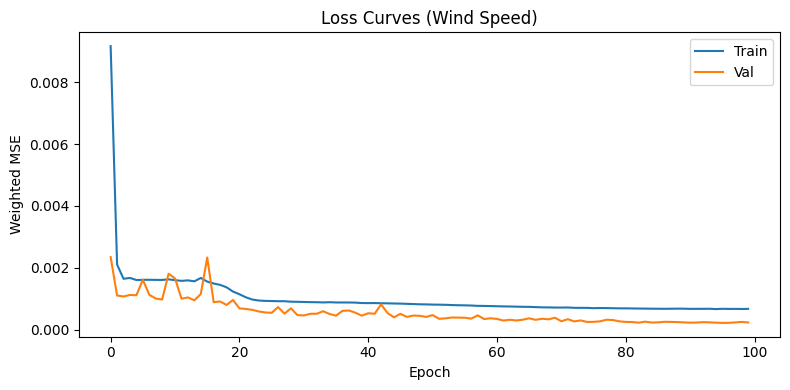

Test Loss (front-weighted MSE): 0.0049

Final Test Metrics (last step, m/s): MSE=2.88, RMSE=1.70, MAE=1.32, MAPE=23.65, R²=-0.5416, Adj R²=-0.5436
Final Test Metrics (full 24h path): RMSE=1.75, MAE=1.32, MAPE=23.83, R²=0.9636
Hourly-averaged RMSE by lead hour (0→23):
[1.03, 1.13, 1.27, 1.44, 1.6 , 1.75, 1.86, 1.94, 1.98, 1.99, 1.98, 1.95,
 1.92, 1.88, 1.85, 1.83, 1.82, 1.81, 1.8 , 1.78, 1.76, 1.73, 1.71, 1.7 ]
Avg inference latency: 0.42 ms/batch • 0.42 ms/sample


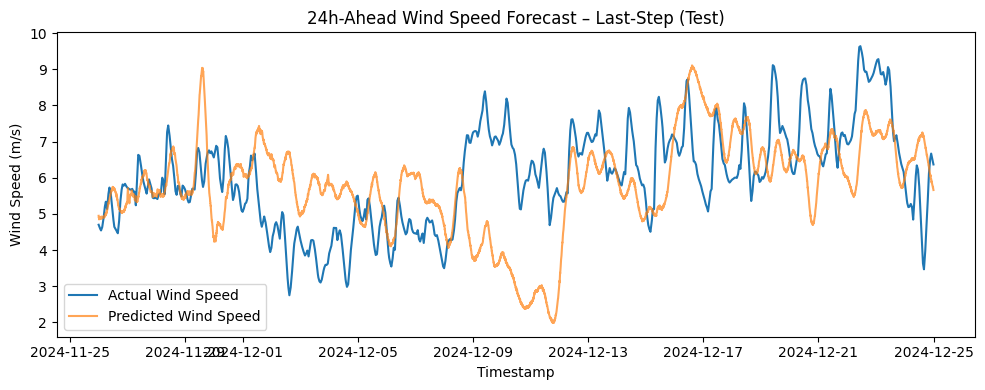

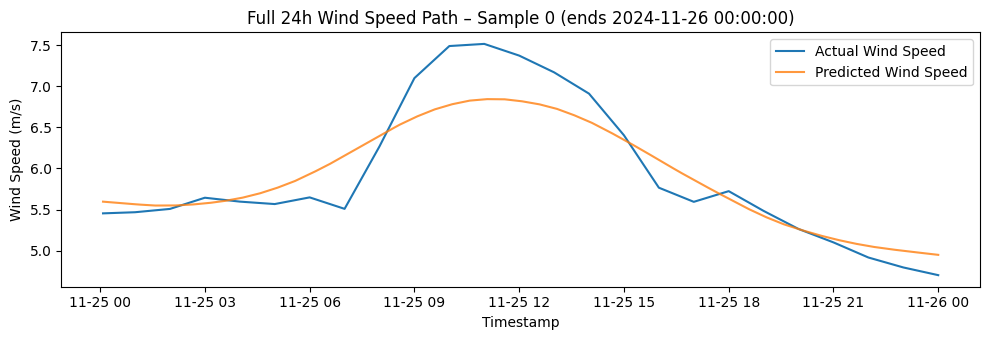

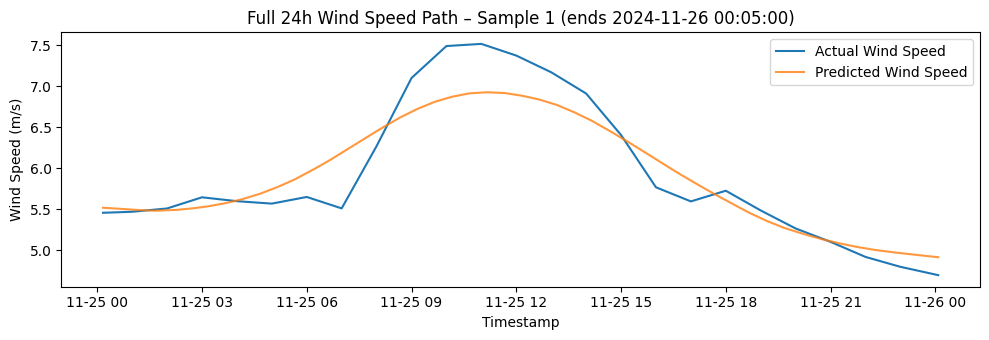

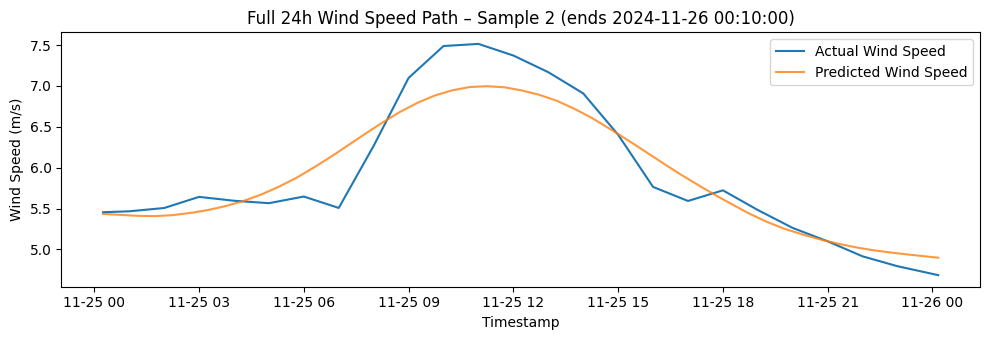

In [8]:
# this one uses centered rolling mean for training and validation, and causal for testing.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time, random, math
from typing import List
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1337)

# ----------------------------
# Dataset
# ----------------------------
class LoadWindowDataset(Dataset):
    def __init__(self, data_array, window, horizon):
        self.data = data_array
        self.window, self.horizon = window, horizon
        self.n = data_array.shape[0] - window - horizon + 1
        if self.n <= 0:
            raise ValueError("Window/horizon too large for data length.")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window]                                        # [W, F]
        y_seq = self.data[idx + self.window: idx + self.window + self.horizon, -1:] # [H, 1]
        return torch.from_numpy(x).float(), torch.from_numpy(y_seq).float()

# ----------------------------
# Model
# ----------------------------
class CNN1D_Forecaster(nn.Module):
    def __init__(self, n_features, window, horizon,
                 channels=32, ksize=9, pool=2, p_drop=0.1, hidden=64):
        super().__init__()
        pad = (ksize - 1) // 2
        self.conv = nn.Conv1d(n_features, channels, kernel_size=ksize, padding=pad, bias=True)
        self.pool = nn.AvgPool1d(pool)
        self.bn   = nn.BatchNorm1d(channels)
        self.do   = nn.Dropout(p_drop)

        conv_T = window // pool
        if conv_T <= 0:
            raise ValueError("Pooling/window configuration invalid; pooled length <= 0.")
        self.flat_dim = channels * conv_T

        concat_dim = self.flat_dim + n_features
        self.head = nn.Sequential(
            nn.Linear(concat_dim, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden, horizon)
        )

    def forward(self, x):
        B, W, F = x.shape
        h = self.conv(x.permute(0, 2, 1))  # [B,C,W]
        h = self.pool(h)                   # [B,C,W/p]
        h = self.bn(h)
        h = self.do(h)
        h = h.reshape(B, -1)               # [B, C*(W/p)]
        z = torch.cat([h, x[:, -1, :]], dim=1)  # concat last-step features
        yhat = self.head(z)                     # [B,H]
        return yhat.unsqueeze(-1)               # [B,H,1]

# ----------------------------
# Early Stopping (CPU snapshot)
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=25, delta=1e-4, verbose=True):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.best_loss = np.inf
        self.wait = 0
        self.should_stop = False
        self.best_state = None

    def step(self, val_loss, model=None):
        improved = val_loss < self.best_loss - self.delta
        if improved:
            self.best_loss = val_loss
            self.wait = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: stop after {self.patience} epochs.")
        return improved

# ----------------------------
# Helpers
# ----------------------------
def infer_5min_freq(index: pd.DatetimeIndex) -> pd.Timedelta:
    freq = pd.infer_freq(index)
    if freq is None:
        diffs = pd.Series(index[1:] - index[:-1])
        step = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=5)
    else:
        step = pd.Timedelta(freq)
    if step != pd.Timedelta(minutes=5):
        print(f"[WARN] Detected step={step}. Script assumes 5-minute cadence.")
    return step

def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour + idx.minute/60.0
    hod = hour / 24.0
    dow = idx.dayofweek.astype(float) / 7.0
    doy = (idx.dayofyear.astype(float) - 1.0) / 366.0
    cal = pd.DataFrame(index=idx)
    cal["hod_sin"] = np.sin(2*np.pi*hod); cal["hod_cos"] = np.cos(2*np.pi*hod)
    cal["dow_sin"] = np.sin(2*np.pi*dow); cal["dow_cos"] = np.cos(2*np.pi*dow)
    cal["doy_sin"] = np.sin(2*np.pi*doy); cal["doy_cos"] = np.cos(2*np.pi*doy)
    return cal

def cosine_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / float(warmup_epochs)
        denom = max(float(total_epochs - warmup_epochs), 1.0)
        progress = min(max((epoch - warmup_epochs) / denom, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)
    )

# ----------------------------
# Main
# ----------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset (the CSV that already contains WS50M_low_freq_7d may be overridden below)
    df = pd.read_csv(
        'Dataset/Wind/wind_forecasting_final_rolling_mean_7d.csv',
        parse_dates=['DATETIME'],
        index_col='DATETIME'
    ).copy()

    # Target column
    target_col = 'WS50M'
    df['TARGET'] = df[target_col]

    # ----------------------------
    # Splits (you had these dates)
    # ----------------------------
    train_end = pd.Timestamp('2023-12-25 23:55:00')
    val_end   = pd.Timestamp('2024-11-25 23:55:00')

    # ----------------------------
    # Create both centered and causal low-frequency columns,
    # then set WS50M_low_freq_7d = centered for train+val (<= val_end),
    # and = causal for test (> val_end)
    # ----------------------------
    roll_window = 2016  # ~7 days at 5-min cadence
    # centered uses future points within window
    df['WS50M_low_freq_centered'] = df['WS50M'].rolling(window=roll_window, min_periods=1, center=True).mean()
    # causal uses only past points
    df['WS50M_low_freq_causal']  = df['WS50M'].rolling(window=roll_window, min_periods=1, center=False).mean()

    # Overwrite the working feature so train+val get centered, test gets causal
    df['WS50M_low_freq_7d'] = df['WS50M_low_freq_centered'].copy()
    df.loc[df.index > val_end, 'WS50M_low_freq_7d'] = df.loc[df.index > val_end, 'WS50M_low_freq_causal']

    # drop helper cols to keep df tidy
    df.drop(columns=['WS50M_low_freq_centered', 'WS50M_low_freq_causal'], inplace=True)

    # --- Use all the features you already have ---
    # Drop target from the features so it's only in TARGET
    feature_cols = [c for c in df.columns if c not in ['TARGET', target_col]]

    X_exo = df[feature_cols].copy()

    # Handle inf/nan
    X_exo.replace([np.inf, -np.inf], np.nan, inplace=True)
    finite_rows = np.isfinite(X_exo.to_numpy()).all(axis=1)
    finite_target = np.isfinite(df['TARGET'].to_numpy())
    valid_mask = finite_rows & finite_target

    df    = df.loc[valid_mask].copy()
    X_exo = X_exo.loc[valid_mask].copy()

    # Window end timestamps
    W = 7 * 24 * 12   # lookback
    H = 1 * 24 * 12   # horizon
    times = df.index[W + H - 1 :]

    # --- Scaling ---
    train_mask_for_scaler = df.index <= train_end
    feat_scaler = MinMaxScaler()
    feat_scaler.fit(X_exo.loc[train_mask_for_scaler])
    X_feats_scaled = feat_scaler.transform(X_exo)

    tgt_scaler = MinMaxScaler()
    tgt_scaler.fit(df.loc[train_mask_for_scaler, ['TARGET']])
    y_scaled = tgt_scaler.transform(df[['TARGET']])

    # Final array
    data = np.hstack([X_feats_scaled, y_scaled])
    n_features = data.shape[1]  # all features + target

    # ----------------------------
    # Indexing with optional stride (speeds up training)
    # ----------------------------
    stride = 6  # Smaller stride for wind data (changes faster)
    all_idx = np.arange(len(times))
    train_idx = all_idx[times <= train_end][::stride]
    val_idx   = all_idx[(times > train_end) & (times <= val_end)][::stride]
    test_idx  = all_idx[times > val_end]

    print(f"Train windows: {len(train_idx)}, Validation windows: {len(val_idx)}, Test windows: {len(test_idx)}")
    if len(times) > 0:
        print(f"First window ts: {times.min()}, Last: {times.max()}")
    assert len(train_idx) > 0, "No training windows found—check train_end vs. data coverage"
    assert len(val_idx) > 0, "No validation windows found—check val_end vs. data coverage"
    assert len(test_idx) > 0, "No test windows found—does your data extend past val_end?"

    # Datasets / Loaders
    full_ds = LoadWindowDataset(data, W, H)
    train_ds = Subset(full_ds, train_idx)
    val_ds   = Subset(full_ds, val_idx)
    test_ds  = Subset(full_ds, test_idx)

    pin = (device.type == 'cuda')
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)

    # ----------------------------
    # Model + optimizer + loss + scheduler
    # ----------------------------
    model = CNN1D_Forecaster(
        n_features=n_features, window=W, horizon=H,
        channels=64, ksize=9, pool=2, p_drop=0.2, hidden=128
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    es = EarlyStopping(patience=25, delta=1e-4, verbose=True)

    # Weighted loss for wind forecasting (emphasize short-term accuracy)
    weights = torch.linspace(1.5, 0.5, steps=H, device=device).view(1, H, 1)
    def weighted_mse(pred, target):
        return ((weights * (pred - target) ** 2).mean())
    f_fn = weighted_mse

    total_epochs = 100
    warmup_epochs = 20
    sched = cosine_warmup_scheduler(opt, warmup_epochs, total_epochs)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of parameters:", n_params)

    train_losses, val_losses = [], []

    # ----------------------------
    # Training Loop
    # ----------------------------
    for ep in range(1, total_epochs + 1):
        t0 = time.time()
        model.train()
        tl = 0.0
        for Xb, Yseqb in train_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            loss = f_fn(yhat, Yseqb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
        train_losses.append(tl / len(train_ds))

        # Validation
        model.eval()
        vl, preds_last_scaled, truths_last_scaled = 0.0, [], []
        preds_full_scaled, truths_full_scaled = [], []
        with torch.no_grad():
            for Xb, Yseqb in val_loader:
                Xb, Yseqb = Xb.to(device), Yseqb.to(device)
                yhat = model(Xb)
                vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
                preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
                truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
                preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
                truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
        val_loss = vl / len(val_ds)
        val_losses.append(val_loss)

        # step LR ONCE PER EPOCH
        sched.step()

        # Inverse metrics
        preds = np.concatenate(preds_last_scaled)
        truths = np.concatenate(truths_last_scaled)
        inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
        inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]
        rm  = root_mean_squared_error(inv_t, inv_p)
        mae = mean_absolute_error(inv_t, inv_p)
        r2  = r2_score(inv_t, inv_p)
        mape = smape(inv_t, inv_p)

        pf = np.concatenate(preds_full_scaled, axis=0)
        tf = np.concatenate(truths_full_scaled, axis=0)
        inv_pf = tgt_scaler.inverse_transform(pf.reshape(-1,1))[:,0]
        inv_tf = tgt_scaler.inverse_transform(tf.reshape(-1,1))[:,0]
        rm_all  = root_mean_squared_error(inv_tf, inv_pf)
        mae_all = mean_absolute_error(inv_tf, inv_pf)
        r2_all  = r2_score(inv_tf, inv_pf)
        mape_all = smape(inv_tf, inv_pf)

        cur_lr = opt.param_groups[0]['lr']
        print(f"Ep{ep:02d} Train={train_losses[-1]:.4f} | Val={val_loss:.4f} | "
              f"Val(last) RMSE={rm:.1f} MAE={mae:.1f} MAPE={mape:.2f}% R²={r2:.3f} | "
              f"Val(full) RMSE={rm_all:.1f} MAE={mae_all:.1f} MAPE={mape_all:.2f}% R²={r2_all:.3f} | "
              f"LR={cur_lr:.6f} | Time={time.time()-t0:.1f}s")

        _ = es.step(val_loss, model=model)
        if es.should_stop:
            if es.best_state is not None:
                model.load_state_dict(es.best_state)
                if es.verbose:
                    print("EarlyStopping: best weights restored.")
            break

    # ----------------------------
    # Loss curves
    # ----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Weighted MSE'); plt.legend(); plt.title('Loss Curves (Wind Speed)')
    plt.tight_layout(); plt.show()

    # ----------------------------
    # Testing
    # ----------------------------
    model.eval()
    preds_last_scaled, truths_last_scaled = [], []
    preds_full_scaled, truths_full_scaled = [], []
    test_vl = 0.0
    with torch.no_grad():
        for Xb, Yseqb in test_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            test_vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
            preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
            truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
            preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
            truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
    test_loss = test_vl / len(test_ds)

    preds = np.concatenate(preds_last_scaled)
    truths = np.concatenate(truths_last_scaled)
    inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
    inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]

    mse = mean_squared_error(inv_t, inv_p)
    rm  = root_mean_squared_error(inv_t, inv_p)
    mae = mean_absolute_error(inv_t, inv_p)
    mape = smape(inv_t, inv_p)
    r2  = r2_score(inv_t, inv_p)
    n, p = len(inv_t), (n_features - 1)
    adj_r2 = 1 - (1-r2)*(n-1)/max(n-p-1, 1)

    PH = np.concatenate(preds_full_scaled, axis=0)
    TH = np.concatenate(truths_full_scaled, axis=0)
    inv_pf = tgt_scaler.inverse_transform(PH.reshape(-1,1))[:,0]
    inv_tf = tgt_scaler.inverse_transform(TH.reshape(-1,1))[:,0]
    rm_all  = root_mean_squared_error(inv_tf, inv_pf)
    mae_all = mean_absolute_error(inv_tf, inv_pf)
    mape_all = smape(inv_tf, inv_pf)

    # Per-lead RMSE (hourly average over 24h)
    lead_rmse = []
    for h in range(PH.shape[1]):
        inv_ph = tgt_scaler.inverse_transform(PH[:, h].reshape(-1,1))[:,0]
        inv_th = tgt_scaler.inverse_transform(TH[:, h].reshape(-1,1))[:,0]
        lead_rmse.append(root_mean_squared_error(inv_th, inv_ph))
    hourly_rmse = np.array(lead_rmse).reshape(-1, 12).mean(axis=1)

    print(f"Test Loss (front-weighted MSE): {test_loss:.4f}")
    print(f"\nFinal Test Metrics (last step, m/s): "
          f"MSE={mse:.2f}, RMSE={rm:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}")
    print(f"Final Test Metrics (full 24h path): RMSE={rm_all:.2f}, MAE={mae_all:.2f}, MAPE={mape_all:.2f}, R²={r2_all:.4f}")
    print("Hourly-averaged RMSE by lead hour (0→23):")
    print(np.array2string(hourly_rmse, precision=2, separator=', '))

    # Inference latency (batch=1)
    _ = model(torch.randn(1, W, n_features).to(device))
    if device.type == 'cuda':
        torch.cuda.synchronize()
    Nruns = 100
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    total_time = 0.0
    with torch.no_grad():
        for _ in range(Nruns):
            inp = torch.randn(1, W, n_features).to(device)
            start.record(); _ = model(inp); end.record()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            total_time += start.elapsed_time(end) / 1000.0
    avg_batch = total_time / Nruns
    print(f"Avg inference latency: {avg_batch*1000:.2f} ms/batch • {avg_batch*1000:.2f} ms/sample")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(times[test_idx], inv_t, label='Actual Wind Speed')
    plt.plot(times[test_idx], inv_p, label='Predicted Wind Speed', alpha=0.7)
    plt.title("24h-Ahead Wind Speed Forecast – Last-Step (Test)")
    plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Show sample forecasts
    num_show = min(3, len(test_idx))
    if num_show > 0:
        Xb, Yseqb = next(iter(DataLoader(test_ds, batch_size=num_show, shuffle=False)))
        Xb = Xb.to(device)
        with torch.no_grad():
            yhat = model(Xb).cpu().numpy()
        ytrue = Yseqb.numpy()
        for i in range(min(num_show, Xb.size(0))):
            pred_i = tgt_scaler.inverse_transform(yhat[i, :, 0].reshape(-1,1))[:,0]
            true_i = tgt_scaler.inverse_transform(ytrue[i, :, 0].reshape(-1,1))[:,0]
            end_ts = times[test_idx[i]]
            tgrid = pd.date_range(end=end_ts, periods=H, freq='5min')
            plt.figure(figsize=(10,3.5))
            plt.plot(tgrid, true_i, label='Actual Wind Speed')
            plt.plot(tgrid, pred_i, label='Predicted Wind Speed', alpha=0.8)
            plt.title(f"Full 24h Wind Speed Path – Sample {i} (ends {end_ts})")
            plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
            plt.legend(); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()


Train windows: 174913, Validation windows: 16128, Test windows: 8352
First window ts: 2014-01-02 23:55:00, Last: 2024-12-24 23:55:00
No. of parameters: 8303456
Ep01 Train=0.0092 | Val=0.0023 | Val(last) RMSE=1.3 MAE=1.0 MAPE=24.09% R²=0.609 | Val(full) RMSE=1.2 MAE=0.9 MAPE=24.02% R²=0.655 | LR=0.000050 | Time=38.3s
Ep02 Train=0.0021 | Val=0.0011 | Val(last) RMSE=1.0 MAE=0.8 MAPE=20.16% R²=0.742 | Val(full) RMSE=0.8 MAE=0.6 MAPE=17.18% R²=0.830 | LR=0.000075 | Time=37.4s
Ep03 Train=0.0016 | Val=0.0011 | Val(last) RMSE=1.0 MAE=0.8 MAPE=19.89% R²=0.761 | Val(full) RMSE=0.8 MAE=0.6 MAPE=17.11% R²=0.836 | LR=0.000100 | Time=38.5s
Ep04 Train=0.0017 | Val=0.0011 | Val(last) RMSE=1.0 MAE=0.8 MAPE=20.16% R²=0.746 | Val(full) RMSE=0.8 MAE=0.6 MAPE=17.24% R²=0.830 | LR=0.000125 | Time=36.4s
Ep05 Train=0.0016 | Val=0.0011 | Val(last) RMSE=1.1 MAE=0.8 MAPE=20.77% R²=0.724 | Val(full) RMSE=0.8 MAE=0.6 MAPE=17.20% R²=0.831 | LR=0.000150 | Time=37.4s
Ep06 Train=0.0016 | Val=0.0016 | Val(last) RMSE=1.

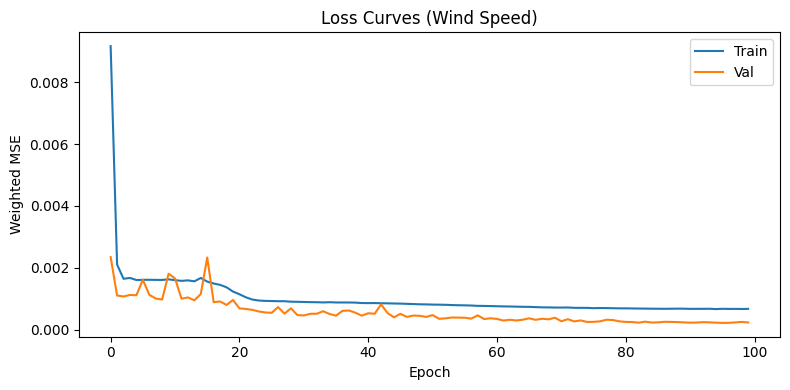

Test Loss (front-weighted MSE): 0.3007

Final Test Metrics (last step, m/s): MSE=178.61, RMSE=13.36, MAE=10.09, MAPE=106.81, R²=-94.6198, Adj R²=-94.7459
Final Test Metrics (full 24h path): RMSE=13.48, MAE=9.82, MAPE=102.85, R²=0.9636
Hourly-averaged RMSE by lead hour (0→23):
[ 8.64,  9.84, 11.4 , 13.07, 14.52, 15.47, 15.87, 15.71, 15.21, 14.6 ,
 14.01, 13.59, 13.36, 13.18, 12.96, 12.79, 12.76, 12.89, 13.16, 13.43,
 13.64, 13.73, 13.71, 13.5 ]
Avg inference latency: 0.86 ms/batch • 0.86 ms/sample


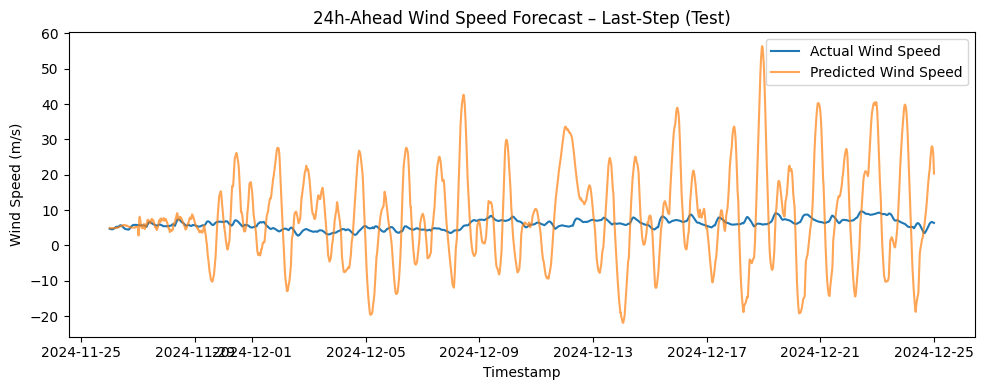

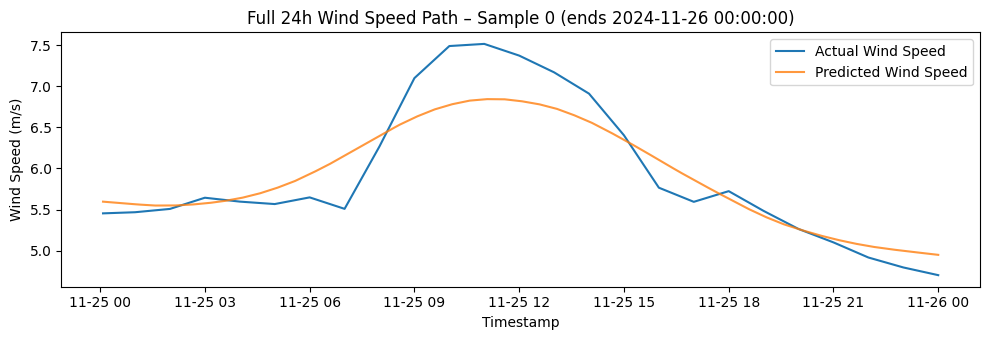

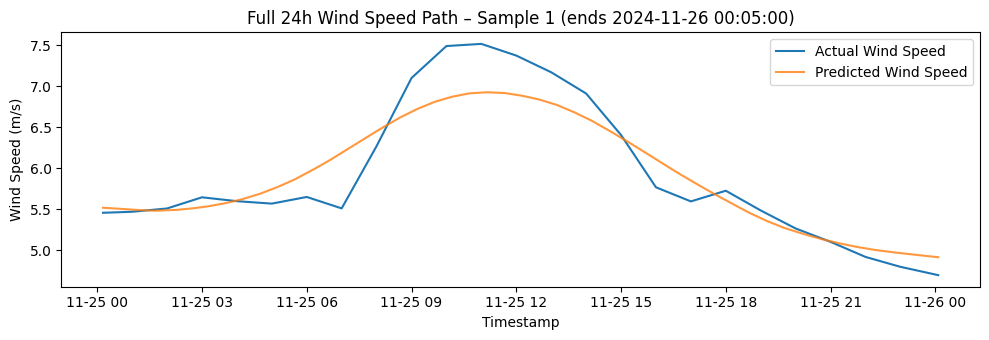

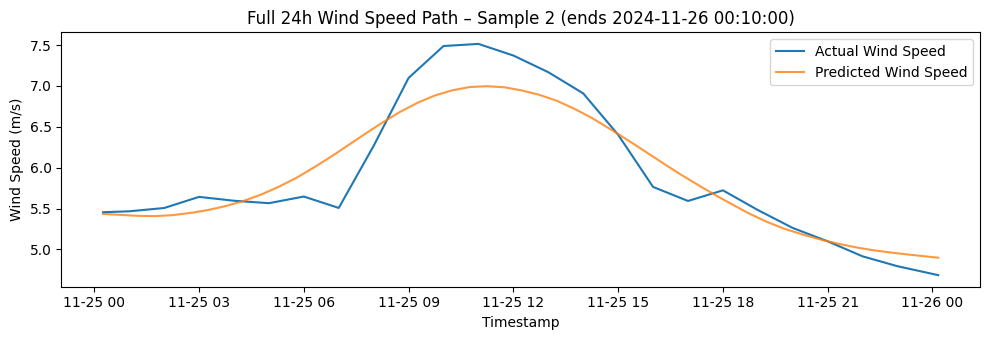

In [13]:
# this one uses centered rolling mean for training and validation, and WS50M for testing.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time, random, math
from typing import List
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1337)

# ----------------------------
# Dataset
# ----------------------------
class LoadWindowDataset(Dataset):
    def __init__(self, data_array, window, horizon):
        self.data = data_array
        self.window, self.horizon = window, horizon
        self.n = data_array.shape[0] - window - horizon + 1
        if self.n <= 0:
            raise ValueError("Window/horizon too large for data length.")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window]                                        # [W, F]
        y_seq = self.data[idx + self.window: idx + self.window + self.horizon, -1:] # [H, 1]
        return torch.from_numpy(x).float(), torch.from_numpy(y_seq).float()

# ----------------------------
# Model
# ----------------------------
class CNN1D_Forecaster(nn.Module):
    def __init__(self, n_features, window, horizon,
                 channels=32, ksize=9, pool=2, p_drop=0.1, hidden=64):
        super().__init__()
        pad = (ksize - 1) // 2
        self.conv = nn.Conv1d(n_features, channels, kernel_size=ksize, padding=pad, bias=True)
        self.pool = nn.AvgPool1d(pool)
        self.bn   = nn.BatchNorm1d(channels)
        self.do   = nn.Dropout(p_drop)

        conv_T = window // pool
        if conv_T <= 0:
            raise ValueError("Pooling/window configuration invalid; pooled length <= 0.")
        self.flat_dim = channels * conv_T

        concat_dim = self.flat_dim + n_features
        self.head = nn.Sequential(
            nn.Linear(concat_dim, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden, horizon)
        )

    def forward(self, x):
        B, W, F = x.shape
        h = self.conv(x.permute(0, 2, 1))  # [B,C,W]
        h = self.pool(h)                   # [B,C,W/p]
        h = self.bn(h)
        h = self.do(h)
        h = h.reshape(B, -1)               # [B, C*(W/p)]
        z = torch.cat([h, x[:, -1, :]], dim=1)  # concat last-step features
        yhat = self.head(z)                     # [B,H]
        return yhat.unsqueeze(-1)               # [B,H,1]

# ----------------------------
# Early Stopping (CPU snapshot)
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=25, delta=1e-4, verbose=True):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.best_loss = np.inf
        self.wait = 0
        self.should_stop = False
        self.best_state = None

    def step(self, val_loss, model=None):
        improved = val_loss < self.best_loss - self.delta
        if improved:
            self.best_loss = val_loss
            self.wait = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: stop after {self.patience} epochs.")
        return improved

# ----------------------------
# Helpers
# ----------------------------
def infer_5min_freq(index: pd.DatetimeIndex) -> pd.Timedelta:
    freq = pd.infer_freq(index)
    if freq is None:
        diffs = pd.Series(index[1:] - index[:-1])
        step = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=5)
    else:
        step = pd.Timedelta(freq)
    if step != pd.Timedelta(minutes=5):
        print(f"[WARN] Detected step={step}. Script assumes 5-minute cadence.")
    return step

def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour + idx.minute/60.0
    hod = hour / 24.0
    dow = idx.dayofweek.astype(float) / 7.0
    doy = (idx.dayofyear.astype(float) - 1.0) / 366.0
    cal = pd.DataFrame(index=idx)
    cal["hod_sin"] = np.sin(2*np.pi*hod); cal["hod_cos"] = np.cos(2*np.pi*hod)
    cal["dow_sin"] = np.sin(2*np.pi*dow); cal["dow_cos"] = np.cos(2*np.pi*dow)
    cal["doy_sin"] = np.sin(2*np.pi*doy); cal["doy_cos"] = np.cos(2*np.pi*doy)
    return cal

def cosine_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / float(warmup_epochs)
        denom = max(float(total_epochs - warmup_epochs), 1.0)
        progress = min(max((epoch - warmup_epochs) / denom, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)
    )

# ----------------------------
# Main
# ----------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset (the CSV that already contains WS50M_low_freq_7d may be overridden below)
    df = pd.read_csv(
        'Dataset/Wind/wind_forecasting_final_rolling_mean_7d.csv',
        parse_dates=['DATETIME'],
        index_col='DATETIME'
    ).copy()

    # Target column
    target_col = 'WS50M'
    df['TARGET'] = df[target_col]

    # ----------------------------
    # Splits (you had these dates)
    # ----------------------------
    train_end = pd.Timestamp('2023-12-25 23:55:00')
    val_end   = pd.Timestamp('2024-11-25 23:55:00')

    # ----------------------------
    # Create both centered and causal low-frequency columns,
    # then set WS50M_low_freq_7d = centered for train+val (<= val_end),
    # and = causal for test (> val_end)
    # ----------------------------
    roll_window = 2016  # ~7 days at 5-min cadence
    # centered uses future points within window
    df['WS50M_low_freq_centered'] = df['WS50M'].rolling(window=roll_window, min_periods=1, center=True).mean()
    # causal uses only past points
    df['WS50M_low_freq_causal']  = df['WS50M'] #.rolling(window=roll_window, min_periods=1, center=False).mean()

    # Overwrite the working feature so train+val get centered, test gets causal
    df['WS50M_low_freq_7d'] = df['WS50M_low_freq_centered'].copy()
    df.loc[df.index > val_end, 'WS50M_low_freq_7d'] = df.loc[df.index > val_end, 'WS50M_low_freq_causal']

    # drop helper cols to keep df tidy
    df.drop(columns=['WS50M_low_freq_centered', 'WS50M_low_freq_causal'], inplace=True)

    # --- Use all the features you already have ---
    # Drop target from the features so it's only in TARGET
    feature_cols = [c for c in df.columns if c not in ['TARGET', target_col]]

    X_exo = df[feature_cols].copy()

    # Handle inf/nan
    X_exo.replace([np.inf, -np.inf], np.nan, inplace=True)
    finite_rows = np.isfinite(X_exo.to_numpy()).all(axis=1)
    finite_target = np.isfinite(df['TARGET'].to_numpy())
    valid_mask = finite_rows & finite_target

    df    = df.loc[valid_mask].copy()
    X_exo = X_exo.loc[valid_mask].copy()

    # Window end timestamps
    W = 7 * 24 * 12   # lookback
    H = 1 * 24 * 12   # horizon
    times = df.index[W + H - 1 :]

    # --- Scaling ---
    train_mask_for_scaler = df.index <= train_end
    feat_scaler = MinMaxScaler()
    feat_scaler.fit(X_exo.loc[train_mask_for_scaler])
    X_feats_scaled = feat_scaler.transform(X_exo)

    tgt_scaler = MinMaxScaler()
    tgt_scaler.fit(df.loc[train_mask_for_scaler, ['TARGET']])
    y_scaled = tgt_scaler.transform(df[['TARGET']])

    # Final array
    data = np.hstack([X_feats_scaled, y_scaled])
    n_features = data.shape[1]  # all features + target

    # ----------------------------
    # Indexing with optional stride (speeds up training)
    # ----------------------------
    stride = 6  # Smaller stride for wind data (changes faster)
    all_idx = np.arange(len(times))
    train_idx = all_idx[times <= train_end][::stride]
    val_idx   = all_idx[(times > train_end) & (times <= val_end)][::stride]
    test_idx  = all_idx[times > val_end]

    print(f"Train windows: {len(train_idx)}, Validation windows: {len(val_idx)}, Test windows: {len(test_idx)}")
    if len(times) > 0:
        print(f"First window ts: {times.min()}, Last: {times.max()}")
    assert len(train_idx) > 0, "No training windows found—check train_end vs. data coverage"
    assert len(val_idx) > 0, "No validation windows found—check val_end vs. data coverage"
    assert len(test_idx) > 0, "No test windows found—does your data extend past val_end?"

    # Datasets / Loaders
    full_ds = LoadWindowDataset(data, W, H)
    train_ds = Subset(full_ds, train_idx)
    val_ds   = Subset(full_ds, val_idx)
    test_ds  = Subset(full_ds, test_idx)

    pin = (device.type == 'cuda')
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)

    # ----------------------------
    # Model + optimizer + loss + scheduler
    # ----------------------------
    model = CNN1D_Forecaster(
        n_features=n_features, window=W, horizon=H,
        channels=64, ksize=9, pool=2, p_drop=0.2, hidden=128
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    es = EarlyStopping(patience=25, delta=1e-4, verbose=True)

    # Weighted loss for wind forecasting (emphasize short-term accuracy)
    weights = torch.linspace(1.5, 0.5, steps=H, device=device).view(1, H, 1)
    def weighted_mse(pred, target):
        return ((weights * (pred - target) ** 2).mean())
    f_fn = weighted_mse

    total_epochs = 100
    warmup_epochs = 20
    sched = cosine_warmup_scheduler(opt, warmup_epochs, total_epochs)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of parameters:", n_params)

    train_losses, val_losses = [], []

    # ----------------------------
    # Training Loop
    # ----------------------------
    for ep in range(1, total_epochs + 1):
        t0 = time.time()
        model.train()
        tl = 0.0
        for Xb, Yseqb in train_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            loss = f_fn(yhat, Yseqb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
        train_losses.append(tl / len(train_ds))

        # Validation
        model.eval()
        vl, preds_last_scaled, truths_last_scaled = 0.0, [], []
        preds_full_scaled, truths_full_scaled = [], []
        with torch.no_grad():
            for Xb, Yseqb in val_loader:
                Xb, Yseqb = Xb.to(device), Yseqb.to(device)
                yhat = model(Xb)
                vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
                preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
                truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
                preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
                truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
        val_loss = vl / len(val_ds)
        val_losses.append(val_loss)

        # step LR ONCE PER EPOCH
        sched.step()

        # Inverse metrics
        preds = np.concatenate(preds_last_scaled)
        truths = np.concatenate(truths_last_scaled)
        inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
        inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]
        rm  = root_mean_squared_error(inv_t, inv_p)
        mae = mean_absolute_error(inv_t, inv_p)
        r2  = r2_score(inv_t, inv_p)
        mape = smape(inv_t, inv_p)

        pf = np.concatenate(preds_full_scaled, axis=0)
        tf = np.concatenate(truths_full_scaled, axis=0)
        inv_pf = tgt_scaler.inverse_transform(pf.reshape(-1,1))[:,0]
        inv_tf = tgt_scaler.inverse_transform(tf.reshape(-1,1))[:,0]
        rm_all  = root_mean_squared_error(inv_tf, inv_pf)
        mae_all = mean_absolute_error(inv_tf, inv_pf)
        r2_all  = r2_score(inv_tf, inv_pf)
        mape_all = smape(inv_tf, inv_pf)

        cur_lr = opt.param_groups[0]['lr']
        print(f"Ep{ep:02d} Train={train_losses[-1]:.4f} | Val={val_loss:.4f} | "
              f"Val(last) RMSE={rm:.1f} MAE={mae:.1f} MAPE={mape:.2f}% R²={r2:.3f} | "
              f"Val(full) RMSE={rm_all:.1f} MAE={mae_all:.1f} MAPE={mape_all:.2f}% R²={r2_all:.3f} | "
              f"LR={cur_lr:.6f} | Time={time.time()-t0:.1f}s")

        _ = es.step(val_loss, model=model)
        if es.should_stop:
            if es.best_state is not None:
                model.load_state_dict(es.best_state)
                if es.verbose:
                    print("EarlyStopping: best weights restored.")
            break

    # ----------------------------
    # Loss curves
    # ----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Weighted MSE'); plt.legend(); plt.title('Loss Curves (Wind Speed)')
    plt.tight_layout(); plt.show()

    # ----------------------------
    # Testing
    # ----------------------------
    model.eval()
    preds_last_scaled, truths_last_scaled = [], []
    preds_full_scaled, truths_full_scaled = [], []
    test_vl = 0.0
    with torch.no_grad():
        for Xb, Yseqb in test_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            test_vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
            preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
            truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
            preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
            truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
    test_loss = test_vl / len(test_ds)

    preds = np.concatenate(preds_last_scaled)
    truths = np.concatenate(truths_last_scaled)
    inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
    inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]

    mse = mean_squared_error(inv_t, inv_p)
    rm  = root_mean_squared_error(inv_t, inv_p)
    mae = mean_absolute_error(inv_t, inv_p)
    mape = smape(inv_t, inv_p)
    r2  = r2_score(inv_t, inv_p)
    n, p = len(inv_t), (n_features - 1)
    adj_r2 = 1 - (1-r2)*(n-1)/max(n-p-1, 1)

    PH = np.concatenate(preds_full_scaled, axis=0)
    TH = np.concatenate(truths_full_scaled, axis=0)
    inv_pf = tgt_scaler.inverse_transform(PH.reshape(-1,1))[:,0]
    inv_tf = tgt_scaler.inverse_transform(TH.reshape(-1,1))[:,0]
    rm_all  = root_mean_squared_error(inv_tf, inv_pf)
    mae_all = mean_absolute_error(inv_tf, inv_pf)
    mape_all = smape(inv_tf, inv_pf)

    # Per-lead RMSE (hourly average over 24h)
    lead_rmse = []
    for h in range(PH.shape[1]):
        inv_ph = tgt_scaler.inverse_transform(PH[:, h].reshape(-1,1))[:,0]
        inv_th = tgt_scaler.inverse_transform(TH[:, h].reshape(-1,1))[:,0]
        lead_rmse.append(root_mean_squared_error(inv_th, inv_ph))
    hourly_rmse = np.array(lead_rmse).reshape(-1, 12).mean(axis=1)

    print(f"Test Loss (front-weighted MSE): {test_loss:.4f}")
    print(f"\nFinal Test Metrics (last step, m/s): "
          f"MSE={mse:.2f}, RMSE={rm:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}")
    print(f"Final Test Metrics (full 24h path): RMSE={rm_all:.2f}, MAE={mae_all:.2f}, MAPE={mape_all:.2f}, R²={r2_all:.4f}")
    print("Hourly-averaged RMSE by lead hour (0→23):")
    print(np.array2string(hourly_rmse, precision=2, separator=', '))

    # Inference latency (batch=1)
    _ = model(torch.randn(1, W, n_features).to(device))
    if device.type == 'cuda':
        torch.cuda.synchronize()
    Nruns = 100
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    total_time = 0.0
    with torch.no_grad():
        for _ in range(Nruns):
            inp = torch.randn(1, W, n_features).to(device)
            start.record(); _ = model(inp); end.record()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            total_time += start.elapsed_time(end) / 1000.0
    avg_batch = total_time / Nruns
    print(f"Avg inference latency: {avg_batch*1000:.2f} ms/batch • {avg_batch*1000:.2f} ms/sample")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(times[test_idx], inv_t, label='Actual Wind Speed')
    plt.plot(times[test_idx], inv_p, label='Predicted Wind Speed', alpha=0.7)
    plt.title("24h-Ahead Wind Speed Forecast – Last-Step (Test)")
    plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Show sample forecasts
    num_show = min(3, len(test_idx))
    if num_show > 0:
        Xb, Yseqb = next(iter(DataLoader(test_ds, batch_size=num_show, shuffle=False)))
        Xb = Xb.to(device)
        with torch.no_grad():
            yhat = model(Xb).cpu().numpy()
        ytrue = Yseqb.numpy()
        for i in range(min(num_show, Xb.size(0))):
            pred_i = tgt_scaler.inverse_transform(yhat[i, :, 0].reshape(-1,1))[:,0]
            true_i = tgt_scaler.inverse_transform(ytrue[i, :, 0].reshape(-1,1))[:,0]
            end_ts = times[test_idx[i]]
            tgrid = pd.date_range(end=end_ts, periods=H, freq='5min')
            plt.figure(figsize=(10,3.5))
            plt.plot(tgrid, true_i, label='Actual Wind Speed')
            plt.plot(tgrid, pred_i, label='Predicted Wind Speed', alpha=0.8)
            plt.title(f"Full 24h Wind Speed Path – Sample {i} (ends {end_ts})")
            plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
            plt.legend(); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()


### 2DCNN

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time, random, math
from typing import List
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1337)

# ----------------------------
# Dataset
# ----------------------------
class LoadWindowDataset(Dataset):
    def __init__(self, data_array, window, horizon):
        self.data = data_array
        self.window, self.horizon = window, horizon
        self.n = data_array.shape[0] - window - horizon + 1
        if self.n <= 0:
            raise ValueError("Window/horizon too large for data length.")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window]                                        # [W, F]
        y_seq = self.data[idx + self.window: idx + self.window + self.horizon, -1:] # [H, 1]
        return torch.from_numpy(x).float(), torch.from_numpy(y_seq).float()

# ----------------------------
# Model: 2D CNN forecaster (two Conv2d blocks)
# ----------------------------
class CNN2D_Forecaster(nn.Module):
    """
    Input [B, W, F]
      -> Unsqueeze -> [B,1,W,F]
      -> Conv2d(k_t1 x k_f1) + ReLU -> AvgPool2d(time only) -> BN -> Dropout
      -> Conv2d(k_t2 x k_f2) + ReLU -> AvgPool2d(time only) -> BN -> Dropout
      -> Flatten
      -> Concatenate with last-step raw features [B, F]
      -> MLP head -> horizon
      -> Output [B, H, 1]
    """
    def __init__(
        self,
        n_features: int,
        window: int,
        horizon: int,
        # block 1
        channels1: int = 64,
        ksize_t1: int = 9,
        ksize_f1: int = 3,
        pool_t1: int = 2,
        # block 2
        channels2: int = 64,
        ksize_t2: int = 5,
        ksize_f2: int = 3,
        pool_t2: int = 2,
        # head/regularization
        p_drop: float = 0.2,
        hidden: int = 256,
    ):
        super().__init__()
        if pool_t1 < 1 or pool_t2 < 1:
            raise ValueError("pool_t1 and pool_t2 must be >= 1")
        if (window // (pool_t1 * pool_t2)) <= 0:
            raise ValueError("window must be >= pool_t1 * pool_t2")

        self.n_features = n_features
        self.window = window
        self.horizon = horizon

        # -------- Block 1 --------
        pad_t1 = (ksize_t1 - 1) // 2
        pad_f1 = (ksize_f1 - 1) // 2
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=channels1,
            kernel_size=(ksize_t1, ksize_f1),
            padding=(pad_t1, pad_f1),
            bias=True,
        )
        self.act1  = nn.ReLU(inplace=True)
        self.pool1 = nn.AvgPool2d(kernel_size=(pool_t1, 1))  # downsample time only
        self.bn1   = nn.BatchNorm2d(channels1)
        self.do1   = nn.Dropout(p_drop)

        # -------- Block 2 --------
        pad_t2 = (ksize_t2 - 1) // 2
        pad_f2 = (ksize_f2 - 1) // 2
        self.conv2 = nn.Conv2d(
            in_channels=channels1,
            out_channels=channels2,
            kernel_size=(ksize_t2, ksize_f2),
            padding=(pad_t2, pad_f2),
            bias=True,
        )
        self.act2  = nn.ReLU(inplace=True)
        self.pool2 = nn.AvgPool2d(kernel_size=(pool_t2, 1))  # downsample time only
        self.bn2   = nn.BatchNorm2d(channels2)
        self.do2   = nn.Dropout(p_drop)

        # Flattened size after both pools
        conv_T = window // (pool_t1 * pool_t2)  # time length after two pools
        flat_dim = channels2 * conv_T * n_features

        # Head (concat flattened conv features with last-step raw features)
        concat_dim = flat_dim + n_features
        self.head = nn.Sequential(
            nn.Linear(concat_dim, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden, horizon),
        )

        # Init
        for m in [self.conv1, self.conv2]:
            nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        for m in self.head:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, W, F]
        B, W, F = x.shape
        h = x.unsqueeze(1)      # [B,1,W,F]

        # Block 1
        h = self.conv1(h)
        h = self.act1(h)
        h = self.pool1(h)
        h = self.bn1(h)
        h = self.do1(h)

        # Block 2
        h = self.conv2(h)
        h = self.act2(h)
        h = self.pool2(h)
        h = self.bn2(h)
        h = self.do2(h)

        # Flatten
        h = h.reshape(B, -1)

        # Concatenate with last-step raw features
        x_last = x[:, -1, :]      # [B,F]
        z = torch.cat([h, x_last], dim=1)

        # Head
        yhat = self.head(z)       # [B,H]
        return yhat.unsqueeze(-1) # [B,H,1]

# ----------------------------
# Early Stopping (CPU snapshot)
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=25, delta=1e-4, verbose=True):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.best_loss = np.inf
        self.wait = 0
        self.should_stop = False
        self.best_state = None

    def step(self, val_loss, model=None):
        improved = val_loss < self.best_loss - self.delta
        if improved:
            self.best_loss = val_loss
            self.wait = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: stop after {self.patience} epochs.")
        return improved

# ----------------------------
# Helpers
# ----------------------------
def infer_5min_freq(index: pd.DatetimeIndex) -> pd.Timedelta:
    freq = pd.infer_freq(index)
    if freq is None:
        diffs = pd.Series(index[1:] - index[:-1])
        step = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=5)
    else:
        step = pd.Timedelta(freq)
    if step != pd.Timedelta(minutes=5):
        print(f"[WARN] Detected step={step}. Script assumes 5-minute cadence.")
    return step

def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour + idx.minute/60.0
    hod = hour / 24.0
    dow = idx.dayofweek.astype(float) / 7.0
    doy = (idx.dayofyear.astype(float) - 1.0) / 366.0
    cal = pd.DataFrame(index=idx)
    cal["hod_sin"] = np.sin(2*np.pi*hod); cal["hod_cos"] = np.cos(2*np.pi*hod)
    cal["dow_sin"] = np.sin(2*np.pi*dow); cal["dow_cos"] = np.cos(2*np.pi*dow)
    cal["doy_sin"] = np.sin(2*np.pi*doy); cal["doy_cos"] = np.cos(2*np.pi*doy)
    return cal

def cosine_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / float(warmup_epochs)
        denom = max(float(total_epochs - warmup_epochs), 1.0)
        progress = min(max((epoch - warmup_epochs) / denom, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)
    )

# ----------------------------
# Main
# ----------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset
    df = pd.read_csv(
        'Dataset/Wind/wind_forecasting_final.csv',
        parse_dates=['DATETIME'],
        index_col='DATETIME'
    ).fillna(0)

    # Target column
    target_col = 'WS50M'
    df['TARGET'] = df[target_col]

    # --- Use all the features you already have ---
    # Drop target from the features so it's only in TARGET
    feature_cols = [c for c in df.columns if c not in ['TARGET', target_col]]

    X_exo = df[feature_cols].copy()

    # Handle inf/nan
    X_exo.replace([np.inf, -np.inf], np.nan, inplace=True)
    finite_rows = np.isfinite(X_exo.to_numpy()).all(axis=1)
    finite_target = np.isfinite(df['TARGET'].to_numpy())
    valid_mask = finite_rows & finite_target

    df    = df.loc[valid_mask].copy()
    X_exo = X_exo.loc[valid_mask].copy()

    # Window end timestamps
    W = 7 * 24 * 12   # lookback
    H = 1 * 24 * 12   # horizon
    times = df.index[W + H - 1 :]

    # Splits
    train_end = pd.Timestamp('2023-12-25 23:55:00')
    val_end   = pd.Timestamp('2024-11-25 23:55:00')

    # --- Scaling ---
    train_mask_for_scaler = df.index <= train_end
    feat_scaler = MinMaxScaler()
    feat_scaler.fit(X_exo.loc[train_mask_for_scaler])
    X_feats_scaled = feat_scaler.transform(X_exo)

    tgt_scaler = MinMaxScaler()
    tgt_scaler.fit(df.loc[train_mask_for_scaler, ['TARGET']])
    y_scaled = tgt_scaler.transform(df[['TARGET']])

    # Final array
    data = np.hstack([X_feats_scaled, y_scaled])
    n_features = data.shape[1]  # all features + target

    # ----------------------------
    # Indexing with optional stride (speeds up training)
    # ----------------------------
    stride = 6  # Smaller stride for wind data (changes faster)
    all_idx = np.arange(len(times))
    train_idx = all_idx[times <= train_end][::stride]
    val_idx   = all_idx[(times > train_end) & (times <= val_end)][::stride]
    test_idx  = all_idx[times > val_end]

    print(f"Train windows: {len(train_idx)}, Validation windows: {len(val_idx)}, Test windows: {len(test_idx)}")
    if len(times) > 0:
        print(f"First window ts: {times.min()}, Last: {times.max()}")
    assert len(train_idx) > 0, "No training windows found—check train_end vs. data coverage"
    assert len(val_idx) > 0, "No validation windows found—check val_end vs. data coverage"
    assert len(test_idx) > 0, "No test windows found—does your data extend past val_end?"

    # Datasets / Loaders
    full_ds = LoadWindowDataset(data, W, H)
    train_ds = Subset(full_ds, train_idx)
    val_ds   = Subset(full_ds, val_idx)
    test_ds  = Subset(full_ds, test_idx)

    pin = (device.type == 'cuda')
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)

    # ----------------------------
    # 2D-CNN model + optimizer + loss + scheduler
    # ----------------------------
    model = CNN2D_Forecaster(
        n_features=n_features,
        window=W,
        horizon=H,
        channels1=64, ksize_t1=9, ksize_f1=3, pool_t1=2,
        channels2=64, ksize_t2=5, ksize_f2=3, pool_t2=2,
        p_drop=0.2, hidden=256
    ).to(device)

    # (Optional) tighter BN momentum for long sequences
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.momentum = 0.05

    opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    es = EarlyStopping(patience=25, delta=1e-4, verbose=True)

    # Weighted loss for wind forecasting (emphasize short-term accuracy)
    weights = torch.linspace(1.5, 0.5, steps=H, device=device).view(1, H, 1)
    def weighted_mse(pred, target):
        return ((weights * (pred - target) ** 2).mean())
    f_fn = weighted_mse

    total_epochs = 100
    warmup_epochs = 20
    sched = cosine_warmup_scheduler(opt, warmup_epochs, total_epochs)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of parameters:", n_params)

    train_losses, val_losses = [], []

    # ----------------------------
    # Training Loop
    # ----------------------------
    for ep in range(1, total_epochs + 1):
        t0 = time.time()
        model.train()
        tl = 0.0
        for Xb, Yseqb in train_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            loss = f_fn(yhat, Yseqb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
        train_losses.append(tl / len(train_ds))

        # Validation
        model.eval()
        vl, preds_last_scaled, truths_last_scaled = 0.0, [], []
        preds_full_scaled, truths_full_scaled = [], []
        with torch.no_grad():
            for Xb, Yseqb in val_loader:
                Xb, Yseqb = Xb.to(device), Yseqb.to(device)
                yhat = model(Xb)
                vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
                preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
                truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
                preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
                truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
        val_loss = vl / len(val_ds)
        val_losses.append(val_loss)

        # step LR ONCE PER EPOCH
        sched.step()

        # Inverse metrics
        preds = np.concatenate(preds_last_scaled)
        truths = np.concatenate(truths_last_scaled)
        inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
        inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]
        rm  = root_mean_squared_error(inv_t, inv_p)
        mae = mean_absolute_error(inv_t, inv_p)
        r2  = r2_score(inv_t, inv_p)
        mape = smape(inv_t, inv_p)

        pf = np.concatenate(preds_full_scaled, axis=0)
        tf = np.concatenate(truths_full_scaled, axis=0)
        inv_pf = tgt_scaler.inverse_transform(pf.reshape(-1,1))[:,0]
        inv_tf = tgt_scaler.inverse_transform(tf.reshape(-1,1))[:,0]
        rm_all  = root_mean_squared_error(inv_tf, inv_pf)
        mae_all = mean_absolute_error(inv_tf, inv_pf)
        mape_all = smape(inv_tf, inv_pf)

        cur_lr = opt.param_groups[0]['lr']
        print(f"Ep{ep:02d} Train={train_losses[-1]:.4f} | Val={val_loss:.4f} | "
              f"Val(last) RMSE={rm:.1f} MAE={mae:.1f} MAPE={mape:.2f}% R²={r2:.3f} | "
              f"Val(full) RMSE={rm_all:.1f} MAE={mae_all:.1f} MAPE={mape_all:.2f}% | "
              f"LR={cur_lr:.6f} | Time={time.time()-t0:.1f}s")

        _ = es.step(val_loss, model=model)
        if es.should_stop:
            if es.best_state is not None:
                model.load_state_dict(es.best_state)
                if es.verbose:
                    print("EarlyStopping: best weights restored.")
            break

    # ----------------------------
    # Loss curves
    # ----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Weighted MSE'); plt.legend(); plt.title('Loss Curves (Wind Speed)')
    plt.tight_layout(); plt.show()

    # ----------------------------
    # Testing
    # ----------------------------
    model.eval()
    preds_last_scaled, truths_last_scaled = [], []
    preds_full_scaled, truths_full_scaled = [], []
    test_vl = 0.0
    with torch.no_grad():
        for Xb, Yseqb in test_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            test_vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
            preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
            truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
            preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
            truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
    test_loss = test_vl / len(test_ds)

    preds = np.concatenate(preds_last_scaled)
    truths = np.concatenate(truths_last_scaled)
    inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
    inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]

    mse = mean_squared_error(inv_t, inv_p)
    rm  = root_mean_squared_error(inv_t, inv_p)
    mae = mean_absolute_error(inv_t, inv_p)
    r2  = r2_score(inv_t, inv_p)
    n, p = len(inv_t), (n_features - 1)
    adj_r2 = 1 - (1-r2)*(n-1)/max(n-p-1, 1)

    PH = np.concatenate(preds_full_scaled, axis=0)
    TH = np.concatenate(truths_full_scaled, axis=0)
    inv_pf = tgt_scaler.inverse_transform(PH.reshape(-1,1))[:,0]
    inv_tf = tgt_scaler.inverse_transform(TH.reshape(-1,1))[:,0]
    rm_all  = root_mean_squared_error(inv_tf, inv_pf)
    mae_all = mean_absolute_error(inv_tf, inv_pf)

    # Per-lead RMSE (hourly average over 24h)
    lead_rmse = []
    for h in range(PH.shape[1]):
        inv_ph = tgt_scaler.inverse_transform(PH[:, h].reshape(-1,1))[:,0]
        inv_th = tgt_scaler.inverse_transform(TH[:, h].reshape(-1,1))[:,0]
        lead_rmse.append(root_mean_squared_error(inv_th, inv_ph))
    hourly_rmse = np.array(lead_rmse).reshape(-1, 12).mean(axis=1)

    print(f"Test Loss (front-weighted MSE): {test_loss:.4f}")
    print(f"\nFinal Test Metrics (last step, m/s): "
          f"MSE={mse:.2f}, RMSE={rm:.2f}, MAE={mae:.2f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}")
    print(f"Final Test Metrics (full 24h path): RMSE={rm_all:.2f}, MAE={mae_all:.2f}")
    print("Hourly-averaged RMSE by lead hour (0→23):")
    print(np.array2string(hourly_rmse, precision=2, separator=', '))

    # Inference latency (batch=1)
    _ = model(torch.randn(1, W, n_features).to(device))
    if device.type == 'cuda':
        torch.cuda.synchronize()
    Nruns = 100
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    total_time = 0.0
    with torch.no_grad():
        for _ in range(Nruns):
            inp = torch.randn(1, W, n_features).to(device)
            start.record(); _ = model(inp); end.record()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            total_time += start.elapsed_time(end) / 1000.0
    avg_batch = total_time / Nruns
    print(f"Avg inference latency: {avg_batch*1000:.2f} ms/batch • {avg_batch*1000:.2f} ms/sample")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(times[test_idx], inv_t, label='Actual Wind Speed')
    plt.plot(times[test_idx], inv_p, label='Predicted Wind Speed', alpha=0.7)
    plt.title("24h-Ahead Wind Speed Forecast – Last-Step (Test)")
    plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Show sample forecasts
    num_show = min(3, len(test_idx))
    if num_show > 0:
        Xb, Yseqb = next(iter(DataLoader(test_ds, batch_size=num_show, shuffle=False)))
        Xb = Xb.to(device)
        with torch.no_grad():
            yhat = model(Xb).cpu().numpy()
        ytrue = Yseqb.numpy()
        for i in range(min(num_show, Xb.size(0))):
            pred_i = tgt_scaler.inverse_transform(yhat[i, :, 0].reshape(-1,1))[:,0]
            true_i = tgt_scaler.inverse_transform(ytrue[i, :, 0].reshape(-1,1))[:,0]
            end_ts = times[test_idx[i]]
            tgrid = pd.date_range(end=end_ts, periods=H, freq='5min')
            plt.figure(figsize=(10,3.5))
            plt.plot(tgrid, true_i, label='Actual Wind Speed')
            plt.plot(tgrid, pred_i, label='Predicted Wind Speed', alpha=0.8)
            plt.title(f"Full 24h Wind Speed Path – Sample {i} (ends {end_ts})")
            plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
            plt.legend(); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()

### LSTM

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time, random, math
from typing import List
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1337)

# ----------------------------
# Dataset
# ----------------------------
class LoadWindowDataset(Dataset):
    def __init__(self, data_array, window, horizon):
        self.data = data_array
        self.window, self.horizon = window, horizon
        self.n = data_array.shape[0] - window - horizon + 1
        if self.n <= 0:
            raise ValueError("Window/horizon too large for data length.")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window]                                        # [W, F]
        y_seq = self.data[idx + self.window: idx + self.window + self.horizon, -1:] # [H, 1]
        return torch.from_numpy(x).float(), torch.from_numpy(y_seq).float()

# ----------------------------
# LSTM Model
# ----------------------------
class LSTM_Forecaster(nn.Module):
    def __init__(self, n_features, window, horizon,
                 enc1=256, enc2=128,
                 latent_dim=64, p_drop=0.2):
        super().__init__()
        self.n_features = n_features
        self.window = window
        self.horizon = horizon

        # Encoder
        self.enc1 = nn.LSTM(input_size=n_features, hidden_size=enc1, batch_first=True)
        self.enc2 = nn.LSTM(input_size=enc1,       hidden_size=enc2, batch_first=True)
        self.enc_ln = nn.LayerNorm(enc2)

        # Attention pooling over encoder sequence -> context
        self.attn = nn.Sequential(
            nn.Linear(enc2, enc2),
            nn.Tanh(),
            nn.Linear(enc2, 1)
        )

        # context -> latent
        self.to_latent = nn.Sequential(
            nn.Linear(enc2, latent_dim),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(latent_dim, latent_dim)
        )

        # Forecast head (TOTAL for H steps)
        # condition on [latent || last_observed_features] to anchor short-term
        f_in = latent_dim + n_features
        self.forecast = nn.Sequential(
            nn.Linear(f_in, 128),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(128, horizon)  # -> [B, H]
        )

    def forward(self, x):
        """
        x: [B, W, F]
        return: yhat [B, H, 1]  (forecast output)
        """
        B, W, F = x.shape

        # Encode
        h1, _ = self.enc1(x)               # [B,W,enc1]
        h2, _ = self.enc2(h1)              # [B,W,enc2]
        h2 = self.enc_ln(h2)

        # Attention pooling across time
        a = self.attn(h2)                  # [B,W,1]
        a = torch.softmax(a, dim=1)
        ctx = (a * h2).sum(dim=1)          # [B,enc2]

        # Latent
        z = self.to_latent(ctx)            # [B,latent]

        # Forecast
        x_last = x[:, -1, :]               # [B,F]
        f_in = torch.cat([z, x_last], dim=1)   # [B,latent+F]
        yhat = self.forecast(f_in).unsqueeze(-1)  # [B,H,1]
        return yhat

# ----------------------------
# Early Stopping (CPU snapshot)
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=25, delta=1e-4, verbose=True):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.best_loss = np.inf
        self.wait = 0
        self.should_stop = False
        self.best_state = None

    def step(self, val_loss, model=None):
        improved = val_loss < self.best_loss - self.delta
        if improved:
            self.best_loss = val_loss
            self.wait = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: stop after {self.patience} epochs.")
        return improved

# ----------------------------
# Helpers
# ----------------------------
def infer_5min_freq(index: pd.DatetimeIndex) -> pd.Timedelta:
    freq = pd.infer_freq(index)
    if freq is None:
        diffs = pd.Series(index[1:] - index[:-1])
        step = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=5)
    else:
        step = pd.Timedelta(freq)
    if step != pd.Timedelta(minutes=5):
        print(f"[WARN] Detected step={step}. Script assumes 5-minute cadence.")
    return step

def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour + idx.minute/60.0
    hod = hour / 24.0
    dow = idx.dayofweek.astype(float) / 7.0
    doy = (idx.dayofyear.astype(float) - 1.0) / 366.0
    cal = pd.DataFrame(index=idx)
    cal["hod_sin"] = np.sin(2*np.pi*hod); cal["hod_cos"] = np.cos(2*np.pi*hod)
    cal["dow_sin"] = np.sin(2*np.pi*dow); cal["dow_cos"] = np.cos(2*np.pi*dow)
    cal["doy_sin"] = np.sin(2*np.pi*doy); cal["doy_cos"] = np.cos(2*np.pi*doy)
    return cal

def cosine_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / float(warmup_epochs)
        denom = max(float(total_epochs - warmup_epochs), 1.0)
        progress = min(max((epoch - warmup_epochs) / denom, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)
    )

# ----------------------------
# Main
# ----------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset
    df = pd.read_csv(
        'Dataset/Wind/wind_forecasting_final_withTyphoon.csv',
        parse_dates=['DATETIME'],
        index_col='DATETIME'
    ).fillna(0)

    # Target column
    target_col = 'WS50M'
    df['TARGET'] = df[target_col]

    # --- Use all the features you already have ---
    # Drop target from the features so it's only in TARGET
    feature_cols = [c for c in df.columns if c not in ['TARGET', target_col]]

    X_exo = df[feature_cols].copy()

    # Handle inf/nan
    X_exo.replace([np.inf, -np.inf], np.nan, inplace=True)
    finite_rows = np.isfinite(X_exo.to_numpy()).all(axis=1)
    finite_target = np.isfinite(df['TARGET'].to_numpy())
    valid_mask = finite_rows & finite_target

    df    = df.loc[valid_mask].copy()
    X_exo = X_exo.loc[valid_mask].copy()

    # Window end timestamps
    W = 7 * 24 * 12   # lookback
    H = 1 * 24 * 12   # horizon
    times = df.index[W + H - 1 :]

    # Splits
    train_end = pd.Timestamp('2023-12-25 23:55:00')
    val_end   = pd.Timestamp('2024-11-25 23:55:00')

    # --- Scaling ---
    train_mask_for_scaler = df.index <= train_end
    feat_scaler = MinMaxScaler()
    feat_scaler.fit(X_exo.loc[train_mask_for_scaler])
    X_feats_scaled = feat_scaler.transform(X_exo)

    tgt_scaler = MinMaxScaler()
    tgt_scaler.fit(df.loc[train_mask_for_scaler, ['TARGET']])
    y_scaled = tgt_scaler.transform(df[['TARGET']])

    # Final array
    data = np.hstack([X_feats_scaled, y_scaled])
    n_features = data.shape[1]  # all features + target

    # ----------------------------
    # Indexing with optional stride (speeds up training)
    # ----------------------------
    stride = 6  # Smaller stride for wind data (changes faster)
    all_idx = np.arange(len(times))
    train_idx = all_idx[times <= train_end][::stride]
    val_idx   = all_idx[(times > train_end) & (times <= val_end)][::stride]
    test_idx  = all_idx[times > val_end]

    print(f"Train windows: {len(train_idx)}, Validation windows: {len(val_idx)}, Test windows: {len(test_idx)}")
    if len(times) > 0:
        print(f"First window ts: {times.min()}, Last: {times.max()}")
    assert len(train_idx) > 0, "No training windows found—check train_end vs. data coverage"
    assert len(val_idx) > 0, "No validation windows found—check val_end vs. data coverage"
    assert len(test_idx) > 0, "No test windows found—does your data extend past val_end?"

    # Datasets / Loaders
    full_ds = LoadWindowDataset(data, W, H)
    train_ds = Subset(full_ds, train_idx)
    val_ds   = Subset(full_ds, val_idx)
    test_ds  = Subset(full_ds, test_idx)

    pin = (device.type == 'cuda')
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)

    # ----------------------------
    # LSTM model
    # ----------------------------
    model = LSTM_Forecaster(n_features=n_features, window=W, horizon=H,
        enc1=256, enc2=128, latent_dim=64, p_drop=0.2
        ).to(device)

    # (Optional) tighter BN momentum for long sequences
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.momentum = 0.05

    opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    es = EarlyStopping(patience=25, delta=1e-4, verbose=True)

    # Weighted loss for wind forecasting (emphasize short-term accuracy)
    weights = torch.linspace(1.5, 0.5, steps=H, device=device).view(1, H, 1)
    def weighted_mse(pred, target):
        return ((weights * (pred - target) ** 2).mean())
    f_fn = weighted_mse

    total_epochs = 100
    warmup_epochs = 20
    sched = cosine_warmup_scheduler(opt, warmup_epochs, total_epochs)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of parameters:", n_params)

    train_losses, val_losses = [], []

    # ----------------------------
    # Training Loop
    # ----------------------------
    for ep in range(1, total_epochs + 1):
        t0 = time.time()
        model.train()
        tl = 0.0
        for Xb, Yseqb in train_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            loss = f_fn(yhat, Yseqb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
        train_losses.append(tl / len(train_ds))

        # Validation
        model.eval()
        vl, preds_last_scaled, truths_last_scaled = 0.0, [], []
        preds_full_scaled, truths_full_scaled = [], []
        with torch.no_grad():
            for Xb, Yseqb in val_loader:
                Xb, Yseqb = Xb.to(device), Yseqb.to(device)
                yhat = model(Xb)
                vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
                preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
                truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
                preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
                truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
        val_loss = vl / len(val_ds)
        val_losses.append(val_loss)

        # step LR ONCE PER EPOCH
        sched.step()

        # Inverse metrics
        preds = np.concatenate(preds_last_scaled)
        truths = np.concatenate(truths_last_scaled)
        inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
        inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]
        rm  = root_mean_squared_error(inv_t, inv_p)
        mae = mean_absolute_error(inv_t, inv_p)
        r2  = r2_score(inv_t, inv_p)
        mape = smape(inv_t, inv_p)

        pf = np.concatenate(preds_full_scaled, axis=0)
        tf = np.concatenate(truths_full_scaled, axis=0)
        inv_pf = tgt_scaler.inverse_transform(pf.reshape(-1,1))[:,0]
        inv_tf = tgt_scaler.inverse_transform(tf.reshape(-1,1))[:,0]
        rm_all  = root_mean_squared_error(inv_tf, inv_pf)
        mae_all = mean_absolute_error(inv_tf, inv_pf)
        mape_all = smape(inv_tf, inv_pf)

        cur_lr = opt.param_groups[0]['lr']
        print(f"Ep{ep:02d} Train={train_losses[-1]:.4f} | Val={val_loss:.4f} | "
              f"Val(last) RMSE={rm:.1f} MAE={mae:.1f} MAPE={mape:.2f}% R²={r2:.3f} | "
              f"Val(full) RMSE={rm_all:.1f} MAE={mae_all:.1f} MAPE={mape_all:.2f}% | "
              f"LR={cur_lr:.6f} | Time={time.time()-t0:.1f}s")

        _ = es.step(val_loss, model=model)
        if es.should_stop:
            if es.best_state is not None:
                model.load_state_dict(es.best_state)
                if es.verbose:
                    print("EarlyStopping: best weights restored.")
            break

    # ----------------------------
    # Loss curves
    # ----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Weighted MSE'); plt.legend(); plt.title('Loss Curves (Wind Speed)')
    plt.tight_layout(); plt.show()

    # ----------------------------
    # Testing
    # ----------------------------
    model.eval()
    preds_last_scaled, truths_last_scaled = [], []
    preds_full_scaled, truths_full_scaled = [], []
    test_vl = 0.0
    with torch.no_grad():
        for Xb, Yseqb in test_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            test_vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
            preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
            truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
            preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
            truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
    test_loss = test_vl / len(test_ds)

    preds = np.concatenate(preds_last_scaled)
    truths = np.concatenate(truths_last_scaled)
    inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
    inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]

    mse = mean_squared_error(inv_t, inv_p)
    rm  = root_mean_squared_error(inv_t, inv_p)
    mae = mean_absolute_error(inv_t, inv_p)
    r2  = r2_score(inv_t, inv_p)
    n, p = len(inv_t), (n_features - 1)
    adj_r2 = 1 - (1-r2)*(n-1)/max(n-p-1, 1)

    PH = np.concatenate(preds_full_scaled, axis=0)
    TH = np.concatenate(truths_full_scaled, axis=0)
    inv_pf = tgt_scaler.inverse_transform(PH.reshape(-1,1))[:,0]
    inv_tf = tgt_scaler.inverse_transform(TH.reshape(-1,1))[:,0]
    rm_all  = root_mean_squared_error(inv_tf, inv_pf)
    mae_all = mean_absolute_error(inv_tf, inv_pf)

    # Per-lead RMSE (hourly average over 24h)
    lead_rmse = []
    for h in range(PH.shape[1]):
        inv_ph = tgt_scaler.inverse_transform(PH[:, h].reshape(-1,1))[:,0]
        inv_th = tgt_scaler.inverse_transform(TH[:, h].reshape(-1,1))[:,0]
        lead_rmse.append(root_mean_squared_error(inv_th, inv_ph))
    hourly_rmse = np.array(lead_rmse).reshape(-1, 12).mean(axis=1)

    print(f"Test Loss (front-weighted MSE): {test_loss:.4f}")
    print(f"\nFinal Test Metrics (last step, m/s): "
          f"MSE={mse:.2f}, RMSE={rm:.2f}, MAE={mae:.2f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}")
    print(f"Final Test Metrics (full 24h path): RMSE={rm_all:.2f}, MAE={mae_all:.2f}")
    print("Hourly-averaged RMSE by lead hour (0→23):")
    print(np.array2string(hourly_rmse, precision=2, separator=', '))

    # Inference latency (batch=1)
    _ = model(torch.randn(1, W, n_features).to(device))
    if device.type == 'cuda':
        torch.cuda.synchronize()
    Nruns = 100
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    total_time = 0.0
    with torch.no_grad():
        for _ in range(Nruns):
            inp = torch.randn(1, W, n_features).to(device)
            start.record(); _ = model(inp); end.record()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            total_time += start.elapsed_time(end) / 1000.0
    avg_batch = total_time / Nruns
    print(f"Avg inference latency: {avg_batch*1000:.2f} ms/batch • {avg_batch*1000:.2f} ms/sample")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(times[test_idx], inv_t, label='Actual Wind Speed')
    plt.plot(times[test_idx], inv_p, label='Predicted Wind Speed', alpha=0.7)
    plt.title("24h-Ahead Wind Speed Forecast – Last-Step (Test)")
    plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Show sample forecasts
    num_show = min(3, len(test_idx))
    if num_show > 0:
        Xb, Yseqb = next(iter(DataLoader(test_ds, batch_size=num_show, shuffle=False)))
        Xb = Xb.to(device)
        with torch.no_grad():
            yhat = model(Xb).cpu().numpy()
        ytrue = Yseqb.numpy()
        for i in range(min(num_show, Xb.size(0))):
            pred_i = tgt_scaler.inverse_transform(yhat[i, :, 0].reshape(-1,1))[:,0]
            true_i = tgt_scaler.inverse_transform(ytrue[i, :, 0].reshape(-1,1))[:,0]
            end_ts = times[test_idx[i]]
            tgrid = pd.date_range(end=end_ts, periods=H, freq='5min')
            plt.figure(figsize=(10,3.5))
            plt.plot(tgrid, true_i, label='Actual Wind Speed')
            plt.plot(tgrid, pred_i, label='Predicted Wind Speed', alpha=0.8)
            plt.title(f"Full 24h Wind Speed Path – Sample {i} (ends {end_ts})")
            plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
            plt.legend(); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()

Train windows: 174913, Validation windows: 16128, Test windows: 8352
First window ts: 2014-01-02 23:55:00, Last: 2024-12-24 23:55:00
No. of parameters: 550433
Ep01 Train=0.0067 | Val=0.0032 | Val(last) RMSE=1.6 MAE=1.2 MAPE=28.75% R²=0.384 | Val(full) RMSE=1.4 MAE=1.1 MAPE=26.33% | LR=0.000050 | Time=601.6s
Ep02 Train=0.0024 | Val=0.0020 | Val(last) RMSE=1.4 MAE=1.1 MAPE=26.23% R²=0.499 | Val(full) RMSE=1.2 MAE=0.9 MAPE=21.28% | LR=0.000075 | Time=607.9s
Ep03 Train=0.0020 | Val=0.0019 | Val(last) RMSE=1.4 MAE=1.1 MAPE=26.26% R²=0.505 | Val(full) RMSE=1.2 MAE=0.9 MAPE=21.16% | LR=0.000100 | Time=591.9s
Ep04 Train=0.0019 | Val=0.0020 | Val(last) RMSE=1.4 MAE=1.1 MAPE=25.75% R²=0.519 | Val(full) RMSE=1.1 MAE=0.8 MAPE=21.08% | LR=0.000125 | Time=579.7s
Ep05 Train=0.0018 | Val=0.0019 | Val(last) RMSE=1.4 MAE=1.1 MAPE=25.99% R²=0.523 | Val(full) RMSE=1.1 MAE=0.8 MAPE=21.05% | LR=0.000150 | Time=574.5s
Ep06 Train=0.0018 | Val=0.0019 | Val(last) RMSE=1.4 MAE=1.1 MAPE=25.81% R²=0.528 | Val(full

### TRANSFORMER

Train windows: 174721, Validation windows: 16128, Test windows: 8352
First window ts: 2014-01-06 23:55:00, Last: 2024-12-24 23:55:00
No. of parameters: 649248


/home/MAIN_USER/Desktop/Classical-Forecasting/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Ep01 Train=0.0057 | Val=0.0025 | Val(last) RMSE=1.5 MAE=1.1 MAPE=27.32% R²=0.442 | Val(full) RMSE=1.3 MAE=1.0 MAPE=24.40% | LR=0.000050 | Time=815.3s
Ep02 Train=0.0022 | Val=0.0020 | Val(last) RMSE=1.5 MAE=1.1 MAPE=26.58% R²=0.485 | Val(full) RMSE=1.2 MAE=0.9 MAPE=21.33% | LR=0.000075 | Time=814.9s
Ep03 Train=0.0019 | Val=0.0021 | Val(last) RMSE=1.4 MAE=1.1 MAPE=26.65% R²=0.493 | Val(full) RMSE=1.2 MAE=0.9 MAPE=22.01% | LR=0.000100 | Time=821.2s
Ep04 Train=0.0017 | Val=0.0023 | Val(last) RMSE=1.4 MAE=1.1 MAPE=26.67% R²=0.492 | Val(full) RMSE=1.2 MAE=0.9 MAPE=23.66% | LR=0.000125 | Time=825.7s
Ep05 Train=0.0016 | Val=0.0020 | Val(last) RMSE=1.5 MAE=1.1 MAPE=26.41% R²=0.456 | Val(full) RMSE=1.2 MAE=0.8 MAPE=20.47% | LR=0.000150 | Time=825.5s
Ep06 Train=0.0016 | Val=0.0019 | Val(last) RMSE=1.4 MAE=1.1 MAPE=26.42% R²=0.495 | Val(full) RMSE=1.1 MAE=0.8 MAPE=20.97% | LR=0.000175 | Time=825.5s
Ep07 Train=0.0015 | Val=0.0022 | Val(last) RMSE=1.6 MAE=1.2 MAPE=29.39% R²=0.404 | Val(full) RMSE=1.

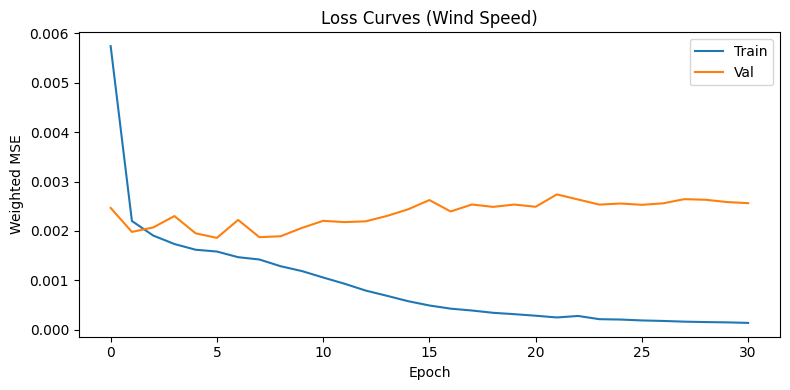

Test Loss (front-weighted MSE): 0.0011

Final Test Metrics (last step, m/s): MSE=1.05, RMSE=1.02, MAE=0.80, R²=0.4378, Adj R²=0.4358
Final Test Metrics (full 24h path): RMSE=0.87, MAE=0.67
Hourly-averaged RMSE by lead hour (0→23):
[0.21, 0.36, 0.51, 0.63, 0.72, 0.78, 0.83, 0.86, 0.88, 0.9 , 0.91, 0.91,
 0.91, 0.91, 0.92, 0.94, 0.96, 0.99, 1.  , 1.01, 1.02, 1.02, 1.02, 1.02]
Avg inference latency: 1.49 ms/batch • 1.49 ms/sample


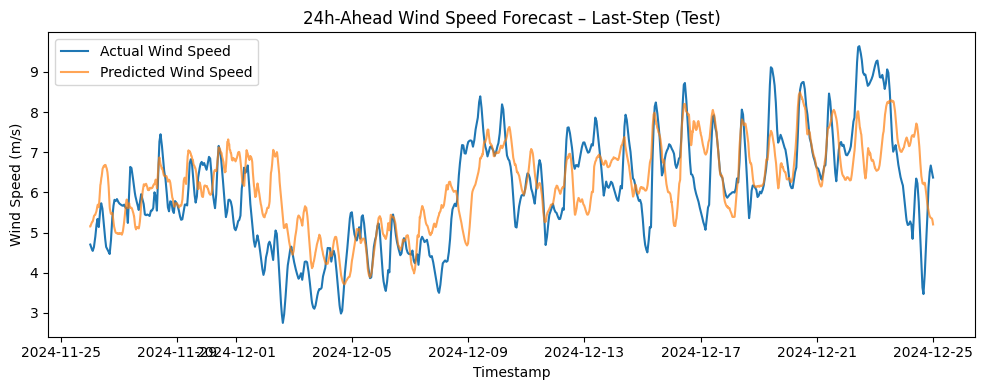

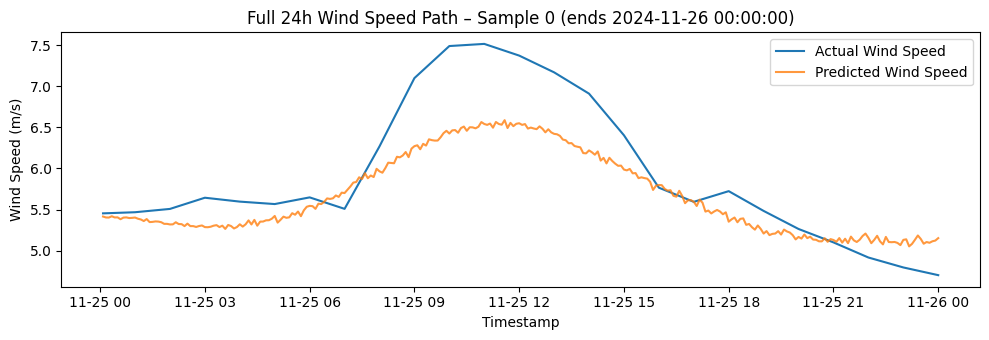

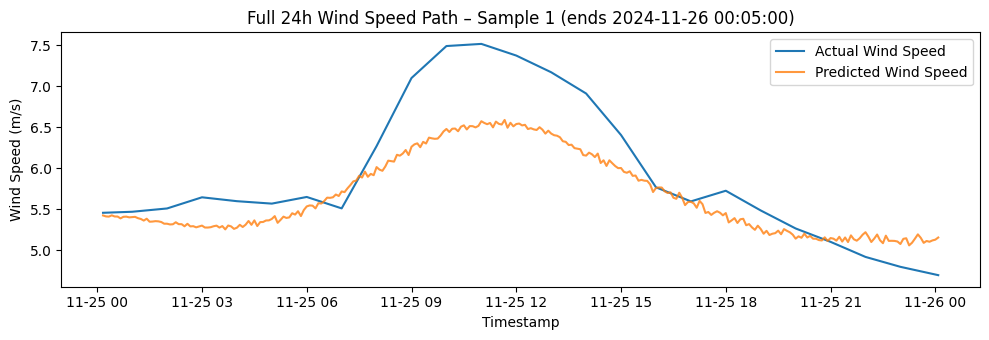

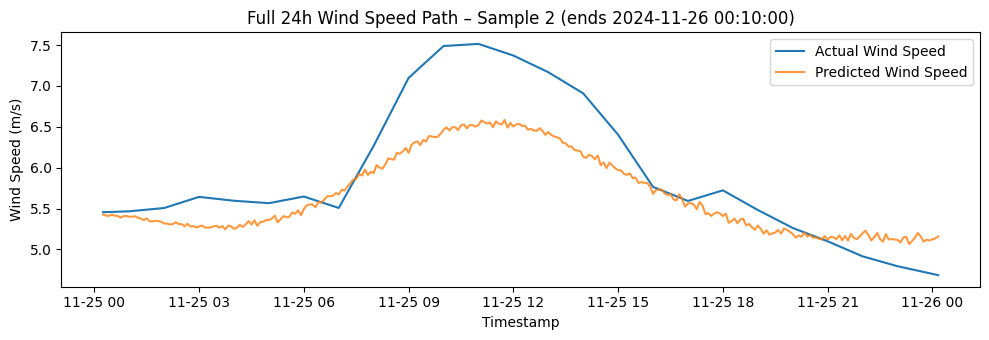

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import time, random, math
from typing import List
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1337)

# ----------------------------
# Dataset
# ----------------------------
class LoadWindowDataset(Dataset):
    def __init__(self, data_array, window, horizon):
        self.data = data_array
        self.window, self.horizon = window, horizon
        self.n = data_array.shape[0] - window - horizon + 1
        if self.n <= 0:
            raise ValueError("Window/horizon too large for data length.")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window]                                        # [W, F]
        y_seq = self.data[idx + self.window: idx + self.window + self.horizon, -1:] # [H, 1]
        return torch.from_numpy(x).float(), torch.from_numpy(y_seq).float()

# ----------------------------
# Model: Transformer forecaster
# ----------------------------
class PositionalEncoding(nn.Module):
    """Standard sinusoidal PE (batch_first: [B, T, D])."""
    def __init__(self, d_model: int, max_len: int = 10000, dropout: float = 0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)  # [T, D]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # [T, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # even
        pe[:, 1::2] = torch.cos(position * div_term)  # odd
        pe = pe.unsqueeze(0)  # [1, T, D]
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, T, D]
        T = x.size(1)
        x = x + self.pe[:, :T, :]
        return self.dropout(x)

class TransformerForecaster(nn.Module):
    """
    Encoder-only Transformer:
      - Input: [B, W, F]
      - Linear embed: F -> d_model
      - Add positional encodings
      - TransformerEncoder (batch_first)
      - Temporal mean pool -> [B, d_model]
      - Concatenate with raw last-step features [B, F]
      - MLP head -> horizon
      - Output: [B, H, 1]
    """
    def __init__(
        self,
        n_features: int,
        window: int,
        horizon: int,
        d_model: int = 128,
        nhead: int = 8,
        num_layers: int = 4,
        dim_feedforward: int = 256,
        p_drop: float = 0.1
    ):
        super().__init__()
        assert d_model % nhead == 0, "d_model must be divisible by nhead"
        self.n_features = n_features
        self.window = window
        self.horizon = horizon
        self.d_model = d_model

        self.input_proj = nn.Linear(n_features, d_model)
        self.pos_enc = PositionalEncoding(d_model=d_model, max_len=window, dropout=p_drop)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=p_drop,
            batch_first=True,
            activation='gelu',
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.enc_ln = nn.LayerNorm(d_model)

        # Head after pooling + concat(last-step raw features)
        concat_dim = d_model + n_features
        self.head = nn.Sequential(
            nn.Linear(concat_dim, 2 * d_model),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Linear(2 * d_model, horizon)
        )

        # Initialize
        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.input_proj.weight)
        nn.init.zeros_(self.input_proj.bias)
        for m in self.head:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, W, F]
        B, W, F = x.shape
        h = self.input_proj(x)            # [B, W, D]
        h = self.pos_enc(h)               # [B, W, D]
        h = self.encoder(h)               # [B, W, D]
        h = self.enc_ln(h)

        # Temporal mean pooling
        h_pool = h.mean(dim=1)            # [B, D]

        # Skip: last-step raw features
        x_last = x[:, -1, :]              # [B, F]
        z = torch.cat([h_pool, x_last], dim=1)  # [B, D+F]

        yhat = self.head(z)               # [B, H]
        return yhat.unsqueeze(-1)         # [B, H, 1]

# ----------------------------
# Early Stopping (CPU snapshot)
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=25, delta=1e-4, verbose=True):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.best_loss = np.inf
        self.wait = 0
        self.should_stop = False
        self.best_state = None

    def step(self, val_loss, model=None):
        improved = val_loss < self.best_loss - self.delta
        if improved:
            self.best_loss = val_loss
            self.wait = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: stop after {self.patience} epochs.")
        return improved

# ----------------------------
# Helpers
# ----------------------------
def infer_5min_freq(index: pd.DatetimeIndex) -> pd.Timedelta:
    freq = pd.infer_freq(index)
    if freq is None:
        diffs = pd.Series(index[1:] - index[:-1])
        step = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=5)
    else:
        step = pd.Timedelta(freq)
    if step != pd.Timedelta(minutes=5):
        print(f"[WARN] Detected step={step}. Script assumes 5-minute cadence.")
    return step

def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour + idx.minute/60.0
    hod = hour / 24.0
    dow = idx.dayofweek.astype(float) / 7.0
    doy = (idx.dayofyear.astype(float) - 1.0) / 366.0
    cal = pd.DataFrame(index=idx)
    cal["hod_sin"] = np.sin(2*np.pi*hod); cal["hod_cos"] = np.cos(2*np.pi*hod)
    cal["dow_sin"] = np.sin(2*np.pi*dow); cal["dow_cos"] = np.cos(2*np.pi*dow)
    cal["doy_sin"] = np.sin(2*np.pi*doy); cal["doy_cos"] = np.cos(2*np.pi*doy)
    return cal

def cosine_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / float(warmup_epochs)
        denom = max(float(total_epochs - warmup_epochs), 1.0)
        progress = min(max((epoch - warmup_epochs) / denom, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)
    )

# ----------------------------
# Main
# ----------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset
    df = pd.read_csv(
        'Dataset/Wind/wind_forecasting_final.csv',
        parse_dates=['DATETIME'],
        index_col='DATETIME'
    ).fillna(0)

    # Target column
    target_col = 'WS50M'
    df['TARGET'] = df[target_col]

    # --- Use all the features you already have ---
    # Drop target from the features so it's only in TARGET
    feature_cols = [c for c in df.columns if c not in ['TARGET', target_col]]

    X_exo = df[feature_cols].copy()

    # Handle inf/nan
    X_exo.replace([np.inf, -np.inf], np.nan, inplace=True)
    finite_rows = np.isfinite(X_exo.to_numpy()).all(axis=1)
    finite_target = np.isfinite(df['TARGET'].to_numpy())
    valid_mask = finite_rows & finite_target

    df    = df.loc[valid_mask].copy()
    X_exo = X_exo.loc[valid_mask].copy()

    # Window end timestamps
    W = 7 * 24 * 12   # lookback
    H = 1 * 24 * 12   # horizon
    times = df.index[W + H - 1 :]

    # Splits
    train_end = pd.Timestamp('2023-12-25 23:55:00')
    val_end   = pd.Timestamp('2024-11-25 23:55:00')

    # --- Scaling ---
    train_mask_for_scaler = df.index <= train_end
    feat_scaler = MinMaxScaler()
    feat_scaler.fit(X_exo.loc[train_mask_for_scaler])
    X_feats_scaled = feat_scaler.transform(X_exo)

    tgt_scaler = MinMaxScaler()
    tgt_scaler.fit(df.loc[train_mask_for_scaler, ['TARGET']])
    y_scaled = tgt_scaler.transform(df[['TARGET']])

    # Final array
    data = np.hstack([X_feats_scaled, y_scaled])
    n_features = data.shape[1]  # all features + target

    # ----------------------------
    # Indexing with optional stride (speeds up training)
    # ----------------------------
    stride = 6  # Smaller stride for wind data (changes faster)
    all_idx = np.arange(len(times))
    train_idx = all_idx[times <= train_end][::stride]
    val_idx   = all_idx[(times > train_end) & (times <= val_end)][::stride]
    test_idx  = all_idx[times > val_end]

    print(f"Train windows: {len(train_idx)}, Validation windows: {len(val_idx)}, Test windows: {len(test_idx)}")
    if len(times) > 0:
        print(f"First window ts: {times.min()}, Last: {times.max()}")
    assert len(train_idx) > 0, "No training windows found—check train_end vs. data coverage"
    assert len(val_idx) > 0, "No validation windows found—check val_end vs. data coverage"
    assert len(test_idx) > 0, "No test windows found—does your data extend past val_end?"

    # Datasets / Loaders
    full_ds = LoadWindowDataset(data, W, H)
    train_ds = Subset(full_ds, train_idx)
    val_ds   = Subset(full_ds, val_idx)
    test_ds  = Subset(full_ds, test_idx)

    pin = (device.type == 'cuda')
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)

    # ----------------------------
    # Transformer model + optimizer + loss + scheduler
    # ----------------------------
    model = TransformerForecaster(
        n_features=n_features, window=W, horizon=H,
        d_model=128, nhead=8, num_layers=4, dim_feedforward=256, p_drop=0.1
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    es = EarlyStopping(patience=25, delta=1e-4, verbose=True)

    # Weighted loss for wind forecasting (emphasize short-term accuracy)
    weights = torch.linspace(1.5, 0.5, steps=H, device=device).view(1, H, 1)
    def weighted_mse(pred, target):
        return ((weights * (pred - target) ** 2).mean())
    f_fn = weighted_mse

    total_epochs = 100
    warmup_epochs = 20
    sched = cosine_warmup_scheduler(opt, warmup_epochs, total_epochs)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of parameters:", n_params)

    train_losses, val_losses = [], []

    # ----------------------------
    # Training Loop
    # ----------------------------
    for ep in range(1, total_epochs + 1):
        t0 = time.time()
        model.train()
        tl = 0.0
        for Xb, Yseqb in train_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            loss = f_fn(yhat, Yseqb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
        train_losses.append(tl / len(train_ds))

        # Validation
        model.eval()
        vl, preds_last_scaled, truths_last_scaled = 0.0, [], []
        preds_full_scaled, truths_full_scaled = [], []
        with torch.no_grad():
            for Xb, Yseqb in val_loader:
                Xb, Yseqb = Xb.to(device), Yseqb.to(device)
                yhat = model(Xb)
                vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
                preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
                truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
                preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
                truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
        val_loss = vl / len(val_ds)
        val_losses.append(val_loss)

        # step LR ONCE PER EPOCH
        sched.step()

        # Inverse metrics
        preds = np.concatenate(preds_last_scaled)
        truths = np.concatenate(truths_last_scaled)
        inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
        inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]
        rm  = root_mean_squared_error(inv_t, inv_p)
        mae = mean_absolute_error(inv_t, inv_p)
        r2  = r2_score(inv_t, inv_p)
        mape = smape(inv_t, inv_p)

        pf = np.concatenate(preds_full_scaled, axis=0)
        tf = np.concatenate(truths_full_scaled, axis=0)
        inv_pf = tgt_scaler.inverse_transform(pf.reshape(-1,1))[:,0]
        inv_tf = tgt_scaler.inverse_transform(tf.reshape(-1,1))[:,0]
        rm_all  = root_mean_squared_error(inv_tf, inv_pf)
        mae_all = mean_absolute_error(inv_tf, inv_pf)
        mape_all = smape(inv_tf, inv_pf)

        cur_lr = opt.param_groups[0]['lr']
        print(f"Ep{ep:02d} Train={train_losses[-1]:.4f} | Val={val_loss:.4f} | "
              f"Val(last) RMSE={rm:.1f} MAE={mae:.1f} MAPE={mape:.2f}% R²={r2:.3f} | "
              f"Val(full) RMSE={rm_all:.1f} MAE={mae_all:.1f} MAPE={mape_all:.2f}% | "
              f"LR={cur_lr:.6f} | Time={time.time()-t0:.1f}s")

        _ = es.step(val_loss, model=model)
        if es.should_stop:
            if es.best_state is not None:
                model.load_state_dict(es.best_state)
                if es.verbose:
                    print("EarlyStopping: best weights restored.")
            break

    # ----------------------------
    # Loss curves
    # ----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Weighted MSE'); plt.legend(); plt.title('Loss Curves (Wind Speed)')
    plt.tight_layout(); plt.show()

    # ----------------------------
    # Testing
    # ----------------------------
    model.eval()
    preds_last_scaled, truths_last_scaled = [], []
    preds_full_scaled, truths_full_scaled = [], []
    test_vl = 0.0
    with torch.no_grad():
        for Xb, Yseqb in test_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            test_vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
            preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
            truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
            preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
            truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
    test_loss = test_vl / len(test_ds)

    preds = np.concatenate(preds_last_scaled)
    truths = np.concatenate(truths_last_scaled)
    inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
    inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]

    mse = mean_squared_error(inv_t, inv_p)
    rm  = root_mean_squared_error(inv_t, inv_p)
    mae = mean_absolute_error(inv_t, inv_p)
    r2  = r2_score(inv_t, inv_p)
    n, p = len(inv_t), (n_features - 1)
    adj_r2 = 1 - (1-r2)*(n-1)/max(n-p-1, 1)

    PH = np.concatenate(preds_full_scaled, axis=0)
    TH = np.concatenate(truths_full_scaled, axis=0)
    inv_pf = tgt_scaler.inverse_transform(PH.reshape(-1,1))[:,0]
    inv_tf = tgt_scaler.inverse_transform(TH.reshape(-1,1))[:,0]
    rm_all  = root_mean_squared_error(inv_tf, inv_pf)
    mae_all = mean_absolute_error(inv_tf, inv_pf)

    # Per-lead RMSE (hourly average over 24h)
    lead_rmse = []
    for h in range(PH.shape[1]):
        inv_ph = tgt_scaler.inverse_transform(PH[:, h].reshape(-1,1))[:,0]
        inv_th = tgt_scaler.inverse_transform(TH[:, h].reshape(-1,1))[:,0]
        lead_rmse.append(root_mean_squared_error(inv_th, inv_ph))
    hourly_rmse = np.array(lead_rmse).reshape(-1, 12).mean(axis=1)

    print(f"Test Loss (front-weighted MSE): {test_loss:.4f}")
    print(f"\nFinal Test Metrics (last step, m/s): "
          f"MSE={mse:.2f}, RMSE={rm:.2f}, MAE={mae:.2f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}")
    print(f"Final Test Metrics (full 24h path): RMSE={rm_all:.2f}, MAE={mae_all:.2f}")
    print("Hourly-averaged RMSE by lead hour (0→23):")
    print(np.array2string(hourly_rmse, precision=2, separator=', '))

    # Inference latency (batch=1)
    _ = model(torch.randn(1, W, n_features).to(device))
    if device.type == 'cuda':
        torch.cuda.synchronize()
    Nruns = 100
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    total_time = 0.0
    with torch.no_grad():
        for _ in range(Nruns):
            inp = torch.randn(1, W, n_features).to(device)
            start.record(); _ = model(inp); end.record()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            total_time += start.elapsed_time(end) / 1000.0
    avg_batch = total_time / Nruns
    print(f"Avg inference latency: {avg_batch*1000:.2f} ms/batch • {avg_batch*1000:.2f} ms/sample")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(times[test_idx], inv_t, label='Actual Wind Speed')
    plt.plot(times[test_idx], inv_p, label='Predicted Wind Speed', alpha=0.7)
    plt.title("24h-Ahead Wind Speed Forecast – Last-Step (Test)")
    plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Show sample forecasts
    num_show = min(3, len(test_idx))
    if num_show > 0:
        Xb, Yseqb = next(iter(DataLoader(test_ds, batch_size=num_show, shuffle=False)))
        Xb = Xb.to(device)
        with torch.no_grad():
            yhat = model(Xb).cpu().numpy()
        ytrue = Yseqb.numpy()
        for i in range(min(num_show, Xb.size(0))):
            pred_i = tgt_scaler.inverse_transform(yhat[i, :, 0].reshape(-1,1))[:,0]
            true_i = tgt_scaler.inverse_transform(ytrue[i, :, 0].reshape(-1,1))[:,0]
            end_ts = times[test_idx[i]]
            tgrid = pd.date_range(end=end_ts, periods=H, freq='5min')
            plt.figure(figsize=(10,3.5))
            plt.plot(tgrid, true_i, label='Actual Wind Speed')
            plt.plot(tgrid, pred_i, label='Predicted Wind Speed', alpha=0.8)
            plt.title(f"Full 24h Wind Speed Path – Sample {i} (ends {end_ts})")
            plt.xlabel("Timestamp"); plt.ylabel("Wind Speed (m/s)")
            plt.legend(); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()